In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.refined import REFINED
from kan import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


import traceback
import time
import gc
import copy
import traceback
import cv2
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import csv


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST 3.23

In [4]:
folder="data/treasury"
x_col=["1Y-CMaturityRate", "30Y-CMortgageRate", "3M-Rate-AuctionAverage", "3M-Rate-SecondaryMarket", "3Y-CMaturityRate", 
       "5Y-CMaturityRate", "bankCredit", "currency", "demandDeposits", "federalFunds", "moneyStock", "checkableDeposits", 
       "loansLeases", "savingsDeposits", "tradeCurrencies"]

target_col=["target"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def complete_coordinate_and_xcol(coordinate, x_col):
    """
    Given a coordinate (tuple of row, col arrays) and x_col feature list,
    return completed coordinate and x_col including empty positions.

    Empty positions are filled with labels: 'Ex1', 'Ex2', ...
    """

    row_coords, col_coords = coordinate
    max_row = row_coords.max()
    max_col = col_coords.max()
    
    # All possible coordinate slots
    full_coords = set((r, c) for r in range(max_row + 1) for c in range(max_col + 1))
    current_coords = set(zip(row_coords, col_coords))
    missing_coords = sorted(full_coords - current_coords)

    # Create updated coordinate arrays
    new_row_coords = list(row_coords)
    new_col_coords = list(col_coords)
    new_x_col = list(x_col)

    for idx, (r, c) in enumerate(missing_coords):
        new_row_coords.append(r)
        new_col_coords.append(c)
        new_x_col.append(f"Ex{idx+1}")

    completed_coordinate = (np.array(new_row_coords), np.array(new_col_coords))
    return completed_coordinate, new_x_col

In [8]:
def plot_feature_mapping(x_col, coordinate, scale=(4,4)):
    grid = np.full(scale, "", dtype=object)
    rows, cols = coordinate
    for i, (r, c) in enumerate(zip(rows, cols)):
        if i < len(x_col):
            grid[r, c] = x_col[i]
        else:
            grid[r, c] = "?"
    
    plt.figure(figsize=(scale[1] * 2, scale[0] * 2))
    for i in range(scale[0]):
        for j in range(scale[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center', fontsize=10,
                     bbox=dict(facecolor='white', edgecolor='gray'))
    
    plt.xticks(np.arange(scale[1]))
    plt.yticks(np.arange(scale[0]))
    plt.grid(True)
    plt.title("Feature → Pixel Mapping")
    plt.gca().invert_yaxis()  # So row 0 is at the top
    plt.show()

In [9]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [10]:
def average_rmse(output, val_target):
    """
    Computes the root mean squared error (RMSE) between output and val_target.

    Args:
        output (torch.Tensor): The predicted output tensor.
        val_target (torch.Tensor): The ground truth tensor.
    
    Returns:
        float: The RMSE value.
    """
    mse = torch.mean((output - val_target) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [11]:
def plot_training_RMSE(train_loss, val_loss):
    plt.figure(figsize=(5, 4))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['train', 'val'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')

In [12]:
def plot_sorted_feature_importance(columns, importances, plot=False):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    print(sorted_pairs)
    sorted_columns, sorted_importances = zip(*sorted_pairs)
    if plot:
        # Create the bar plot
        plt.figure(figsize=(6, 3))
        plt.barh(sorted_columns, sorted_importances, color='royalblue')
        plt.xlabel('Importance')
        plt.title('KAN Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    return sorted_pairs

### Grad CAM Functions

In [15]:
def grad_cam_side_by_side(model, model_state, num_input, img_input, x_col, coordinate,
                          zoom=1, target_index=None, save_path=None, show=True):
    model.load_state_dict(model_state)
    model.eval()
    model.zero_grad()

    if num_input.dim() == 1:
        num_input = num_input.unsqueeze(0)
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    num_input = num_input.to(model.device)
    img_input = img_input.to(model.device)

    # Store activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    conv_layer = model.cnn_branch[0]
    h_fwd = conv_layer.register_forward_hook(forward_hook)
    h_bwd = conv_layer.register_full_backward_hook(backward_hook)

    output = model(num_input, img_input)
    target = output if target_index is None else output[:, target_index]
    target.backward()

    act = activations["value"].squeeze(0)
    grad = gradients["value"].squeeze(0)
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam[:] = 0.0


    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=img_input.shape[-2:], mode='bilinear', align_corners=False)
    #print(cam_resized)
    heatmap = cam_resized.squeeze().cpu()

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_disp, cmap=cmap)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    im = axs[1].imshow(img_disp, cmap=cmap)
    heatmap_img = axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    # Add colorbar (legend)
    cbar = fig.colorbar(heatmap_img, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Grad-CAM Intensity", fontsize=10)

    # Overlay abbreviated features
    for i, col in enumerate(x_col):
        abbrev = col.split("-")[0][:8]
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < h and cx < w:
                axs[1].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))
                axs[0].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

    h_fwd.remove()
    h_bwd.remove()

    return heatmap

In [16]:
def heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom=1):
    """
    Map heatmap pixel intensities to their corresponding features using coordinate and zoom.
    Returns a dictionary of {feature_name: relevance_score}.
    """
    feature_scores = {}

    for i, col in enumerate(x_col):
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < heatmap.shape[0] and cx < heatmap.shape[1]:
                feature_scores[col] = heatmap[ry, cx].item()

    return feature_scores

def plot_feature_relevance_bar(feature_scores, plot=False):
    """
    Plots a horizontal bar chart of feature relevance from Grad-CAM heatmap.
    """
    sorted_scores = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
    print(sorted_scores)
    features, scores = zip(*sorted_scores)
    if plot:
        plt.figure(figsize=(6, 3))
        plt.barh(features, scores, color='royalblue')
        plt.xlabel("Grad-CAM Relevance")
        plt.title("Feature Relevance for Test")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    return sorted_scores

In [17]:
def compute_avg_feature_relevance_from_val(model, model_state, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Computes average Grad-CAM feature relevance over all validation instances with a tqdm progress bar.

    Args:
        model: Trained model
        model_state: Trained weights to be loaded
        val_inputs: List or tensor of numerical inputs
        val_imgs: List or tensor of image inputs
        coordinate: IGTD-style coordinate tuple (row array, col array)
        x_col: List of feature names (including extras)
        zoom: Zoom level used when generating the images

    Returns:
        Dictionary of average feature relevance
    """
    accumulated_scores = {feature: [] for feature in x_col}

    for num_input, img_input in tqdm(zip(val_inputs, val_imgs), total=len(val_inputs), desc="Computing Grad-CAM"):
        heatmap = grad_cam_side_by_side(
            model=model,
            model_state=model_state,
            num_input=num_input,
            img_input=img_input,
            coordinate=coordinate,
            x_col=x_col,
            zoom=zoom,
            show=False
        )
        scores = heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom)
        for feature, value in scores.items():
            accumulated_scores[feature].append(value)

    # Compute average
    avg_scores = {feature: float(np.mean(values)) if values else 0.0
                  for feature, values in accumulated_scores.items()}

    return avg_scores


def plot_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Combines all steps: compute average relevance and plot.
    """
    avg_scores = compute_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom)
    plot_feature_relevance_bar(avg_scores)
    return avg_scores

### Hybrid Functions

In [23]:
def print_mkan_vs_cnn_relevance(feature_scores, mkan_len):
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()
    m_kan_relevance_perct = float(mkan_relevance/(mkan_relevance+cnn_relevance))
    cnn_relevance_perct = float(cnn_relevance/(mkan_relevance+cnn_relevance))
    print(f"M_KAN Relevance: {m_kan_relevance_perct}")
    print(f"CNN Relevance: {cnn_relevance_perct}")
    return m_kan_relevance_perct, cnn_relevance_perct

In [24]:
def plot_mkan_vs_cnn_relevance(feature_scores, mkan_len=-1, title="Feature Relevance Split"):
    """
    Plots a pie chart comparing the total feature relevance from m_kan output vs CNN output.

    Args:
        feature_scores (torch.Tensor or list): 1D tensor of relevance values from final_kan.
        mkan_len (int): Number of dimensions from m_kan (default: 6).
        title (str): Title for the pie chart.
    """
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()

    sizes = [mkan_relevance, cnn_relevance]
    labels = ['m_kan Output', 'CNN Output']
    explode = (0.05, 0)  # Slightly explode m_kan slice for emphasis

    plt.figure(figsize=(3, 3))
    plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=140, colors=["#66c2a5", "#fc8d62"])
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [64]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()

            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        eval_loss_item = torch.sqrt(eval_loss.detach()).item()
        
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(eval_loss_item)
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup
        if math.isnan(eval_loss_item):
            break
    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return best_model_state, results, best_epoch

In [26]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha, hidden_dim, embed_dim, num_heads):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid,
                            cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)

        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [27]:
def cnn_branch_relevance(model, best_model_state):
    avg_scores = compute_avg_feature_relevance_from_val(
        model=model,
        model_state=best_model_state,
        val_inputs=dataset["test_input"],
        val_imgs=dataset["test_img"],
        coordinate=completed_coordinate,
        x_col=completed_x_col,
        zoom=2
    )
    return plot_feature_relevance_bar(avg_scores)

In [28]:
def train_and_plot_relevance(model_class, kan_neurons, kan_grid, lamb, steps, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, n_kan_len=None, filename=None, opt_col_val=None):
    torch.cuda.empty_cache()
    gc.collect()
    model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=kan_neurons, kan_grid=kan_grid,
                             cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)
    best_model_state, metrics3, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", lamb=lamb, steps=steps)
    model.load_state_dict(best_model_state)
    rmse = average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label'])
    print(rmse)
    #plot_training_RMSE(metrics3['train_loss'], metrics3['eval_loss'])
    if not n_kan_len:
        n_kan_len = kan_neurons
    k_rel, cnn_rel = print_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=n_kan_len)
    #plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=kan_neurons)
    kan_mrf = ""#plot_sorted_feature_importance(x_col, model.m_kan.feature_score)
    
    cnn_mrf = "" #cnn_branch_relevance(model, best_model_state)

    append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, rmse, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf)

### Write metrics

In [48]:
def create_csv_with_header(filename, columns_opt):
    header=['kan_neurons', 'kan_grid', 'lamb', columns_opt, 'RMSE','Best_Epoch','KAN_Relevance','CNN_Relevance','KAN M.R.F.','CNN M.R.F.']
    """Creates a CSV file with a given header."""
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

In [49]:
def format_top_3(pairs):
    return '\n'.join(f"{k}: {v:.2f}" for k, v in pairs[:3])

In [50]:
def append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, acc, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf):
    row = [kan_neurons, kan_grid, lamb, opt_col_val, acc, best_epoch, k_rel, cnn_rel, format_top_3(kan_mrf), format_top_3(cnn_mrf)]
    """Appends a single row to an existing CSV file."""
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"{filename} does not exist. Please create the file first with a header.")
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

### Models Class Hybrids

In [62]:
class Model3_1(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_1, self).__init__()

        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 7, 7]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Dummy pass to get flattened size
        self.flat_size = self._get_flat_size(imgs_shape)

        # Bottleneck layer
        self.cnn_bottleneck = nn.Linear(self.flat_size, cnn_bottleneck_dim).to(device)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Final KAN layer
        self.final_kan = KAN(
            width=[cnn_bottleneck_dim + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.shape[1]

    def get_concat_output(self, mlp_input, cnn_input):
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        conv_out = self.cnn_branch(cnn_input)
        cnn_output = self.cnn_bottleneck(conv_out)

        kan_output = self.m_kan(kan_input)

        return torch.cat((kan_output, cnn_output), dim=1)

    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [58]:
class Model3_2(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_2, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 7, 7]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device
        self.alpha = alpha


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        cnn_output = cnn_output * self.alpha
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [59]:
class Model3_3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_3, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 7, 7]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Gating MLP: inputs are concatenated CNN + KAN representations
        self.gate_net = nn.Sequential(
            nn.Linear(self.flat_size + kan_neurons, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output ∈ [0,1]
        ).to(device)

        # Final regressor (KAN layer)
        self.final_kan = KAN(
            width=[kan_neurons + self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(4, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        mlp_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        kan_out = self.m_kan(mlp_input)                  # shape: (B, kan_neurons)
        cnn_out = self.cnn_branch(cnn_input)             # shape: (B, cnn_flat)

        concat = torch.cat((kan_out, cnn_out), dim=1)    # For gating
        alpha = self.gate_net(concat)                    # shape: (B, 1)

        gated_kan = (1 - alpha) * kan_out                # shape: (B, kan_neurons)
        gated_cnn = alpha * cnn_out                      # shape: (B, cnn_flat)

        return torch.cat((gated_kan, gated_cnn), dim=1)  # shape: (B, total)

    def forward(self, mlp_input, cnn_input):
        fused = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(fused)


In [60]:
class Model3_4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_4, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 7, 7]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)


        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN Branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Linear projections for Q, K, V
        self.query_proj = nn.Linear(kan_neurons, embed_dim).to(device)
        self.key_proj = nn.Linear(self.flat_size, embed_dim).to(device)
        self.value_proj = nn.Linear(self.flat_size, embed_dim).to(device)

        # Attention module
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True).to(device)

        # Final regression layer (KAN again)
        self.final_kan = KAN(
            width=[embed_dim, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )


    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        return self.cnn_branch(dummy_input).shape[1]

    
    def get_concat_output(self, mlp_input, cnn_input):
        # Get KAN and CNN outputs
        kan_out = self.m_kan(mlp_input.to(self.device))  # [B, D_kan]
        cnn_out = self.cnn_branch(cnn_input.to(self.device))  # [B, D_cnn]

        # Project into Q, K, V space
        Q = self.query_proj(kan_out).unsqueeze(1)  # [B, 1, E]
        K = self.key_proj(cnn_out).unsqueeze(1)    # [B, 1, E]
        V = self.value_proj(cnn_out).unsqueeze(1)  # [B, 1, E]

        # Cross-attention: KAN attends to CNN
        attn_out, _ = self.attn(Q, K, V)  # [B, 1, E]
        attn_out = attn_out.squeeze(1)   # [B, E]

        return attn_out


    def forward(self, mlp_input, cnn_input):
        attn_out = self.get_concat_output(mlp_input, cnn_input)

        return self.final_kan(attn_out)

# Load Dataset and Images

In [55]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [56]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [37]:
dataset_name = 'treasury'
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem=problem_type, zoom=2, random_seed=SEED)
name = f"REFINED"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [39]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 8, 8)
Attributes:  15


In [40]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [41]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([671, 15])
Train target shape: torch.Size([671, 1])
Test data shape: torch.Size([210, 15])
Test target shape: torch.Size([210, 1])
Validation data shape: torch.Size([168, 15])
Validation target shape: torch.Size([168, 1])


# Set Files Name

In [44]:
filename_1=f'{dataset_name}_Refined_Concat_Op1.csv'
filename_2=f'{dataset_name}_Refined_Concat_Op2.csv'
filename_3=f'{dataset_name}_Refined_Concat_Op3.csv'
filename_4=f'{dataset_name}_Refined_Concat_Op4.csv'

In [45]:
columns_opt1 = 'cnn_bottleneck_dim'
columns_opt2 = 'alpha'
columns_opt3 = 'hidden_dim'
columns_opt4 = 'embed_dim, num_heads'

# Option 1: Concat KAN with (CNN with dense layer to reduce output_size)

In [46]:
create_csv_with_header(filename_1, columns_opt1)

In [66]:
print("------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------")
for cnn_bottleneck_dim in [3, 5, 8, 10, 13, 15]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=5, kan_grid=4, lamb=0.0001, steps=50, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

print("------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------")
for cnn_bottleneck_dim in [3, 6, 9, 12, 15]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=6, kan_grid=5, lamb=1e-05, steps=50, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 3, 4, 5]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=50, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for cnn_bottleneck_dim in [1, 3, 5, 7, 9, 11, 14, 17]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=50, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------
cnn_bottleneck_dim: 3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.26e-01 | eval_loss: 1.99e-01 | reg: 3.05e+01 |: 100%|█| 50/50 [00:16<00:00,  3.11it/


saving model version 0.1
Best epoch 35
0.3201027810573578
M_KAN Relevance: 0.36996451020240784
CNN Relevance: 0.6300355195999146
cnn_bottleneck_dim: 5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.24e-01 | eval_loss: 2.10e-01 | reg: 3.02e+01 |: 100%|█| 50/50 [00:15<00:00,  3.14it/


saving model version 0.1
Best epoch 24
0.28382939100265503
M_KAN Relevance: 0.3793247938156128
CNN Relevance: 0.6206751465797424
cnn_bottleneck_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.26e-01 | eval_loss: 1.80e-01 | reg: 2.53e+01 |: 100%|█| 50/50 [00:16<00:00,  3.02it/


saving model version 0.1
Best epoch 47
0.22437173128128052
M_KAN Relevance: 0.28459033370018005
CNN Relevance: 0.7154096961021423
cnn_bottleneck_dim: 10
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.21e-01 | eval_loss: 1.90e-01 | reg: 2.67e+01 |: 100%|█| 50/50 [00:17<00:00,  2.79it/


saving model version 0.1
Best epoch 49
0.3052186369895935
M_KAN Relevance: 0.2579731047153473
CNN Relevance: 0.7420268654823303
cnn_bottleneck_dim: 13
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.43e-01 | eval_loss: 2.44e-01 | reg: 3.21e+01 |: 100%|█| 50/50 [00:17<00:00,  2.80it/


saving model version 0.1
Best epoch 31
0.3032936155796051
M_KAN Relevance: 0.2441091537475586
CNN Relevance: 0.7558908462524414
cnn_bottleneck_dim: 15
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.81e-01 | eval_loss: 1.96e-01 | reg: 3.12e+01 |: 100%|█| 50/50 [00:17<00:00,  2.86it/


saving model version 0.1
Best epoch 47
0.299248605966568
M_KAN Relevance: 0.0742182582616806
CNN Relevance: 0.9257817268371582
------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------
cnn_bottleneck_dim: 3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.02e-01 | eval_loss: 1.68e-01 | reg: 3.35e+01 |: 100%|█| 50/50 [00:15<00:00,  3.14it/


saving model version 0.1
Best epoch 39
0.2971900999546051
M_KAN Relevance: 0.4800789952278137
CNN Relevance: 0.5199210047721863
cnn_bottleneck_dim: 6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.37e-01 | eval_loss: 1.86e-01 | reg: 3.12e+01 |: 100%|█| 50/50 [00:19<00:00,  2.54it/


saving model version 0.1
Best epoch 37
0.2866614758968353
M_KAN Relevance: 0.18091632425785065
CNN Relevance: 0.8190836906433105
cnn_bottleneck_dim: 9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.07e-01 | eval_loss: 1.83e-01 | reg: 3.18e+01 |: 100%|█| 50/50 [00:15<00:00,  3.23it/


saving model version 0.1
Best epoch 48
0.23609794676303864
M_KAN Relevance: 0.3500855565071106
CNN Relevance: 0.6499144434928894
cnn_bottleneck_dim: 12
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.19e-01 | eval_loss: 1.87e-01 | reg: 3.51e+01 |: 100%|█| 50/50 [00:18<00:00,  2.76it/


saving model version 0.1
Best epoch 29
0.2666662633419037
M_KAN Relevance: 0.6019965410232544
CNN Relevance: 0.3980034291744232
cnn_bottleneck_dim: 15
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.04e-01 | eval_loss: 2.11e-01 | reg: 3.37e+01 |: 100%|█| 50/50 [00:17<00:00,  2.89it/


saving model version 0.1
Best epoch 49
0.2941425144672394
M_KAN Relevance: 0.3568151593208313
CNN Relevance: 0.6431848406791687
------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------
cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.26e-01 | eval_loss: 1.71e-01 | reg: 1.82e+01 |: 100%|█| 50/50 [00:17<00:00,  2.80it/


saving model version 0.1
Best epoch 39
0.2697935104370117
M_KAN Relevance: 0.48172253370285034
CNN Relevance: 0.5182774662971497
cnn_bottleneck_dim: 2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.24e-01 | eval_loss: 2.21e-01 | reg: 1.41e+01 |: 100%|█| 50/50 [00:16<00:00,  3.03it/


saving model version 0.1
Best epoch 44
0.4035485088825226
M_KAN Relevance: 0.10850827395915985
CNN Relevance: 0.891491711139679
cnn_bottleneck_dim: 3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.18e-01 | eval_loss: 2.15e-01 | reg: 1.53e+01 |: 100%|█| 50/50 [00:16<00:00,  3.03it/


saving model version 0.1
Best epoch 49
0.34551340341567993
M_KAN Relevance: 0.16546659171581268
CNN Relevance: 0.8345333933830261
cnn_bottleneck_dim: 4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.18e-01 | eval_loss: 2.46e-01 | reg: 1.55e+01 |: 100%|█| 50/50 [00:16<00:00,  3.04it/


saving model version 0.1
Best epoch 31
0.42207902669906616
M_KAN Relevance: 0.12422247231006622
CNN Relevance: 0.875777542591095
cnn_bottleneck_dim: 5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.28e-01 | eval_loss: 2.11e-01 | reg: 1.39e+01 |: 100%|█| 50/50 [00:15<00:00,  3.15it/


saving model version 0.1
Best epoch 49
0.42775535583496094
M_KAN Relevance: 0.025628622621297836
CNN Relevance: 0.9743714332580566
------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------
cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.02e-01 | eval_loss: 3.99e-01 | reg: 4.06e+01 |: 100%|█| 50/50 [00:15<00:00,  3.30it/


saving model version 0.1
Best epoch 20
0.2740822434425354
M_KAN Relevance: 0.39003464579582214
CNN Relevance: 0.6099653244018555
cnn_bottleneck_dim: 3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.13e-01 | eval_loss: 1.93e-01 | reg: 3.76e+01 |: 100%|█| 50/50 [00:16<00:00,  3.02it/


saving model version 0.1
Best epoch 42
0.2928504943847656
M_KAN Relevance: 0.7088497877120972
CNN Relevance: 0.29115018248558044
cnn_bottleneck_dim: 5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 2.02e-01 | eval_loss: 2.10e-01 | reg: 4.35e+01 |: 100%|█| 50/50 [00:17<00:00,  2.93it/


saving model version 0.1
Best epoch 43
0.26511260867118835
M_KAN Relevance: 0.40877142548561096
CNN Relevance: 0.5912285447120667
cnn_bottleneck_dim: 7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.89e-01 | eval_loss: 2.14e-01 | reg: 3.63e+01 |: 100%|█| 50/50 [00:16<00:00,  2.96it/


saving model version 0.1
Best epoch 49
0.24770310521125793
M_KAN Relevance: 0.5073518753051758
CNN Relevance: 0.4926481246948242
cnn_bottleneck_dim: 9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.30e-01 | eval_loss: 2.25e-01 | reg: 4.12e+01 |: 100%|█| 50/50 [00:17<00:00,  2.88it/


saving model version 0.1
Best epoch 22
0.20996275544166565
M_KAN Relevance: 0.5576800107955933
CNN Relevance: 0.44231995940208435
cnn_bottleneck_dim: 11
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.12e-01 | eval_loss: 2.29e-01 | reg: 3.79e+01 |: 100%|█| 50/50 [00:17<00:00,  2.88it/


saving model version 0.1
Best epoch 27
0.2874538004398346
M_KAN Relevance: 0.37511512637138367
CNN Relevance: 0.624884843826294
cnn_bottleneck_dim: 14
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.34e-01 | eval_loss: 1.84e-01 | reg: 3.57e+01 |: 100%|█| 50/50 [00:16<00:00,  3.09it/


saving model version 0.1
Best epoch 49
0.2699705958366394
M_KAN Relevance: 0.3887125551700592
CNN Relevance: 0.6112874746322632
cnn_bottleneck_dim: 17
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 1.18e-01 | eval_loss: 1.82e-01 | reg: 3.99e+01 |: 100%|█| 50/50 [00:15<00:00,  3.27it/

saving model version 0.1
Best epoch 49
0.26912814378738403
M_KAN Relevance: 0.4729674160480499
CNN Relevance: 0.5270325541496277


# Option 2: Multiply CNN output by factor

In [67]:
create_csv_with_header(filename_2, columns_opt2)

In [68]:
print("------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=5, kan_grid=4, lamb=0.0001, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=6, kan_grid=5, lamb=1e-05, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 1.21e-01 | eval_loss: 1.75e-01 | reg: 8.60e+01 |: 100%|█| 60/60 [00:54<00:00,  1.11it/


saving model version 0.1
Best epoch 28
0.2824234664440155
M_KAN Relevance: 0.13202397525310516
CNN Relevance: 0.8679760694503784
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 1.17e-01 | eval_loss: 1.72e-01 | reg: 8.45e+01 |: 100%|█| 60/60 [00:52<00:00,  1.14it/


saving model version 0.1
Best epoch 51
0.281978040933609
M_KAN Relevance: 0.17065374553203583
CNN Relevance: 0.829346239566803
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 1.15e-01 | eval_loss: 1.96e-01 | reg: 8.69e+01 |: 100%|█| 60/60 [00:53<00:00,  1.11it/


saving model version 0.1
Best epoch 19
0.2541979253292084
M_KAN Relevance: 0.12353433668613434
CNN Relevance: 0.8764656782150269
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 1.32e-01 | eval_loss: 2.04e-01 | reg: 8.74e+01 |: 100%|█| 60/60 [00:54<00:00,  1.10it/


saving model version 0.1
Best epoch 22
0.2833252549171448
M_KAN Relevance: 0.16367998719215393
CNN Relevance: 0.8363199830055237
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 1.10e-01 | eval_loss: 1.80e-01 | reg: 8.01e+01 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 31
0.22125422954559326
M_KAN Relevance: 0.1703607141971588
CNN Relevance: 0.8296393156051636
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 1.05e-01 | eval_loss: 1.93e-01 | reg: 7.78e+01 |: 100%|█| 60/60 [00:51<00:00,  1.15it/


saving model version 0.1
Best epoch 24
0.25388988852500916
M_KAN Relevance: 0.15169155597686768
CNN Relevance: 0.8483084440231323
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 9.56e-02 | eval_loss: 2.01e-01 | reg: 7.26e+01 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 18
0.26126912236213684
M_KAN Relevance: 0.13807711005210876
CNN Relevance: 0.8619229197502136
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 9.82e-02 | eval_loss: 2.08e-01 | reg: 7.20e+01 |: 100%|█| 60/60 [00:51<00:00,  1.16it/


saving model version 0.1
Best epoch 18
0.20364317297935486
M_KAN Relevance: 0.27712705731391907
CNN Relevance: 0.7228729724884033
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 1.01e-01 | eval_loss: 2.28e-01 | reg: 6.21e+01 |: 100%|█| 60/60 [00:52<00:00,  1.14it/


saving model version 0.1
Best epoch 19
0.24913448095321655
M_KAN Relevance: 0.4000040292739868
CNN Relevance: 0.5999959707260132
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 9.36e-02 | eval_loss: 1.97e-01 | reg: 5.85e+01 |: 100%|█| 60/60 [00:52<00:00,  1.15it/


saving model version 0.1
Best epoch 16
0.24787816405296326
M_KAN Relevance: 0.44098350405693054
CNN Relevance: 0.5590164065361023
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 9.34e-02 | eval_loss: 1.79e-01 | reg: 6.78e+01 |: 100%|█| 60/60 [00:51<00:00,  1.17it/


saving model version 0.1
Best epoch 28
0.20850415527820587
M_KAN Relevance: 0.4127265214920044
CNN Relevance: 0.5872735381126404
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 9.21e-02 | eval_loss: 1.80e-01 | reg: 7.21e+01 |: 100%|█| 60/60 [00:51<00:00,  1.17it/


saving model version 0.1
Best epoch 8
0.2317018210887909
M_KAN Relevance: 0.30484437942504883
CNN Relevance: 0.6951556205749512
------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.62e-02 | eval_loss: 2.33e-01 | reg: 1.20e+02 |: 100%|█| 60/60 [00:58<00:00,  1.03it/


saving model version 0.1
Best epoch 31
0.2902772128582001
M_KAN Relevance: 0.16924728453159332
CNN Relevance: 0.8307526707649231
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.55e-02 | eval_loss: 2.25e-01 | reg: 1.47e+02 |: 100%|█| 60/60 [00:58<00:00,  1.02it/


saving model version 0.1
Best epoch 20
0.29425498843193054
M_KAN Relevance: 0.15322403609752655
CNN Relevance: 0.8467759490013123
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.29e-02 | eval_loss: 2.44e-01 | reg: 1.24e+02 |: 100%|█| 60/60 [00:59<00:00,  1.01it/


saving model version 0.1
Best epoch 15
0.2628832757472992
M_KAN Relevance: 0.20098266005516052
CNN Relevance: 0.7990173697471619
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 7.24e-02 | eval_loss: 2.13e-01 | reg: 1.22e+02 |: 100%|█| 60/60 [00:59<00:00,  1.01it/


saving model version 0.1
Best epoch 17
0.2280201017856598
M_KAN Relevance: 0.20371288061141968
CNN Relevance: 0.7962871789932251
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.95e-02 | eval_loss: 2.29e-01 | reg: 1.28e+02 |: 100%|█| 60/60 [00:57<00:00,  1.04it/


saving model version 0.1
Best epoch 12
0.23393379151821136
M_KAN Relevance: 0.20765236020088196
CNN Relevance: 0.7923476696014404
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.17e-02 | eval_loss: 2.02e-01 | reg: 1.37e+02 |: 100%|█| 60/60 [00:57<00:00,  1.03it/


saving model version 0.1
Best epoch 12
0.24825920164585114
M_KAN Relevance: 0.19064712524414062
CNN Relevance: 0.8093528747558594
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 7.13e-02 | eval_loss: 2.62e-01 | reg: 1.51e+02 |: 100%|█| 60/60 [00:57<00:00,  1.05it/


saving model version 0.1
Best epoch 11
0.2178720086812973
M_KAN Relevance: 0.2926768958568573
CNN Relevance: 0.7073230743408203
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.04e-02 | eval_loss: 2.52e-01 | reg: 1.26e+02 |: 100%|█| 60/60 [00:59<00:00,  1.01it/


saving model version 0.1
Best epoch 9
0.22390754520893097
M_KAN Relevance: 0.3954160213470459
CNN Relevance: 0.6045839786529541
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.01e-02 | eval_loss: 3.05e-01 | reg: 1.39e+02 |: 100%|█| 60/60 [00:57<00:00,  1.05it/


saving model version 0.1
Best epoch 8
0.24576692283153534
M_KAN Relevance: 0.3761146068572998
CNN Relevance: 0.6238853931427002
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.55e-02 | eval_loss: 3.59e-01 | reg: 1.42e+02 |: 100%|█| 60/60 [00:59<00:00,  1.01it/


saving model version 0.1
Best epoch 4
0.25615668296813965
M_KAN Relevance: 0.398852676153183
CNN Relevance: 0.6011473536491394
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.53e-02 | eval_loss: 2.15e-01 | reg: 1.58e+02 |: 100%|█| 60/60 [00:57<00:00,  1.05it/


saving model version 0.1
Best epoch 8
0.23768477141857147
M_KAN Relevance: 0.3217059373855591
CNN Relevance: 0.6782940626144409
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.52e-02 | eval_loss: 2.26e-01 | reg: 2.02e+02 |: 100%|█| 60/60 [00:59<00:00,  1.01it/


saving model version 0.1
Best epoch 9
0.24577629566192627
M_KAN Relevance: 0.221757709980011
CNN Relevance: 0.7782423496246338
------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.15e-02 | eval_loss: 2.64e-01 | reg: 1.42e+02 |: 100%|█| 60/60 [01:02<00:00,  1.05s/i


saving model version 0.1
Best epoch 37
0.37665337324142456
M_KAN Relevance: 0.011677965521812439
CNN Relevance: 0.9883220195770264
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 4.91e-02 | eval_loss: 2.33e-01 | reg: 1.68e+02 |: 100%|█| 60/60 [01:03<00:00,  1.07s/i


saving model version 0.1
Best epoch 33
0.3804023861885071
M_KAN Relevance: 0.010854423977434635
CNN Relevance: 0.9891455769538879
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.38e-02 | eval_loss: 2.44e-01 | reg: 1.46e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 44
0.4101888835430145
M_KAN Relevance: 0.0003293729678262025
CNN Relevance: 0.999670684337616
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 4.27e-02 | eval_loss: 2.51e-01 | reg: 1.51e+02 |: 100%|█| 60/60 [01:03<00:00,  1.06s/i


saving model version 0.1
Best epoch 45
0.4611798822879791
M_KAN Relevance: 0.0006117798038758337
CNN Relevance: 0.9993882179260254
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.01e-02 | eval_loss: 2.60e-01 | reg: 1.96e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 13
0.4045065939426422
M_KAN Relevance: 0.0015941525343805552
CNN Relevance: 0.9984058141708374
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.61e-02 | eval_loss: 2.48e-01 | reg: 1.77e+02 |: 100%|█| 60/60 [01:03<00:00,  1.06s/i


saving model version 0.1
Best epoch 33
0.3985413908958435
M_KAN Relevance: 0.007365375757217407
CNN Relevance: 0.9926345944404602
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 4.25e-02 | eval_loss: 3.40e-01 | reg: 2.12e+02 |: 100%|█| 60/60 [01:02<00:00,  1.05s/i


saving model version 0.1
Best epoch 9
0.4007520377635956
M_KAN Relevance: 0.009371061809360981
CNN Relevance: 0.9906289577484131
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 4.34e-02 | eval_loss: 4.05e-01 | reg: 2.37e+02 |: 100%|█| 60/60 [01:01<00:00,  1.03s/i


saving model version 0.1
Best epoch 13
0.3344673216342926
M_KAN Relevance: 0.06828203052282333
CNN Relevance: 0.9317179918289185
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.46e-02 | eval_loss: 2.88e-01 | reg: 1.74e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 7
0.28017768263816833
M_KAN Relevance: 0.20859265327453613
CNN Relevance: 0.7914072871208191
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.55e-02 | eval_loss: 2.37e-01 | reg: 1.62e+02 |: 100%|█| 60/60 [00:59<00:00,  1.00it/


saving model version 0.1
Best epoch 7
0.22773894667625427
M_KAN Relevance: 0.31359702348709106
CNN Relevance: 0.6864029765129089
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.81e-02 | eval_loss: 2.07e-01 | reg: 2.06e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 8
0.24157950282096863
M_KAN Relevance: 0.24291442334651947
CNN Relevance: 0.7570855617523193
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.02e-02 | eval_loss: 2.14e-01 | reg: 3.36e+02 |: 100%|█| 60/60 [01:02<00:00,  1.05s/i


saving model version 0.1
Best epoch 4
0.2845836281776428
M_KAN Relevance: 0.1017104983329773
CNN Relevance: 0.8982895016670227
------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 7.15e-02 | eval_loss: 2.17e-01 | reg: 1.97e+02 |: 100%|█| 60/60 [00:52<00:00,  1.15it/


saving model version 0.1
Best epoch 29
0.23979409039020538
M_KAN Relevance: 0.08672059327363968
CNN Relevance: 0.9132794141769409
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 7.01e-02 | eval_loss: 2.38e-01 | reg: 1.76e+02 |: 100%|█| 60/60 [00:52<00:00,  1.13it/


saving model version 0.1
Best epoch 20
0.2601880729198456
M_KAN Relevance: 0.15347327291965485
CNN Relevance: 0.8465267419815063
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 7.28e-02 | eval_loss: 2.91e-01 | reg: 1.59e+02 |: 100%|█| 60/60 [00:53<00:00,  1.13it/


saving model version 0.1
Best epoch 21
0.265715092420578
M_KAN Relevance: 0.13781744241714478
CNN Relevance: 0.8621825575828552
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 7.05e-02 | eval_loss: 1.91e-01 | reg: 1.43e+02 |: 100%|█| 60/60 [00:52<00:00,  1.14it/


saving model version 0.1
Best epoch 35
0.24894879758358002
M_KAN Relevance: 0.15160374343395233
CNN Relevance: 0.8483962416648865
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.46e-02 | eval_loss: 2.28e-01 | reg: 1.82e+02 |: 100%|█| 60/60 [00:52<00:00,  1.15it/


saving model version 0.1
Best epoch 24
0.2591503858566284
M_KAN Relevance: 0.13097181916236877
CNN Relevance: 0.8690281510353088
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.64e-02 | eval_loss: 2.08e-01 | reg: 1.94e+02 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 27
0.2620956599712372
M_KAN Relevance: 0.12135549634695053
CNN Relevance: 0.8786445260047913
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.51e-02 | eval_loss: 2.36e-01 | reg: 1.75e+02 |: 100%|█| 60/60 [00:53<00:00,  1.13it/


saving model version 0.1
Best epoch 13
0.2810751497745514
M_KAN Relevance: 0.24598141014575958
CNN Relevance: 0.7540185451507568
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.48e-02 | eval_loss: 2.61e-01 | reg: 2.00e+02 |: 100%|█| 60/60 [00:52<00:00,  1.14it/


saving model version 0.1
Best epoch 7
0.25487852096557617
M_KAN Relevance: 0.32473209500312805
CNN Relevance: 0.6752679347991943
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 6.47e-02 | eval_loss: 3.35e-01 | reg: 2.15e+02 |: 100%|█| 60/60 [00:52<00:00,  1.14it/


saving model version 0.1
Best epoch 6
0.2562268078327179
M_KAN Relevance: 0.30350151658058167
CNN Relevance: 0.6964985132217407
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 4.74e-02 | eval_loss: 2.39e-01 | reg: 2.07e+02 |: 100%|█| 60/60 [00:53<00:00,  1.13it/


saving model version 0.1
Best epoch 9
0.2554466426372528
M_KAN Relevance: 0.3179360330104828
CNN Relevance: 0.6820639967918396
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 4.44e-02 | eval_loss: 2.15e-01 | reg: 2.51e+02 |: 100%|█| 60/60 [00:52<00:00,  1.14it/


saving model version 0.1
Best epoch 6
0.25125831365585327
M_KAN Relevance: 0.29408836364746094
CNN Relevance: 0.7059116363525391
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 5.28e-02 | eval_loss: 2.18e-01 | reg: 2.85e+02 |: 100%|█| 60/60 [00:52<00:00,  1.15it/

saving model version 0.1
Best epoch 11
0.2322872281074524
M_KAN Relevance: 0.2008109837770462
CNN Relevance: 0.7991889715194702


In [ ]:
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

In [ ]:
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

In [ ]:
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=3, lamb=0.01, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

In [ ]:
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=3, lamb=0.0001, steps=60, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.28e+00 | reg: 3.76e+02 |: 100%|█| 25/25 [01:36<00:00,  3.84s/i

saving model version 0.1
Best epoch 3
3.2275445461273193
M_KAN Relevance: 0.01460416242480278
CNN Relevance: 0.9853958487510681
[('theta2', 0.6977533), ('tau2', 0.46619755), ('thetad2', 0.39603794), ('theta3', 0.21854587), ('thetad3', 0.17372718), ('tau1', 0.15031724), ('thetad1', 0.081237406), ('theta1', 0.04689616)]


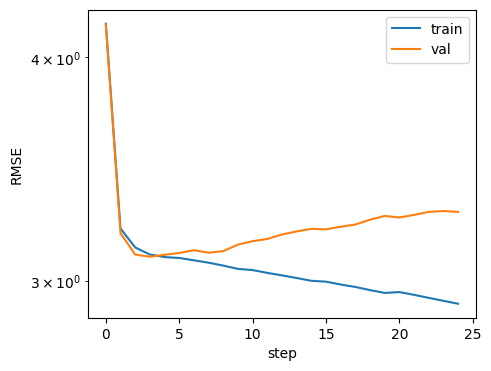

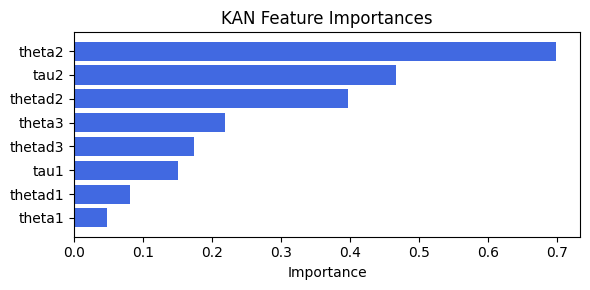

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:07<00:00, 12.90it/s]


[('tau2', 0.41075400143646806), ('thetad1', 0.34059608724664203), ('tau1', 0.3380355238691461), ('theta1', 0.28156754705167286), ('thetad2', 0.2802454185632354), ('theta2', 0.22219716218668814), ('theta3', 0.10257926934751259), ('Ex1', 0.07674303282018016), ('thetad3', 0.06036036028341739)]


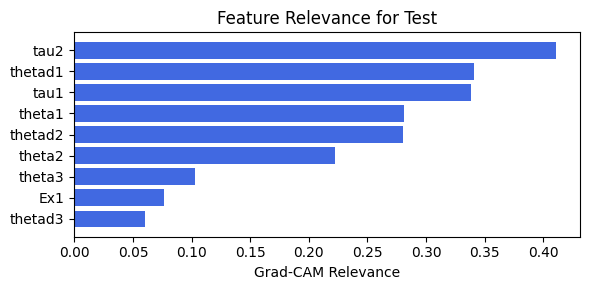

In [43]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.725, filename=filename_2, opt_col_val=0.725)

### 2.0.2e width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.65

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.31e+00 | reg: 4.10e+02 |: 100%|█| 25/25 [01:35<00:00,  3.81s/i

saving model version 0.1
Best epoch 2
3.225642204284668
M_KAN Relevance: 0.01741756685078144
CNN Relevance: 0.9825824499130249
[('theta2', 0.73558384), ('thetad2', 0.4617614), ('theta3', 0.28025016), ('tau2', 0.27584606), ('thetad3', 0.12567216), ('thetad1', 0.12349366), ('tau1', 0.07912631), ('theta1', 0.03764592)]


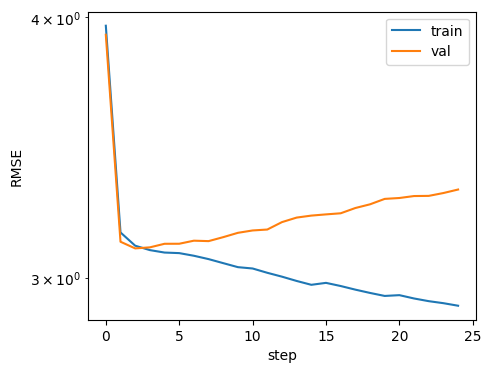

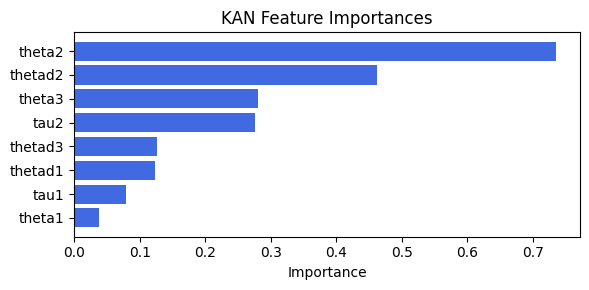

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.61it/s]

[('thetad1', 0.33294163473139254), ('tau2', 0.3026326573886495), ('theta1', 0.2847205505910569), ('thetad2', 0.27952593821422295), ('tau1', 0.26220545958139624), ('theta2', 0.22884260114058488), ('theta3', 0.05695280931880857), ('Ex1', 0.05503522208276305), ('thetad3', 0.048122566699409695)]


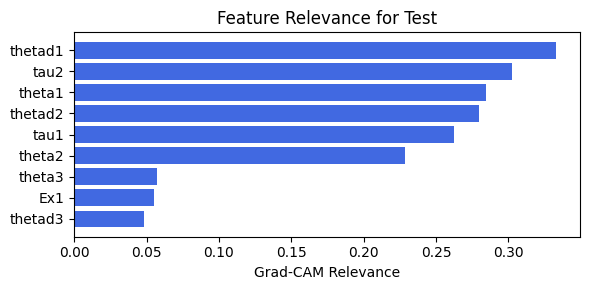

In [47]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.65, filename=filename_2, opt_col_val=0.65)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.86e+00 | eval_loss: 3.33e+00 | reg: 3.55e+02 |: 100%|█| 25/25 [01:34<00:00,  3.80s/i


saving model version 0.1
Best epoch 4
3.2271430492401123
M_KAN Relevance: 0.028896572068333626
CNN Relevance: 0.9711034297943115
[('theta2', 0.6512519), ('thetad2', 0.45093507), ('tau2', 0.2791534), ('theta3', 0.2603315), ('thetad3', 0.22641973), ('theta1', 0.18793827), ('thetad1', 0.15792917), ('tau1', 0.114323094)]


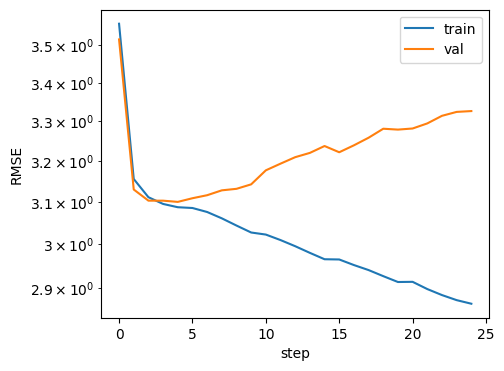

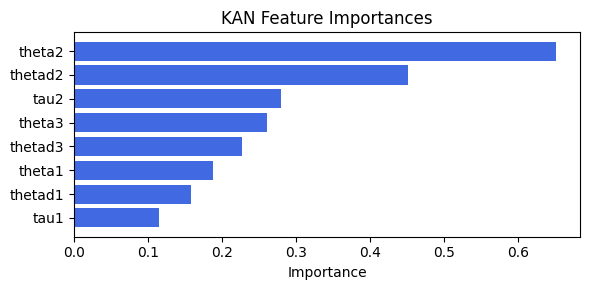

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.44it/s]

[('thetad1', 0.35624609142831326), ('tau2', 0.34047329662254644), ('tau1', 0.32374179645274664), ('thetad2', 0.31606665765658215), ('theta1', 0.31101175133480397), ('theta2', 0.2550791947994505), ('Ex1', 0.10635783660576388), ('theta3', 0.09969838448940285), ('thetad3', 0.0957118604351122)]


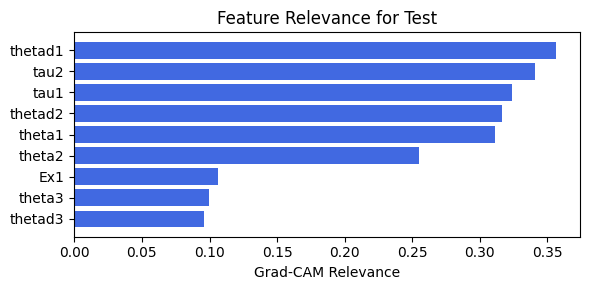

In [48]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.6, filename=filename_2, opt_col_val=0.6)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.87e+00 | eval_loss: 3.33e+00 | reg: 3.54e+02 |: 100%|█| 25/25 [01:32<00:00,  3.71s/i


saving model version 0.1
Best epoch 4
3.2217061519622803
M_KAN Relevance: 0.03161964192986488
CNN Relevance: 0.9683803915977478
[('theta2', 0.67517877), ('thetad2', 0.44343165), ('tau2', 0.2753752), ('theta3', 0.26373693), ('thetad3', 0.19221954), ('theta1', 0.16538307), ('thetad1', 0.16287759), ('tau1', 0.11091582)]


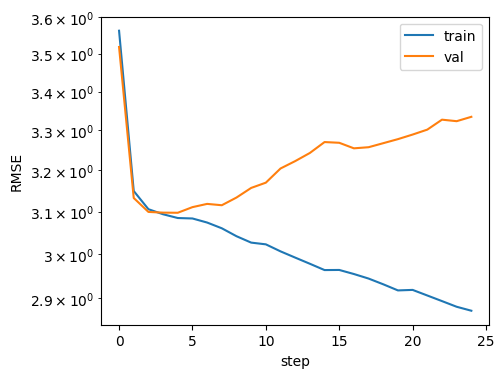

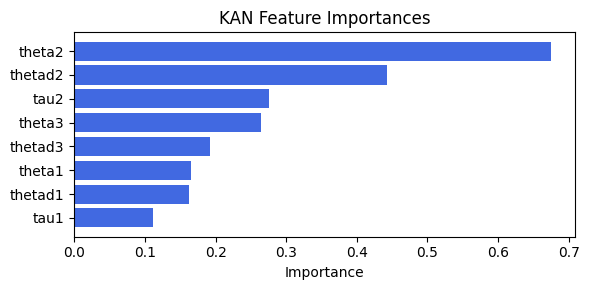

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.19it/s]


[('thetad1', 0.36593730501753724), ('tau2', 0.35773251896431774), ('tau1', 0.3306472265253369), ('theta1', 0.31927581510242237), ('thetad2', 0.30912205013572547), ('theta2', 0.25978278697535034), ('theta3', 0.10100417190150215), ('thetad3', 0.09373585881099636), ('Ex1', 0.08406576553630139)]


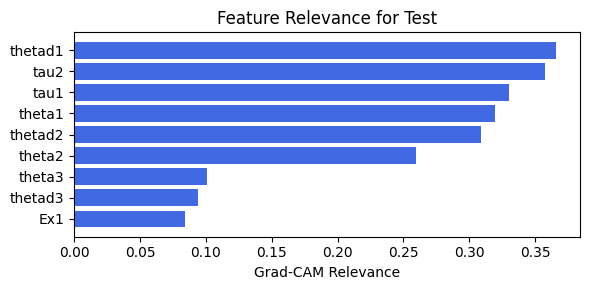

In [49]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.6, filename=filename_2, opt_col_val=0.6)

### 2.0.3. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.26e+00 | reg: 3.45e+02 |: 100%|█| 25/25 [01:49<00:00,  4.39s/i

saving model version 0.1
Best epoch 2
3.230064868927002
M_KAN Relevance: 0.026645714417099953
CNN Relevance: 0.9733542799949646
[('theta2', 0.6194294), ('thetad2', 0.486472), ('theta3', 0.41179228), ('tau2', 0.30028883), ('thetad1', 0.16196519), ('thetad3', 0.13828525), ('tau1', 0.10776651), ('theta1', 0.053829134)]


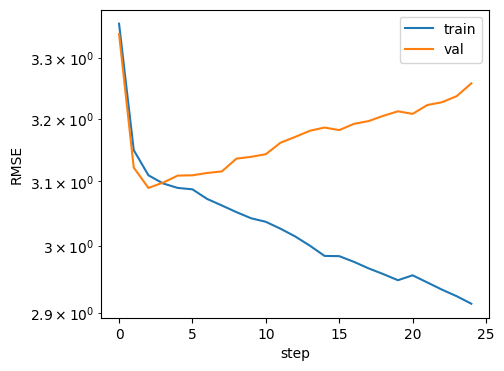

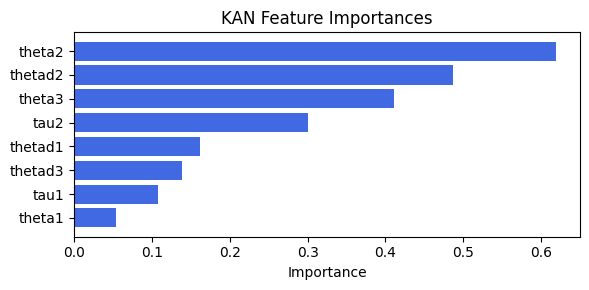

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.16it/s]

[('thetad2', 0.4535245426256145), ('thetad1', 0.43949790919552634), ('theta1', 0.40800665913515083), ('theta2', 0.33269379669173044), ('tau2', 0.3292939996299882), ('tau1', 0.3010204294754427), ('theta3', 0.15074126246588984), ('thetad3', 0.14167368163132127), ('Ex1', 0.14040523814654501)]


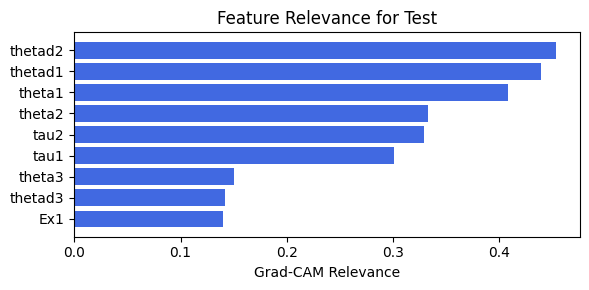

In [97]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.0.4. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.92e+00 | eval_loss: 3.26e+00 | reg: 3.32e+02 |: 100%|█| 25/25 [01:48<00:00,  4.33s/i

saving model version 0.1
Best epoch 2
3.227825164794922
M_KAN Relevance: 0.026475727558135986
CNN Relevance: 0.973524272441864
[('theta2', 0.6250147), ('thetad2', 0.47816056), ('theta3', 0.4112355), ('tau2', 0.3009338), ('thetad1', 0.16267037), ('thetad3', 0.1400964), ('tau1', 0.10615419), ('theta1', 0.0543669)]


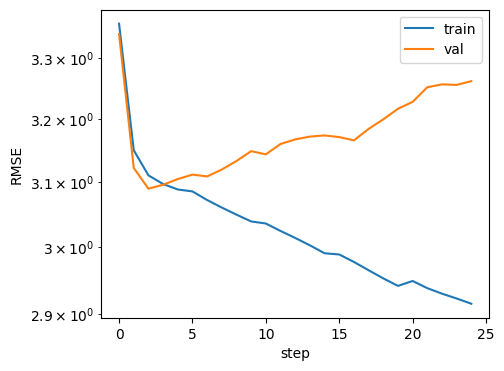

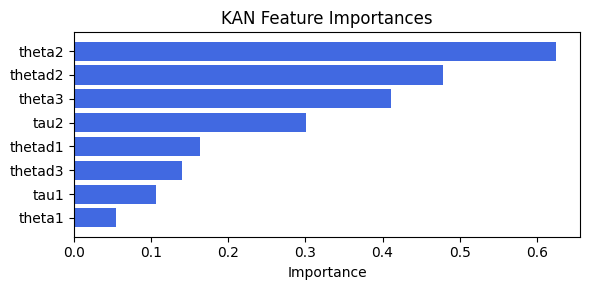

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:05<00:00, 13.03it/s]

[('thetad2', 0.4480817939528353), ('thetad1', 0.43656014923364733), ('theta1', 0.40462538541731885), ('theta2', 0.3324160718017336), ('tau2', 0.3209079522359939), ('tau1', 0.29414259081290817), ('theta3', 0.14493552922491415), ('Ex1', 0.1382480126219194), ('thetad3', 0.131415088526538)]


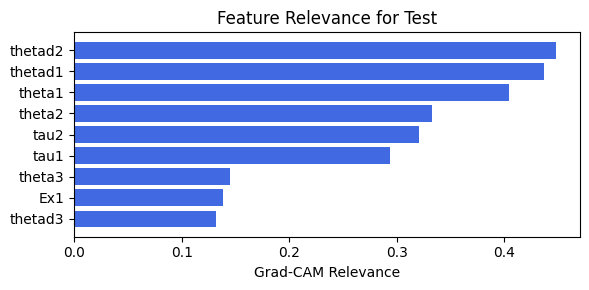

In [98]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.0.5. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.94e+00 | eval_loss: 3.23e+00 | reg: 3.51e+02 |: 100%|█| 25/25 [01:49<00:00,  4.38s/i

saving model version 0.1
Best epoch 6
3.2435073852539062
M_KAN Relevance: 0.043471042066812515
CNN Relevance: 0.9565289616584778
[('theta2', 0.70297396), ('thetad2', 0.4680792), ('theta3', 0.28156292), ('tau2', 0.27275875), ('thetad3', 0.17172281), ('thetad1', 0.14654899), ('tau1', 0.1131722), ('theta1', 0.092603356)]


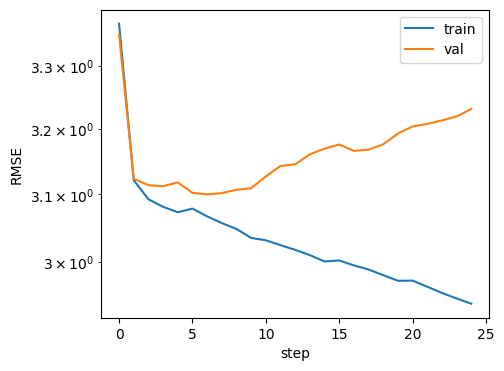

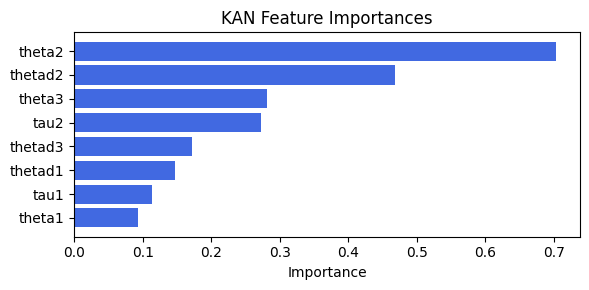

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:03<00:00, 13.31it/s]

[('tau1', 0.3764345117907075), ('tau2', 0.37617692766682564), ('thetad1', 0.25075276017629683), ('theta1', 0.24974626401297464), ('theta2', 0.16665416280637682), ('Ex1', 0.16351280082885142), ('thetad2', 0.14462627394128724), ('theta3', 0.14301900080383897), ('thetad3', 0.13232973761332154)]


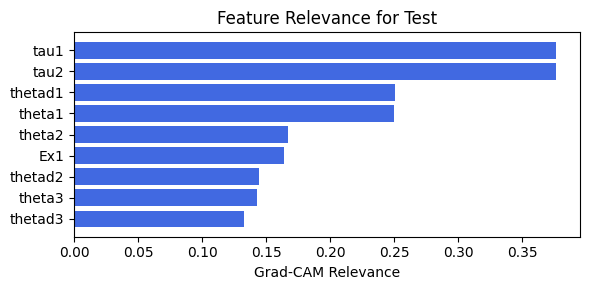

In [99]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.0.6. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.94e+00 | eval_loss: 3.23e+00 | reg: 3.45e+02 |: 100%|█| 25/25 [01:50<00:00,  4.40s/i

saving model version 0.1
Best epoch 6
3.2431914806365967
M_KAN Relevance: 0.04087759926915169
CNN Relevance: 0.9591224193572998
[('theta2', 0.6586545), ('thetad2', 0.48334587), ('theta3', 0.3591432), ('tau2', 0.28155375), ('thetad3', 0.18903777), ('tau1', 0.12553564), ('thetad1', 0.11448036), ('theta1', 0.10998635)]


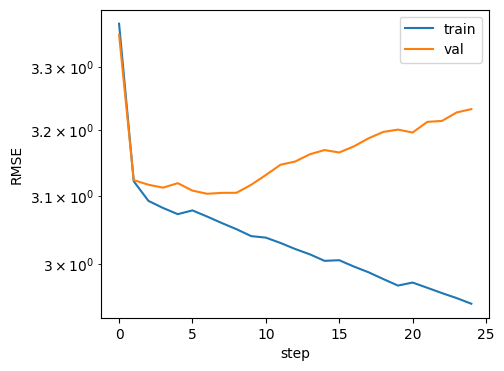

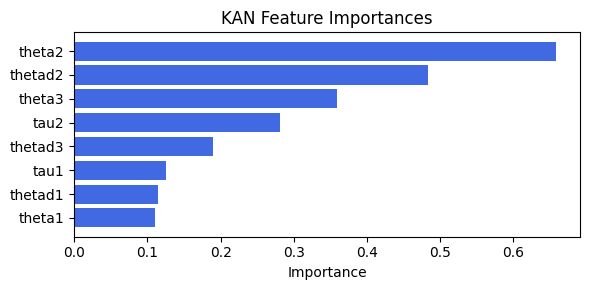

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.19it/s]

[('tau1', 0.3618430751150606), ('tau2', 0.35747772716161746), ('thetad1', 0.22818507820162115), ('theta1', 0.22677167634497955), ('Ex1', 0.15487968936948435), ('theta2', 0.13751856076444174), ('theta3', 0.13286223185391777), ('thetad2', 0.12470152230214662), ('thetad3', 0.10977000196351842)]


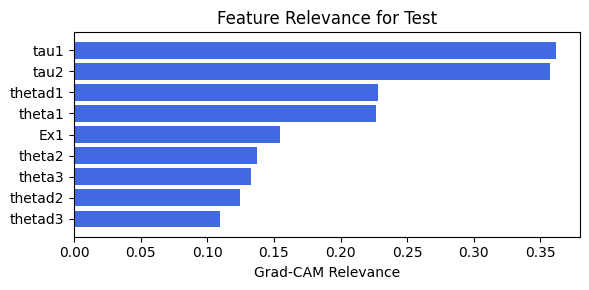

In [100]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.0.7. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.00e+00 | eval_loss: 3.18e+00 | reg: 2.81e+02 |: 100%|█| 25/25 [01:52<00:00,  4.50s/i

saving model version 0.1
Best epoch 4
3.234651803970337
M_KAN Relevance: 0.07564137130975723
CNN Relevance: 0.9243586659431458
[('theta2', 0.48802486), ('theta3', 0.46409452), ('thetad2', 0.32751086), ('tau2', 0.2753645), ('thetad1', 0.14217016), ('thetad3', 0.12907678), ('tau1', 0.087975726), ('theta1', 0.059383854)]


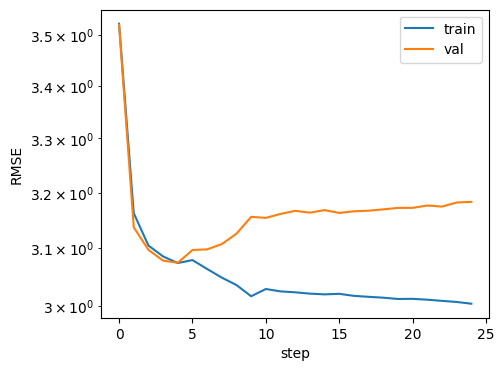

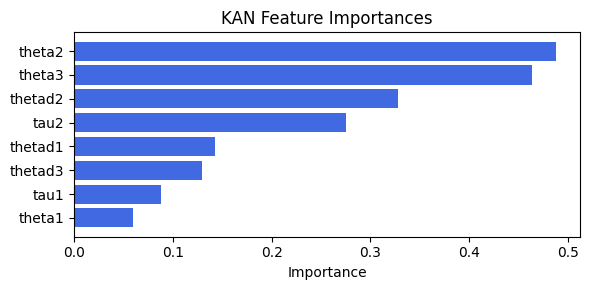

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:03<00:00, 13.27it/s]


[('tau1', 0.33223500093569125), ('tau2', 0.32257373389342836), ('thetad1', 0.29353187115481155), ('theta1', 0.29092848300351404), ('theta2', 0.2395112569436452), ('theta3', 0.2320349195251432), ('thetad2', 0.22287525108567502), ('Ex1', 0.21462941846118272), ('thetad3', 0.21094854574269745)]


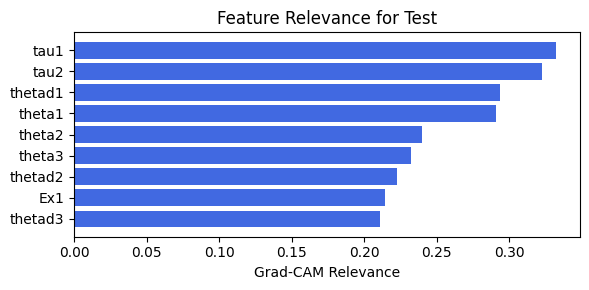

In [101]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.0.8. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.28e+00 | reg: 5.64e+02 |: 100%|█| 25/25 [01:46<00:00,  4.28s/i

saving model version 0.1
Best epoch 3
3.237623929977417
M_KAN Relevance: 0.08125294744968414
CNN Relevance: 0.918747067451477
[('theta2', 0.50090384), ('theta3', 0.44406232), ('thetad2', 0.3070457), ('tau2', 0.2739116), ('thetad1', 0.13846956), ('thetad3', 0.12864658), ('tau1', 0.093279816), ('theta1', 0.06147141)]


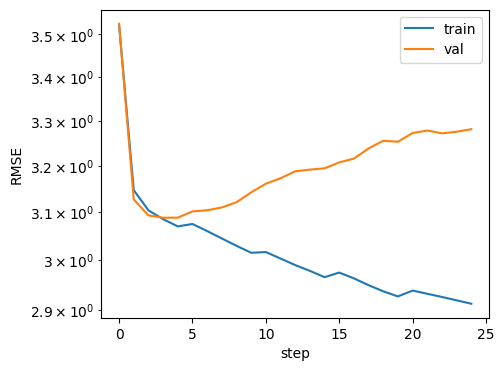

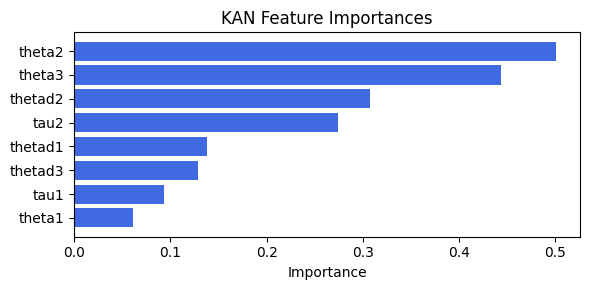

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.17it/s]

[('tau2', 0.29386826497659896), ('thetad3', 0.2841495921167247), ('tau1', 0.28053543934913183), ('thetad2', 0.28011257782103793), ('thetad1', 0.2744344862157565), ('Ex1', 0.27360772946622175), ('theta1', 0.2541399053335937), ('theta2', 0.2415608007919604), ('theta3', 0.23914144847397611)]


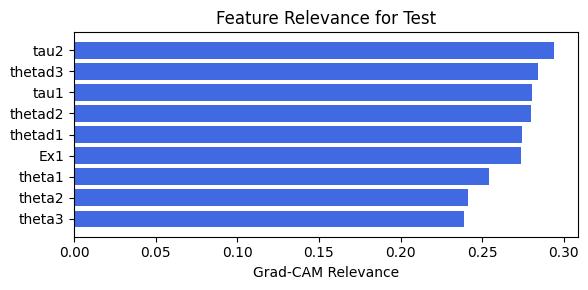

In [102]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.1.1. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.83e+00 | eval_loss: 3.36e+00 | reg: 3.17e+02 |: 100%|█| 25/25 [03:47<00:00,  9.09s/i

saving model version 0.1
Best epoch 8
3.239015579223633
M_KAN Relevance: 0.007248145993798971
CNN Relevance: 0.9927518367767334
[('thetad2', 0.57200956), ('theta2', 0.35534978), ('thetad1', 0.30725634), ('tau1', 0.30334032), ('thetad3', 0.27418357), ('theta3', 0.23557913), ('tau2', 0.21018879), ('theta1', 0.18781428)]


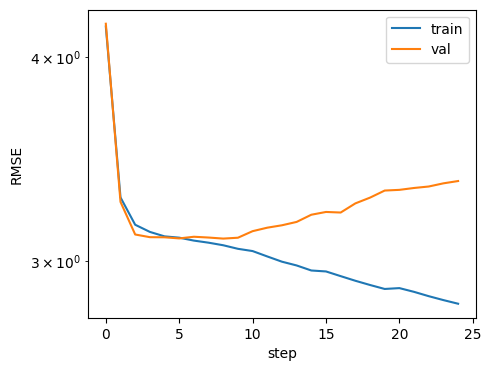

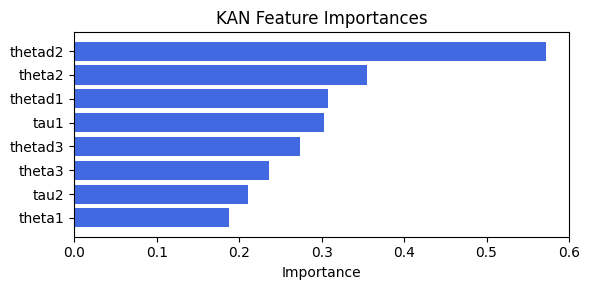

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:16<00:00, 11.98it/s]

[('theta1', 0.40455561981333593), ('thetad1', 0.36086956000686216), ('thetad2', 0.30596786033234086), ('tau1', 0.3054914252065853), ('theta2', 0.2626517465245317), ('tau2', 0.24342294409682877), ('theta3', 0.18747411988584375), ('thetad3', 0.11625839351640704), ('Ex1', 0.09879736643955009)]


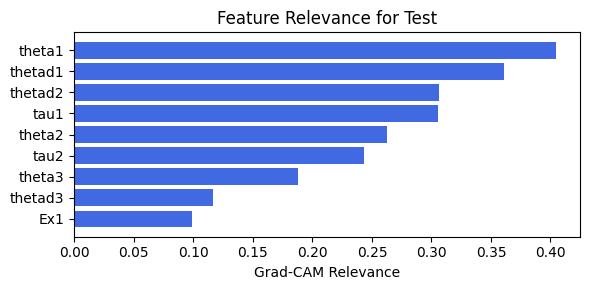

In [103]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.1.2. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.81e+00 | eval_loss: 3.32e+00 | reg: 3.14e+02 |: 100%|█| 25/25 [01:50<00:00,  4.42s/i

saving model version 0.1
Best epoch 8
3.2440621852874756
M_KAN Relevance: 0.006934215780347586
CNN Relevance: 0.9930657744407654
[('thetad2', 0.54427576), ('theta2', 0.35670134), ('tau1', 0.31870908), ('thetad1', 0.27870733), ('thetad3', 0.26444694), ('tau2', 0.24788098), ('theta3', 0.24644539), ('theta1', 0.22662842)]


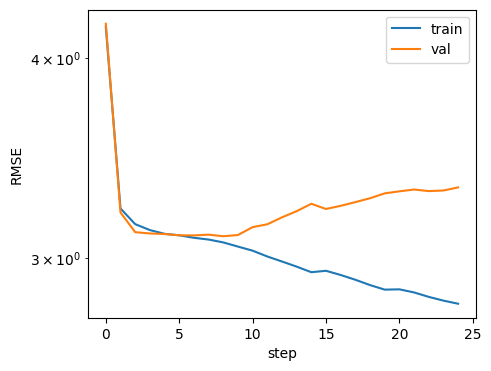

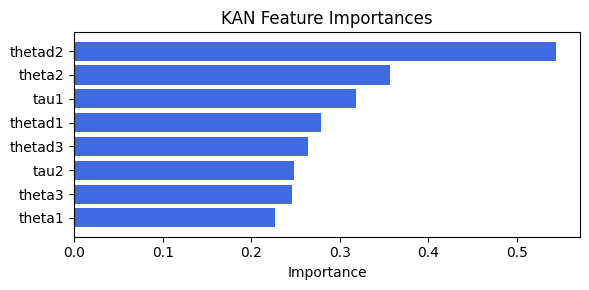

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:38<00:00, 10.35it/s]

[('theta1', 0.39214155001252154), ('thetad1', 0.3337935684441447), ('tau1', 0.29923549549437456), ('thetad2', 0.27750502256164616), ('theta2', 0.2572491214044683), ('theta3', 0.23958141513769973), ('tau2', 0.22901621197669667), ('thetad3', 0.17307294664506434), ('Ex1', 0.08850963220356456)]


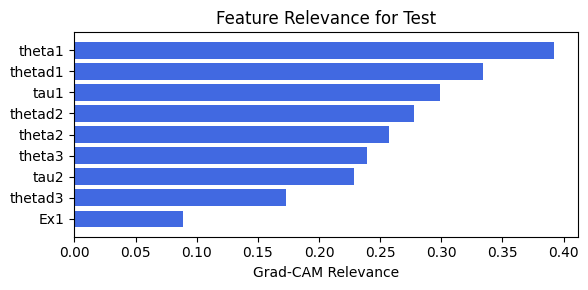

In [104]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.1.3. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.84e+00 | eval_loss: 3.29e+00 | reg: 3.22e+02 |: 100%|█| 25/25 [01:53<00:00,  4.55s/i

saving model version 0.1
Best epoch 7
3.2514939308166504
M_KAN Relevance: 0.0149410804733634
CNN Relevance: 0.9850589036941528
[('thetad2', 0.6347921), ('theta2', 0.34038186), ('thetad1', 0.3076474), ('theta3', 0.26856422), ('tau1', 0.2555501), ('thetad3', 0.21919124), ('tau2', 0.14813326), ('theta1', 0.09366202)]


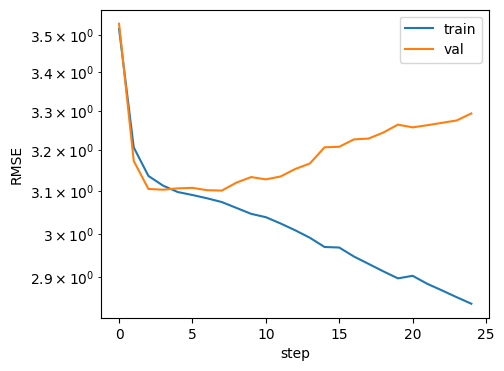

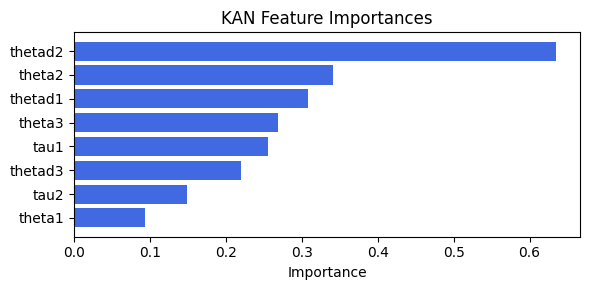

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:15<00:00, 12.08it/s]


[('theta1', 0.3454531919031057), ('thetad2', 0.28081134878503033), ('thetad1', 0.2751817639623327), ('theta2', 0.2746200589197469), ('Ex1', 0.22906091647326482), ('theta3', 0.2281786298776288), ('tau1', 0.22167448809880666), ('tau2', 0.1492941978744203), ('thetad3', 0.11092365090666129)]


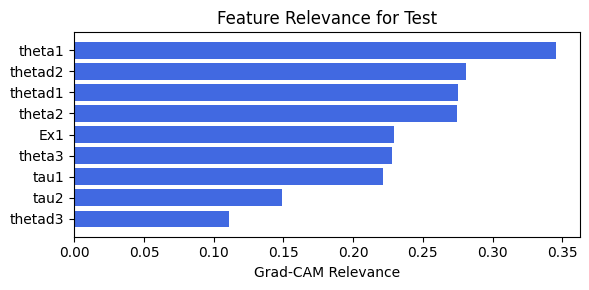

In [105]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.1.4. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.88e+00 | eval_loss: 3.28e+00 | reg: 3.03e+02 |: 100%|█| 25/25 [01:59<00:00,  4.76s/i

saving model version 0.1
Best epoch 6
3.257786273956299
M_KAN Relevance: 0.009955999441444874
CNN Relevance: 0.9900440573692322
[('thetad2', 0.58169365), ('theta2', 0.34494776), ('thetad1', 0.31905347), ('theta3', 0.31452858), ('thetad3', 0.2517271), ('tau1', 0.24500188), ('tau2', 0.15943962), ('theta1', 0.13292557)]


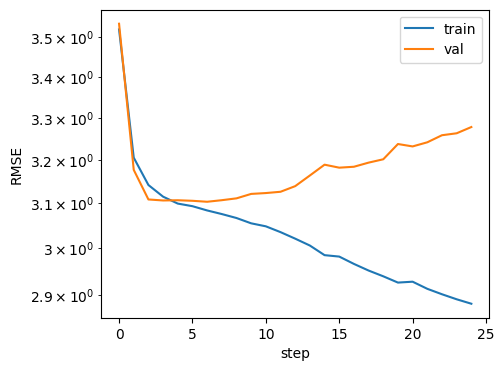

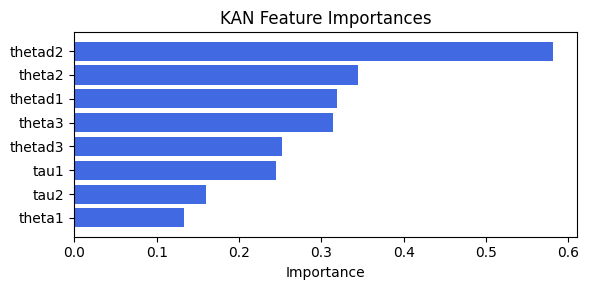

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.31it/s]

[('theta1', 0.3837397213637409), ('thetad1', 0.3250420459612933), ('theta2', 0.3056322062754604), ('thetad2', 0.29910579931759884), ('tau1', 0.2924071224336421), ('theta3', 0.25014166722774295), ('tau2', 0.20898338754133924), ('Ex1', 0.18610390852013078), ('thetad3', 0.11534173190294868)]


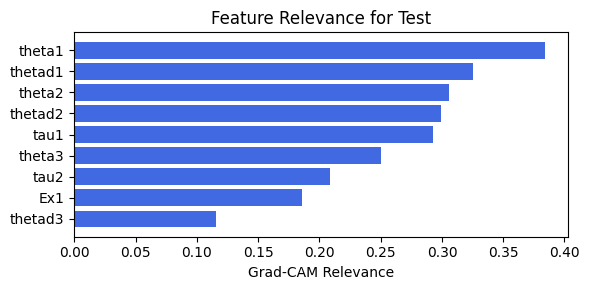

In [106]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.1.5. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.85e+00 | eval_loss: 3.31e+00 | reg: 3.79e+02 |: 100%|█| 25/25 [03:29<00:00,  8.40s/i

saving model version 0.1
Best epoch 5
3.240649938583374
M_KAN Relevance: 0.015287300571799278
CNN Relevance: 0.9847126603126526
[('theta3', 0.52693415), ('thetad2', 0.46138555), ('thetad1', 0.28664574), ('tau2', 0.260655), ('theta2', 0.24914084), ('tau1', 0.22817324), ('theta1', 0.13824616), ('thetad3', 0.10596034)]


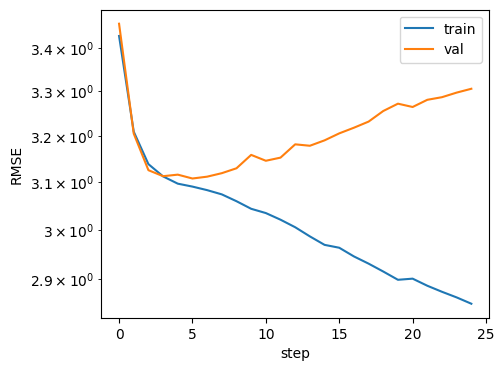

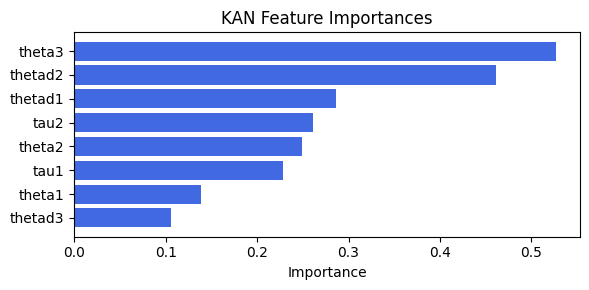

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.31it/s]

[('thetad1', 0.39995540561957954), ('tau2', 0.38907873609155497), ('tau1', 0.375634374257478), ('theta1', 0.3734214699779119), ('thetad2', 0.2839977962082262), ('theta2', 0.2601065788645487), ('thetad3', 0.15687311197580062), ('theta3', 0.15681922959173686), ('Ex1', 0.09961706706210115)]


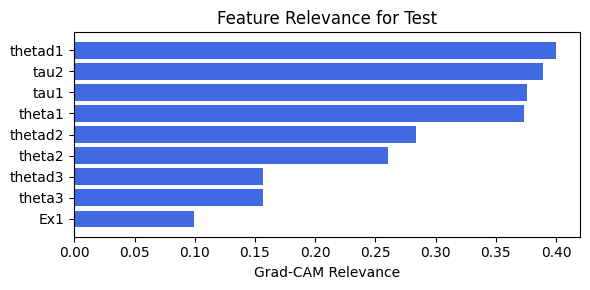

In [107]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.1.6. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.87e+00 | eval_loss: 3.27e+00 | reg: 3.68e+02 |: 100%|█| 25/25 [03:30<00:00,  8.41s/i


saving model version 0.1
Best epoch 5
3.2426304817199707
M_KAN Relevance: 0.015973199158906937
CNN Relevance: 0.9840268492698669
[('theta3', 0.52081716), ('thetad2', 0.47077116), ('thetad1', 0.28656963), ('tau2', 0.25236663), ('theta2', 0.22820908), ('tau1', 0.22394282), ('theta1', 0.14096457), ('thetad3', 0.11198355)]


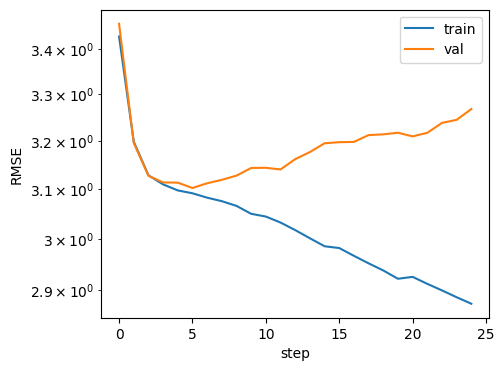

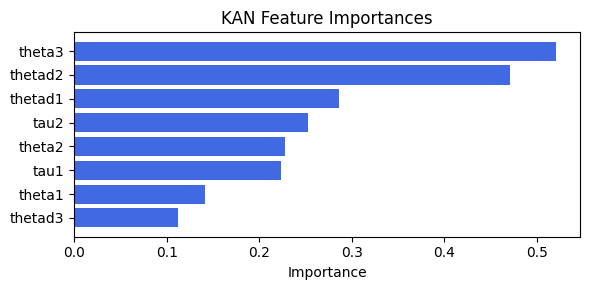

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.25it/s]

[('thetad1', 0.41731715938653124), ('tau2', 0.4040456706443287), ('tau1', 0.39521870422127653), ('theta1', 0.39452430860586835), ('thetad2', 0.28944609042885955), ('theta2', 0.2738918013073921), ('theta3', 0.17170581408669613), ('thetad3', 0.14750009737825737), ('Ex1', 0.10169988950990094)]


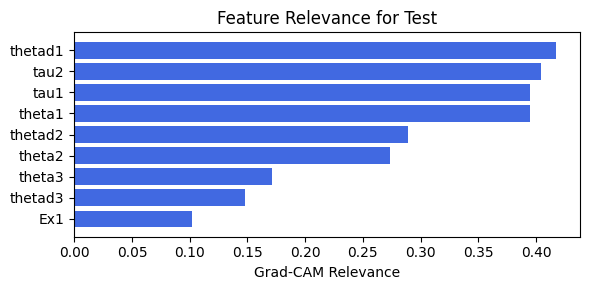

In [108]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.1.7. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.82e+00 | eval_loss: 3.39e+00 | reg: 3.46e+02 |: 100%|█| 25/25 [01:58<00:00,  4.73s/i

saving model version 0.1
Best epoch 3
3.2278313636779785
M_KAN Relevance: 0.007292215246707201
CNN Relevance: 0.9927077889442444
[('theta2', 0.685734), ('theta3', 0.51375526), ('thetad2', 0.35379928), ('tau2', 0.18865627), ('thetad3', 0.15781395), ('theta1', 0.13097325), ('thetad1', 0.095811605), ('tau1', 0.04143474)]


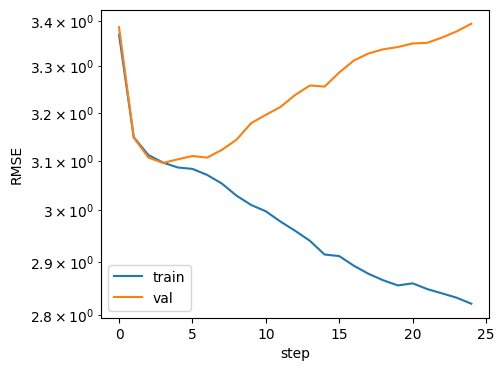

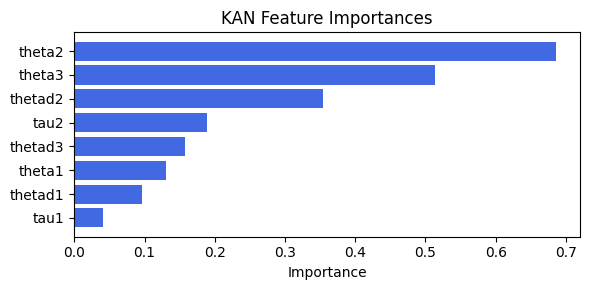

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.34it/s]

[('Ex1', 0.43862922961537115), ('tau1', 0.4176380355652538), ('tau2', 0.37962286066229606), ('theta1', 0.37517623662894056), ('thetad1', 0.3727074173629844), ('thetad2', 0.340777081599673), ('theta2', 0.2876143512578356), ('theta3', 0.22229882039010335), ('thetad3', 0.141472387627049)]


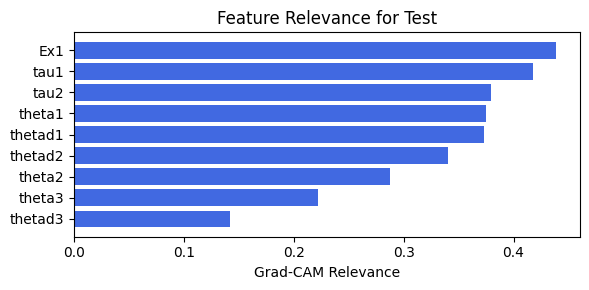

In [109]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.1.8. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.79e+00 | eval_loss: 3.42e+00 | reg: 3.72e+02 |: 100%|█| 25/25 [01:59<00:00,  4.78s/i

saving model version 0.1
Best epoch 4
3.230664014816284
M_KAN Relevance: 0.008922073990106583
CNN Relevance: 0.9910779595375061
[('theta2', 0.67333716), ('theta3', 0.49317038), ('thetad2', 0.3845621), ('thetad3', 0.18028927), ('tau2', 0.17795102), ('theta1', 0.1265957), ('thetad1', 0.109087944), ('tau1', 0.055369716)]


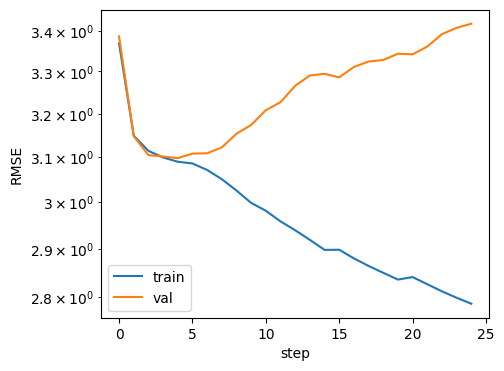

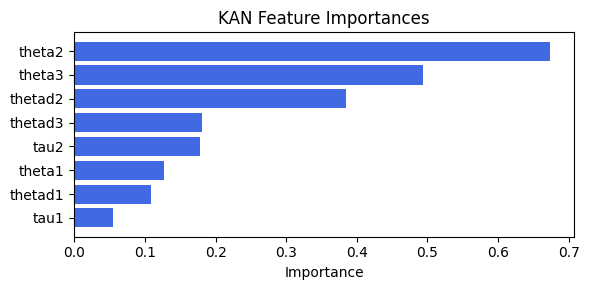

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:11<00:00, 12.46it/s]

[('Ex1', 0.44958066179928763), ('tau1', 0.4244197666250275), ('tau2', 0.3868241329656485), ('theta1', 0.3719400819886523), ('thetad1', 0.37146209658896445), ('thetad2', 0.3265861186901342), ('theta2', 0.2949908877253742), ('theta3', 0.2304042485573839), ('thetad3', 0.1591193428368956)]


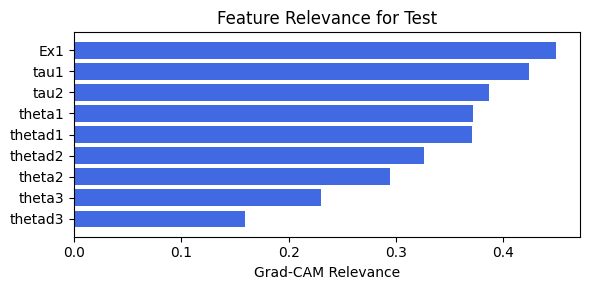

In [110]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.2.0 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.08e+01 |: 100%|█| 25/25 [01:30<00:00,  3.63s/i

saving model version 0.1
Best epoch 13
3.2272720336914062
M_KAN Relevance: 0.19425958395004272
CNN Relevance: 0.8057404160499573
[('theta2', 0.4313428), ('tau2', 0.30888534), ('theta1', 0.30055153), ('thetad2', 0.25684184), ('theta3', 0.20753604), ('thetad3', 0.18316248), ('tau1', 0.15173542), ('thetad1', 0.14196053)]


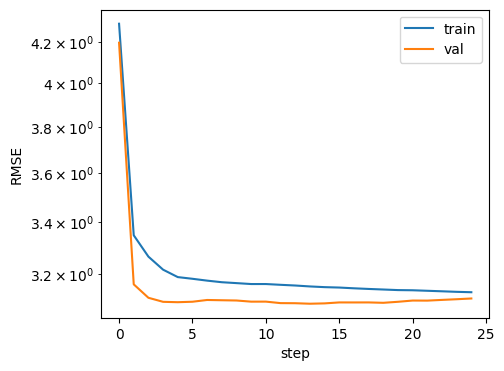

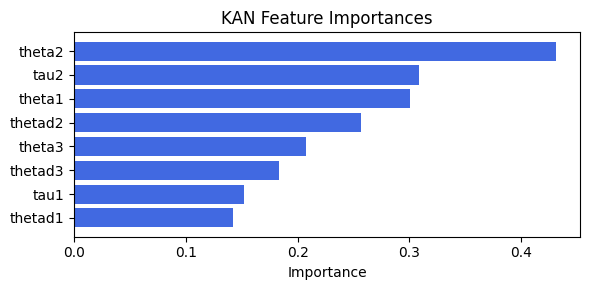

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:14<00:00, 12.17it/s]

[('tau1', 0.3832703952426126), ('tau2', 0.3586009667489191), ('thetad1', 0.3273718048929089), ('theta1', 0.3210252123563134), ('thetad2', 0.21599665933454557), ('theta2', 0.2133534609073471), ('Ex1', 0.15789774399089654), ('theta3', 0.1407738235779142), ('thetad3', 0.13936977704183182)]


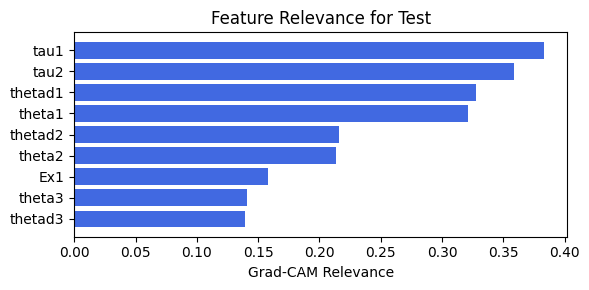

In [111]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.2.1 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.26e+01 |: 100%|█| 25/25 [01:28<00:00,  3.54s/i

saving model version 0.1
Best epoch 11
3.2292561531066895
M_KAN Relevance: 0.1798151135444641
CNN Relevance: 0.8201849460601807
[('theta2', 0.37455052), ('tau1', 0.34980485), ('theta1', 0.2914654), ('tau2', 0.27357802), ('theta3', 0.2436842), ('thetad2', 0.24356675), ('thetad3', 0.20377162), ('thetad1', 0.08224998)]


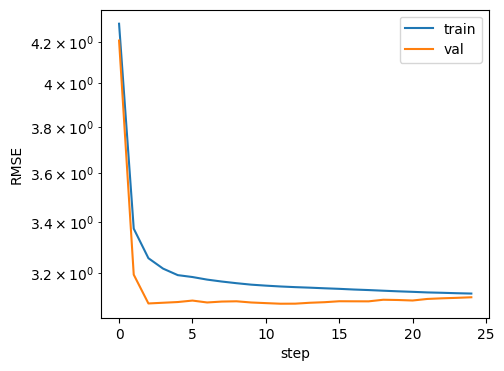

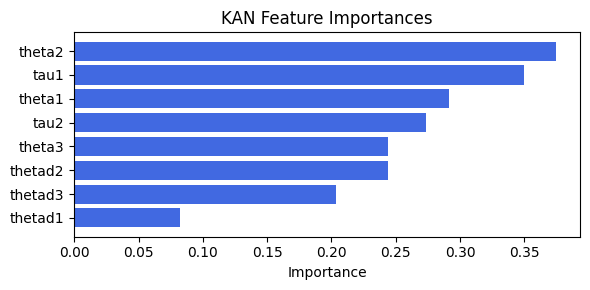

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.85it/s]

[('tau1', 0.3889554734079795), ('thetad1', 0.3610787703745156), ('theta1', 0.35752567876071534), ('tau2', 0.32824805418968606), ('thetad2', 0.25630214350664055), ('theta2', 0.2398760748300119), ('thetad3', 0.1740687804736917), ('theta3', 0.17262238558374374), ('Ex1', 0.07526329180270017)]


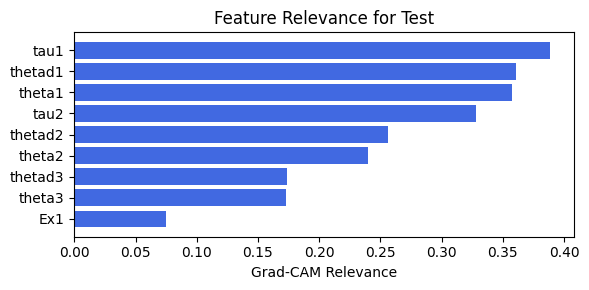

In [112]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.2.2 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.12e+00 | reg: 4.81e+01 |: 100%|█| 25/25 [01:31<00:00,  3.64s/i

saving model version 0.1
Best epoch 4
3.2285125255584717
M_KAN Relevance: 0.1439754068851471
CNN Relevance: 0.8560245633125305
[('theta2', 0.6033399), ('tau1', 0.249466), ('theta3', 0.24719688), ('thetad2', 0.2269239), ('thetad3', 0.18791553), ('thetad1', 0.166529), ('tau2', 0.097448274), ('theta1', 0.066283636)]


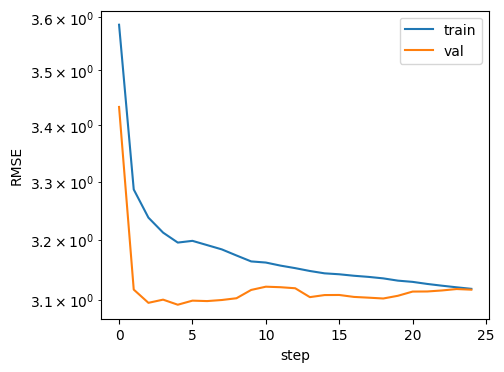

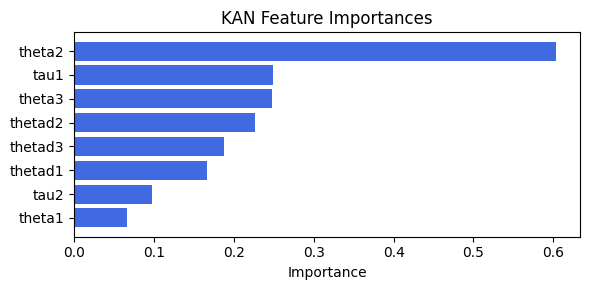

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:24<00:00, 11.32it/s]


[('tau1', 0.38426385009202474), ('tau2', 0.36293768613157035), ('theta1', 0.34915960717947997), ('thetad1', 0.342960862444023), ('theta2', 0.2658093791517926), ('thetad2', 0.2450227407775492), ('theta3', 0.21488197796801933), ('thetad3', 0.18727649377484126), ('Ex1', 0.14469307113909832)]


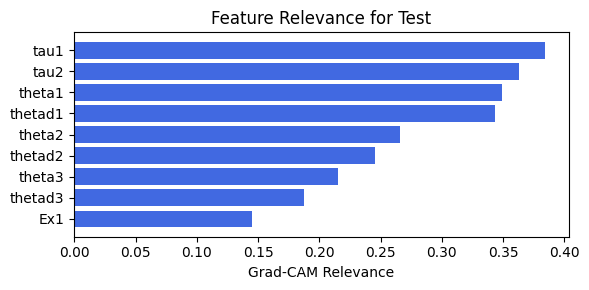

In [113]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.2.3 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.12e+00 | reg: 4.43e+01 |: 100%|█| 25/25 [01:31<00:00,  3.65s/i

saving model version 0.1
Best epoch 4
3.2260615825653076
M_KAN Relevance: 0.1433311402797699
CNN Relevance: 0.8566688299179077
[('theta2', 0.62863237), ('tau2', 0.26665688), ('thetad2', 0.24357834), ('thetad3', 0.22991529), ('tau1', 0.22255716), ('theta3', 0.1718848), ('thetad1', 0.1593746), ('theta1', 0.11775489)]


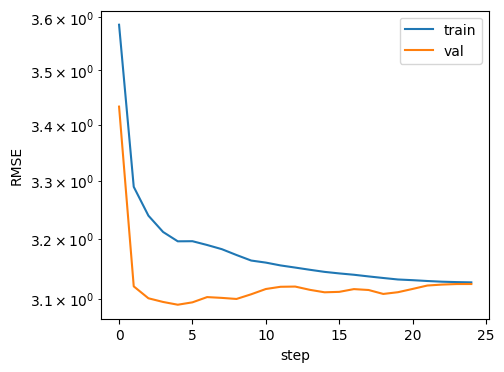

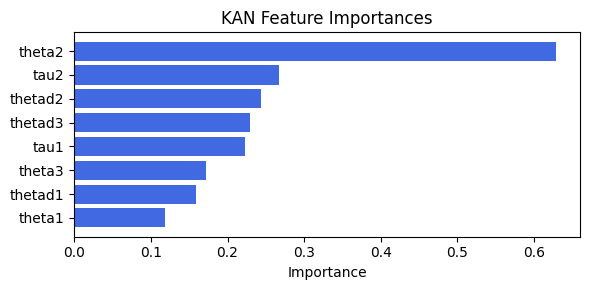

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.86it/s]


[('tau1', 0.3786305066414498), ('tau2', 0.357991691310836), ('theta1', 0.33812128866512997), ('thetad1', 0.33354477543281946), ('theta2', 0.25245774592401554), ('thetad2', 0.2396680184562432), ('theta3', 0.22202063428403646), ('thetad3', 0.19915561117506014), ('Ex1', 0.14385111315172766)]


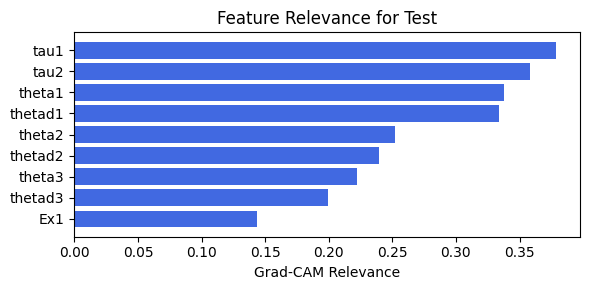

In [114]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.2.4. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.17e+01 |: 100%|█| 30/30 [01:45<00:00,  3.50s/i

saving model version 0.1
Best epoch 4
3.23386812210083
M_KAN Relevance: 0.17032037675380707
CNN Relevance: 0.8296796083450317
[('theta2', 0.7404524), ('theta3', 0.38729423), ('thetad2', 0.14263076), ('theta1', 0.09801082), ('thetad3', 0.0850772), ('tau1', 0.08065701), ('thetad1', 0.057849653), ('tau2', 0.048229158)]


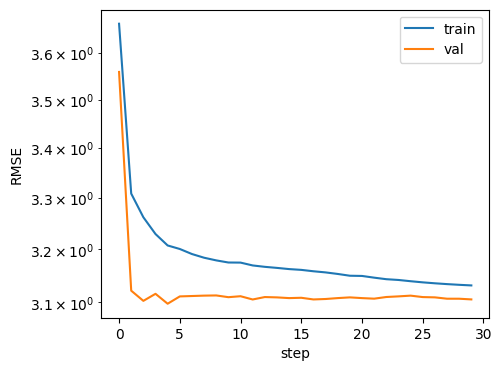

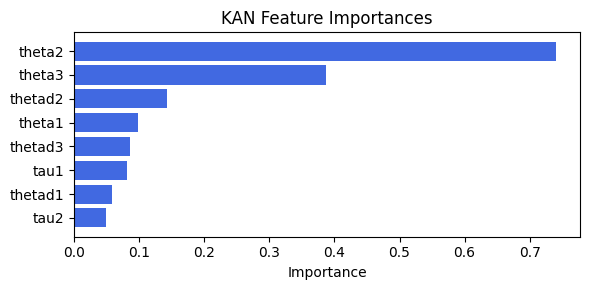

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:23<00:00, 11.40it/s]


[('tau1', 0.3952549328444249), ('theta1', 0.37442527539574083), ('tau2', 0.3677825137623444), ('thetad1', 0.3584487164009373), ('theta2', 0.2686510264633323), ('thetad2', 0.26265759809381134), ('theta3', 0.2364506671984201), ('Ex1', 0.21426305792365488), ('thetad3', 0.1876045535970149)]


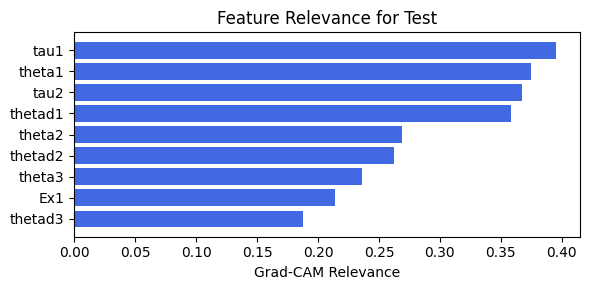

In [115]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=30, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.2.5. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.11e+00 | reg: 4.50e+01 |: 100%|█| 30/30 [01:44<00:00,  3.49s/i

saving model version 0.1
Best epoch 4
3.2385170459747314
M_KAN Relevance: 0.15520323812961578
CNN Relevance: 0.8447967767715454
[('theta2', 0.7344291), ('theta3', 0.38671824), ('thetad1', 0.13058195), ('tau2', 0.10660827), ('thetad3', 0.081131816), ('thetad2', 0.078607365), ('theta1', 0.076664515), ('tau1', 0.053437136)]


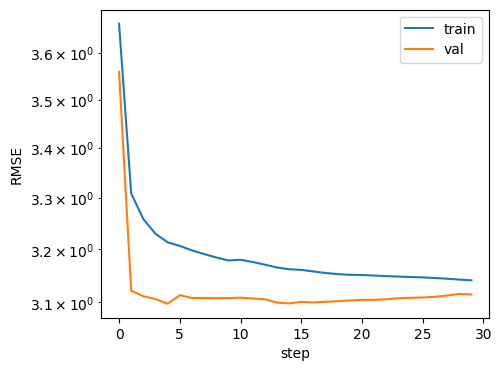

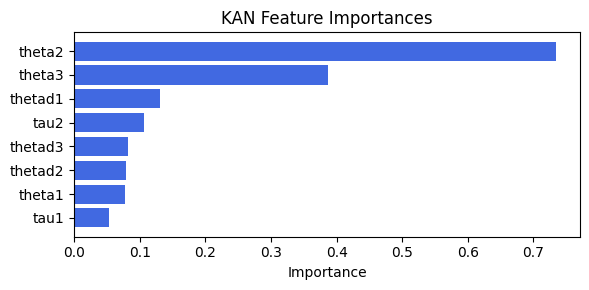

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.55it/s]

[('tau1', 0.3963198165370628), ('theta1', 0.38253828570053644), ('thetad1', 0.362358211455464), ('tau2', 0.3606505898648391), ('theta2', 0.2758128823291354), ('thetad2', 0.25576553887277365), ('theta3', 0.2288645697760656), ('Ex1', 0.19461141908720136), ('thetad3', 0.18985924805077903)]


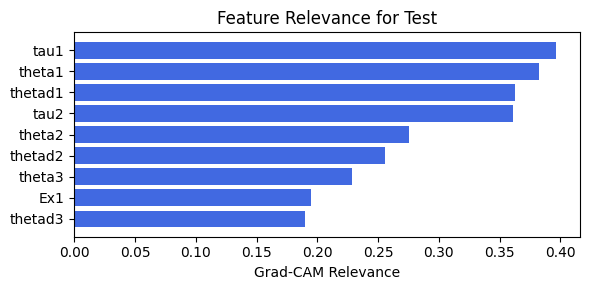

In [116]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=30, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.2.6. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.11e+00 | reg: 3.18e+01 |: 100%|█| 25/25 [01:29<00:00,  3.59s/i

saving model version 0.1
Best epoch 7
3.2407612800598145
M_KAN Relevance: 0.8009408712387085
CNN Relevance: 0.19905906915664673
[('theta2', 0.5027044), ('theta3', 0.48227513), ('thetad1', 0.19076204), ('tau2', 0.15953152), ('thetad2', 0.10418168), ('tau1', 0.07620709), ('thetad3', 0.075268), ('theta1', 0.0628665)]


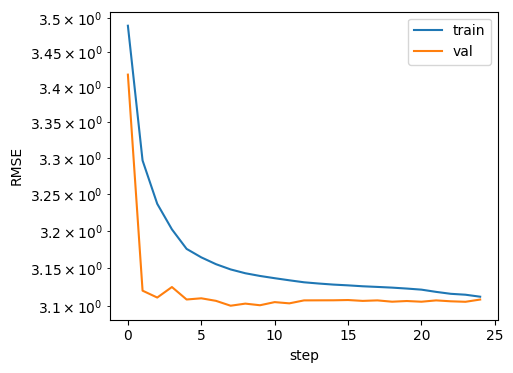

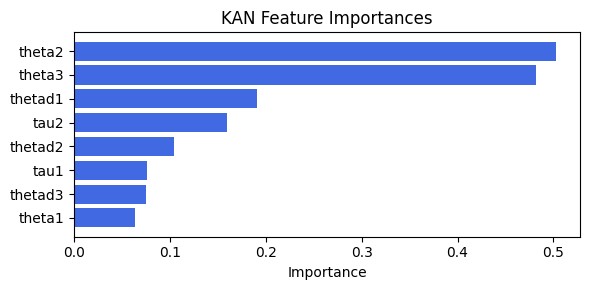

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:22<00:00, 11.49it/s]

[('theta1', 0.27949877256173683), ('thetad1', 0.27035585151298586), ('thetad2', 0.2580355886132939), ('theta2', 0.24121715312012973), ('tau1', 0.23494759509712115), ('tau2', 0.23211277472579683), ('theta3', 0.17373610051380625), ('thetad3', 0.16339169059047767), ('Ex1', 0.14490237472907885)]


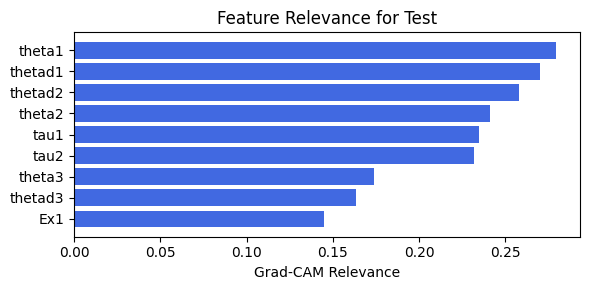

In [117]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.2.7. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 3.00e+01 |: 100%|█| 25/25 [01:30<00:00,  3.63s/i

saving model version 0.1
Best epoch 12
3.2445900440216064
M_KAN Relevance: 0.8488758206367493
CNN Relevance: 0.15112417936325073
[('theta2', 0.6190947), ('theta3', 0.4625332), ('thetad1', 0.17379847), ('thetad2', 0.15766573), ('thetad3', 0.14160515), ('tau1', 0.11765233), ('theta1', 0.0982526), ('tau2', 0.030524746)]


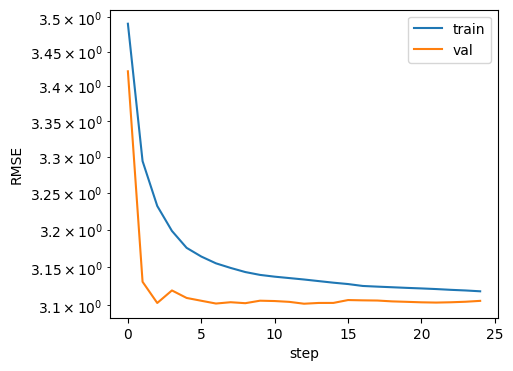

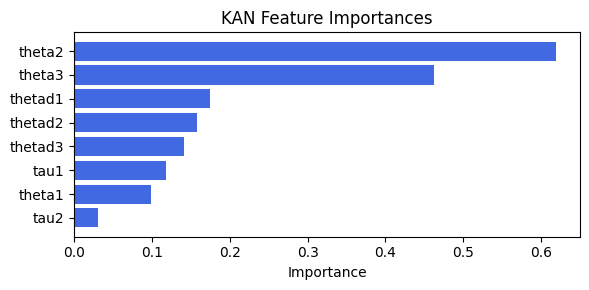

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:30<00:00, 10.87it/s]

[('thetad3', 0.221409565878838), ('theta1', 0.21374720191742708), ('thetad1', 0.2081549035550232), ('tau1', 0.19899355708845004), ('tau2', 0.19603670855122945), ('theta2', 0.19191711770799064), ('thetad2', 0.18509403581799846), ('theta3', 0.17122286582011192), ('Ex1', 0.1603797293799249)]


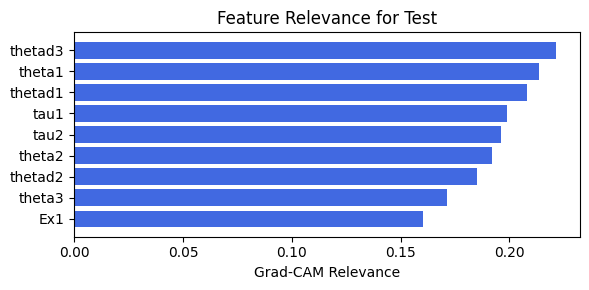

In [118]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.3.1. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.15e+00 | reg: 6.77e+01 |: 100%|█| 25/25 [01:59<00:00,  4.78s/i

saving model version 0.1
Best epoch 8
3.2297446727752686
M_KAN Relevance: 0.004839085973799229
CNN Relevance: 0.9951609373092651
[('tau2', 0.55165255), ('thetad2', 0.5053901), ('theta1', 0.23416726), ('theta3', 0.22944924), ('thetad1', 0.18867329), ('tau1', 0.11860256), ('theta2', 0.07923144), ('thetad3', 0.07175192)]


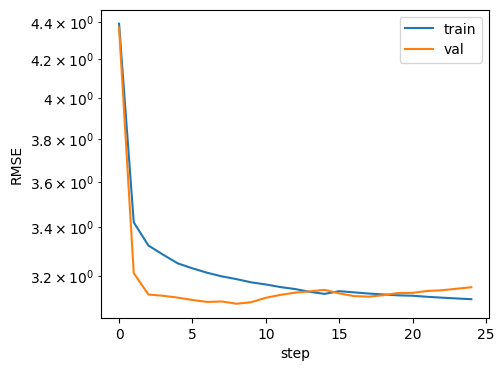

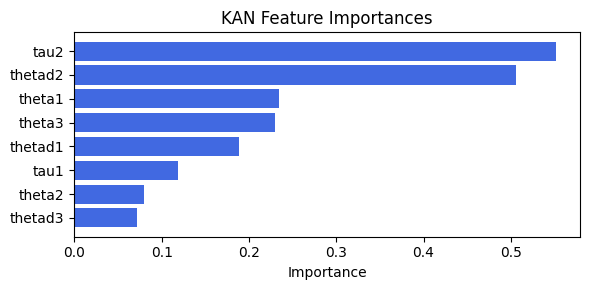

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.61it/s]

[('tau1', 0.45611056358111285), ('tau2', 0.3883860256806687), ('theta1', 0.37563442742799213), ('thetad1', 0.36298630184444525), ('Ex1', 0.28809798801518965), ('thetad2', 0.27992339569820834), ('theta2', 0.2680284408314841), ('theta3', 0.2596644197893922), ('thetad3', 0.17470681190027282)]


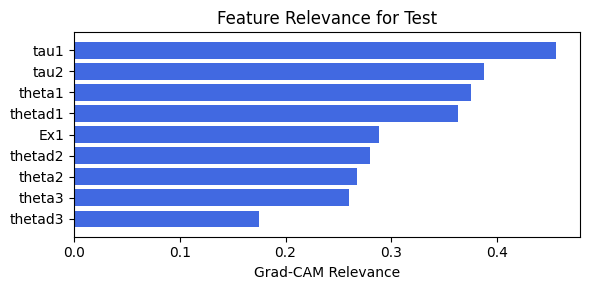

In [119]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.3.2. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.10e+00 | eval_loss: 3.17e+00 | reg: 7.24e+01 |: 100%|█| 25/25 [02:02<00:00,  4.89s/i


saving model version 0.1
Best epoch 7
3.2254140377044678
M_KAN Relevance: 0.00013785166083835065
CNN Relevance: 0.9998621344566345
[('theta3', 0.37536654), ('theta1', 0.3680277), ('thetad3', 0.35603154), ('tau1', 0.35009974), ('thetad2', 0.346762), ('tau2', 0.30086726), ('theta2', 0.29921365), ('thetad1', 0.19117624)]


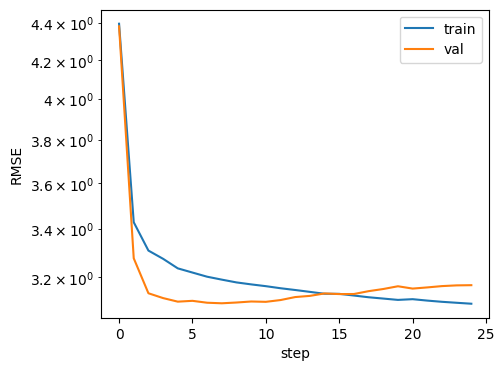

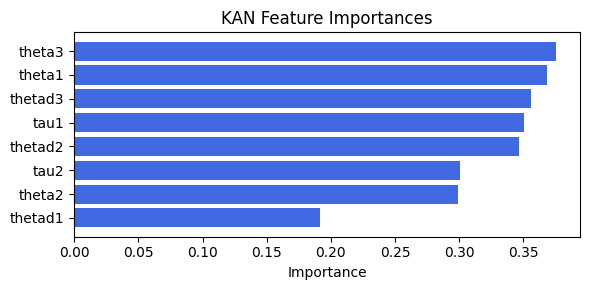

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:20<00:00, 11.65it/s]


[('tau1', 0.381413531177359), ('theta1', 0.3710195973861489), ('thetad1', 0.33046250048300474), ('thetad2', 0.29124240627177755), ('theta2', 0.27024418392329524), ('tau2', 0.2679347449083052), ('theta3', 0.2635687788634525), ('Ex1', 0.20988499616873327), ('thetad3', 0.1491527362051807)]


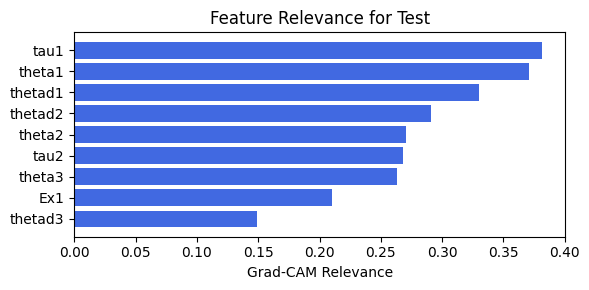

In [120]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.3.3. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.16e+00 | reg: 7.71e+01 |: 100%|█| 25/25 [01:51<00:00,  4.46s/i


saving model version 0.1
Best epoch 5
3.2296106815338135
M_KAN Relevance: 0.00437043234705925
CNN Relevance: 0.9956295490264893
[('thetad2', 0.5243551), ('theta3', 0.52006567), ('theta2', 0.22608326), ('thetad1', 0.1671167), ('thetad3', 0.14996287), ('theta1', 0.14818768), ('tau1', 0.12082693), ('tau2', 0.05120346)]


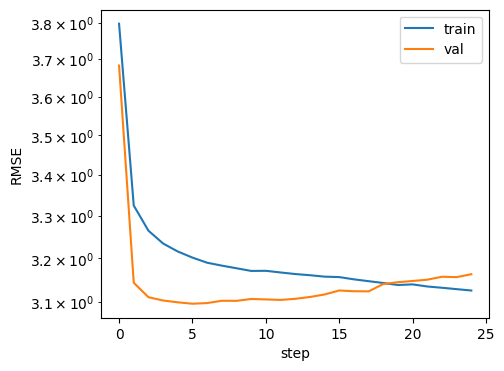

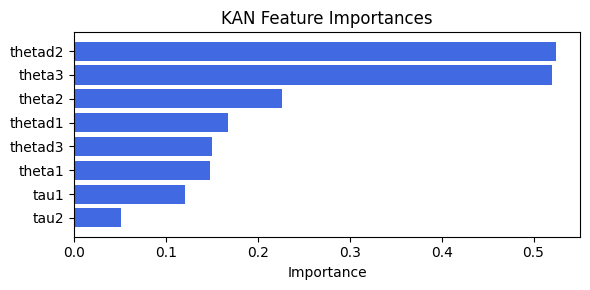

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:19<00:00, 11.78it/s]

[('tau1', 0.3455231422329716), ('theta1', 0.3358208808513876), ('tau2', 0.3354683910342526), ('thetad1', 0.32492531749244985), ('thetad2', 0.27508094322573184), ('theta2', 0.25060434101126694), ('theta3', 0.188212233483574), ('Ex1', 0.17189889883401202), ('thetad3', 0.1053339588217414)]


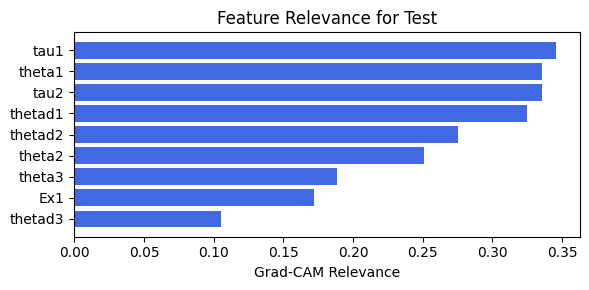

In [121]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.3.4. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.16e+00 | reg: 7.07e+01 |: 100%|█| 25/25 [01:49<00:00,  4.36s/i


saving model version 0.1
Best epoch 6
3.2244677543640137
M_KAN Relevance: 0.005490081384778023
CNN Relevance: 0.9945099353790283
[('thetad2', 0.43954536), ('theta1', 0.42628726), ('theta3', 0.30581486), ('theta2', 0.14444941), ('thetad1', 0.13591583), ('tau1', 0.13289528), ('tau2', 0.10214003), ('thetad3', 0.038145613)]


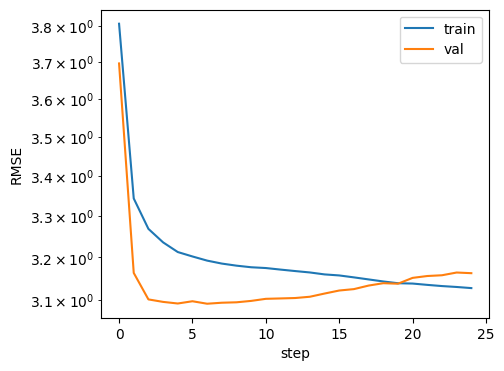

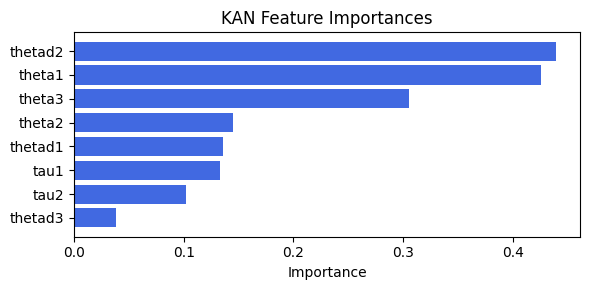

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:22<00:00, 11.48it/s]


[('theta1', 0.4001999175845253), ('thetad1', 0.3829453737367969), ('tau1', 0.3565071587861133), ('tau2', 0.33486260134574), ('thetad2', 0.3330514967513777), ('theta2', 0.29284044413397214), ('Ex1', 0.19169312780930556), ('theta3', 0.17642478068133008), ('thetad3', 0.10314251466933311)]


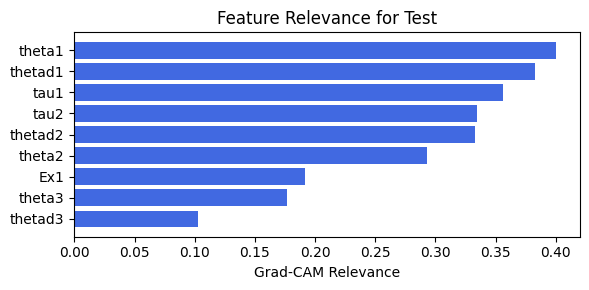

In [122]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.3.5. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.13e+00 | reg: 8.24e+01 |: 100%|█| 25/25 [01:49<00:00,  4.38s/i

saving model version 0.1
Best epoch 6
3.2377307415008545
M_KAN Relevance: 0.009984192438423634
CNN Relevance: 0.9900158643722534
[('thetad2', 0.7399142), ('theta1', 0.2542761), ('theta2', 0.24738327), ('thetad1', 0.24504727), ('thetad3', 0.23778832), ('theta3', 0.2239764), ('tau2', 0.13537589), ('tau1', 0.06694974)]


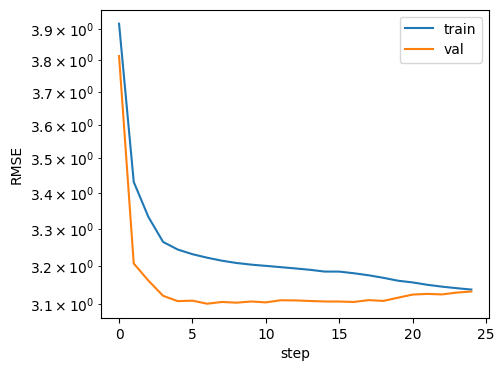

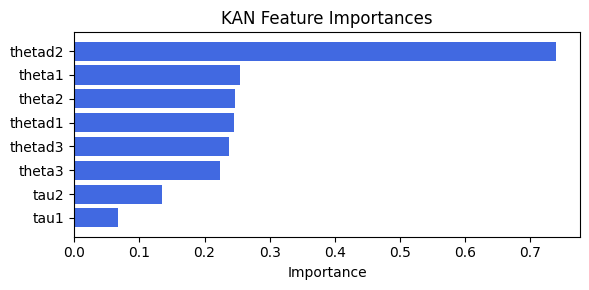

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.52it/s]

[('tau1', 0.4173501479758212), ('tau2', 0.390815899567115), ('thetad1', 0.3475329853759302), ('theta1', 0.33664468657519425), ('thetad2', 0.29066944851962934), ('theta2', 0.2594425279484351), ('theta3', 0.21525250158928966), ('Ex1', 0.21303622428416727), ('thetad3', 0.16374113801707665)]


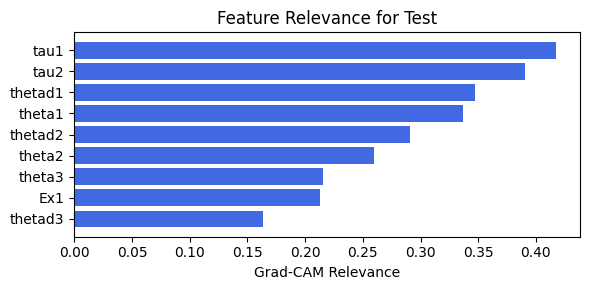

In [123]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.3.6. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.17e+00 | reg: 7.68e+01 |: 100%|█| 25/25 [01:48<00:00,  4.34s/i

saving model version 0.1
Best epoch 7
3.2341108322143555
M_KAN Relevance: 0.0194805059581995
CNN Relevance: 0.9805195331573486
[('thetad2', 0.6672489), ('theta1', 0.33817467), ('theta2', 0.2890196), ('thetad3', 0.19152908), ('thetad1', 0.11163089), ('theta3', 0.103048496), ('tau1', 0.06764204), ('tau2', 0.030876122)]


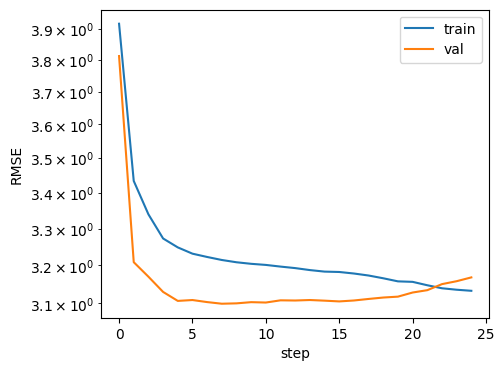

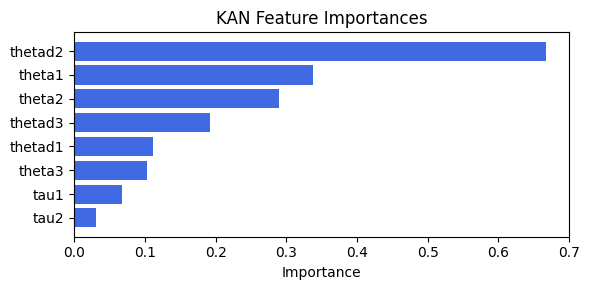

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:54<00:00, 14.29it/s]

[('tau1', 0.4220393777585147), ('tau2', 0.3834172880173851), ('thetad1', 0.3579831084409563), ('theta1', 0.35463848790890284), ('thetad2', 0.2891192414590955), ('theta2', 0.2614940494463223), ('theta3', 0.23957288305489755), ('thetad3', 0.22757669721287796), ('Ex1', 0.19346664424415574)]


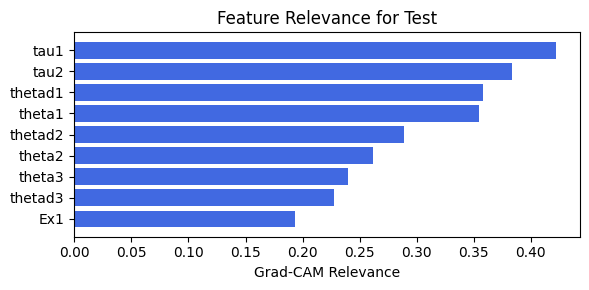

In [124]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.3.7. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.10e+00 | eval_loss: 3.20e+00 | reg: 7.75e+01 |: 100%|█| 25/25 [01:46<00:00,  4.25s/i

saving model version 0.1
Best epoch 4
3.2375760078430176
M_KAN Relevance: 0.02629312314093113
CNN Relevance: 0.9737069010734558
[('theta2', 0.74728155), ('thetad2', 0.55520236), ('theta3', 0.12293404), ('thetad1', 0.07899212), ('tau1', 0.056825347), ('tau2', 0.03055047), ('thetad3', 0.02556571), ('theta1', 0.021906689)]


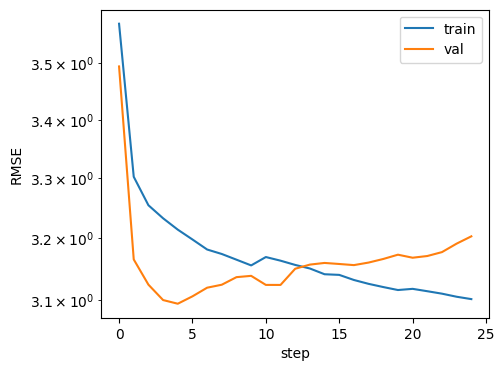

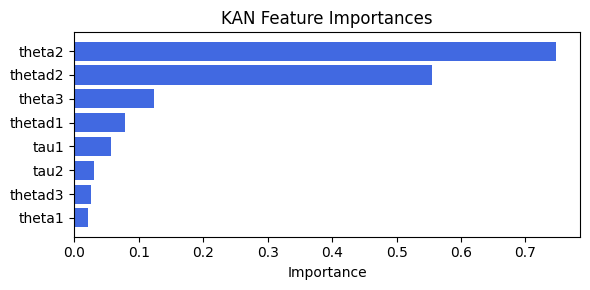

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:00<00:00, 13.65it/s]

[('tau2', 0.5015893633659475), ('tau1', 0.47128465503934075), ('thetad1', 0.3121531023842002), ('Ex1', 0.2978314140398995), ('theta1', 0.28943680596597265), ('theta3', 0.24085013160329766), ('thetad2', 0.22847031525402903), ('theta2', 0.2145325539522002), ('thetad3', 0.20544309631028396)]


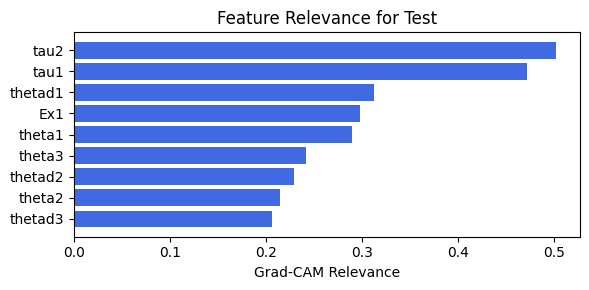

In [125]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.3.8. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.18e+00 | reg: 7.45e+01 |: 100%|█| 25/25 [01:46<00:00,  4.26s/i

saving model version 0.1
Best epoch 5
3.2446908950805664
M_KAN Relevance: 0.06367150694131851
CNN Relevance: 0.9363285303115845
[('theta2', 0.73813224), ('thetad2', 0.48541307), ('theta3', 0.17282781), ('theta1', 0.16309528), ('tau2', 0.098029695), ('thetad1', 0.09158911), ('thetad3', 0.08470993), ('tau1', 0.038814094)]


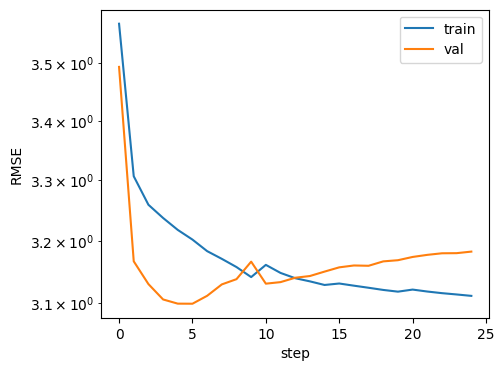

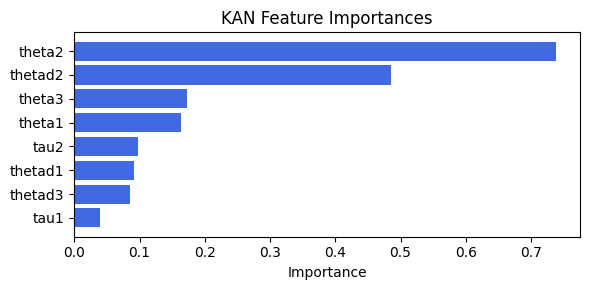

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:02<00:00, 13.38it/s]


[('tau2', 0.5024591054833435), ('tau1', 0.4723598131687701), ('thetad1', 0.31673246889287676), ('theta1', 0.287795093155114), ('Ex1', 0.27643914121299756), ('thetad3', 0.2557972517229126), ('theta3', 0.2511031895892718), ('thetad2', 0.22583581283967685), ('theta2', 0.2210348552284189)]


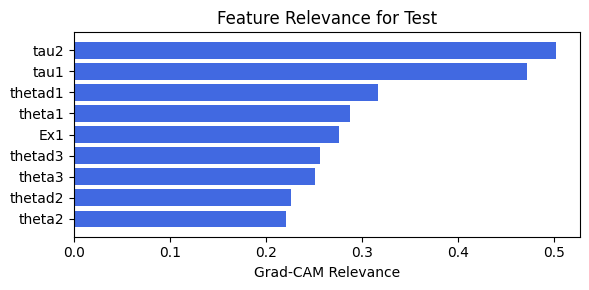

In [126]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

# Option3

In [69]:
create_csv_with_header(filename_3, columns_opt3)

In [70]:
print("------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=5, kan_grid=4, lamb=0.0001, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=6, kan_grid=5, lamb=1e-05, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.65e-01 | eval_loss: 1.90e-01 | reg: 5.80e+01 |: 100%|█| 70/70 [01:06<00:00,  1.06it/


saving model version 0.1
Best epoch 68
0.2547908127307892
M_KAN Relevance: 0.006731957197189331
CNN Relevance: 0.9932680130004883
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.79e-01 | eval_loss: 1.94e-01 | reg: 6.08e+01 |: 100%|█| 70/70 [01:06<00:00,  1.05it/


saving model version 0.1
Best epoch 69
0.24428293108940125
M_KAN Relevance: 0.0036170948296785355
CNN Relevance: 0.9963828921318054
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.68e-01 | eval_loss: 2.01e-01 | reg: 5.45e+01 |: 100%|█| 70/70 [01:08<00:00,  1.02it/


saving model version 0.1
Best epoch 61
0.2435559779405594
M_KAN Relevance: 0.00345560722053051
CNN Relevance: 0.996544361114502
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.36e-01 | eval_loss: 1.97e-01 | reg: 5.27e+01 |: 100%|█| 70/70 [01:06<00:00,  1.05it/


saving model version 0.1
Best epoch 44
0.25242966413497925
M_KAN Relevance: 0.0019772471860051155
CNN Relevance: 0.9980227947235107
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |:   7%|█              | 5/70 [00:05<01:12,  1.12s/it]


saving model version 0.1
Best epoch 4
0.49606814980506897
M_KAN Relevance: 0.0
CNN Relevance: 1.0
------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.39e-01 | eval_loss: 2.08e-01 | reg: 5.53e+01 |: 100%|█| 70/70 [01:13<00:00,  1.05s/i


saving model version 0.1
Best epoch 37
0.2548610270023346
M_KAN Relevance: 0.003792689647525549
CNN Relevance: 0.9962073564529419
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.49e-01 | eval_loss: 1.93e-01 | reg: 5.78e+01 |: 100%|█| 70/70 [01:13<00:00,  1.05s/i


saving model version 0.1
Best epoch 42
0.2753015160560608
M_KAN Relevance: 0.003431570017710328
CNN Relevance: 0.9965684413909912
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.39e-01 | eval_loss: 1.97e-01 | reg: 5.46e+01 |: 100%|█| 70/70 [01:13<00:00,  1.05s/i


saving model version 0.1
Best epoch 52
0.25786417722702026
M_KAN Relevance: 0.003977566491812468
CNN Relevance: 0.9960224032402039
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.63e-01 | eval_loss: 1.89e-01 | reg: 5.93e+01 |: 100%|█| 70/70 [01:13<00:00,  1.05s/i


saving model version 0.1
Best epoch 67
0.24923066794872284
M_KAN Relevance: 0.005968540441244841
CNN Relevance: 0.9940314888954163
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.25e-01 | eval_loss: 2.19e-01 | reg: 5.60e+01 |: 100%|█| 70/70 [01:12<00:00,  1.04s/i


saving model version 0.1
Best epoch 46
0.25907036662101746
M_KAN Relevance: 0.0035468728747218847
CNN Relevance: 0.9964531660079956
------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.19e-01 | eval_loss: 2.00e-01 | reg: 4.78e+01 |: 100%|█| 70/70 [01:17<00:00,  1.11s/i


saving model version 0.1
Best epoch 59
0.33390745520591736
M_KAN Relevance: 0.00037202751263976097
CNN Relevance: 0.999627947807312
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.55e-01 | eval_loss: 1.96e-01 | reg: 5.05e+01 |: 100%|█| 70/70 [01:17<00:00,  1.11s/i


saving model version 0.1
Best epoch 68
0.3289887607097626
M_KAN Relevance: 0.0013904321240261197
CNN Relevance: 0.9986095428466797
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.28e-01 | eval_loss: 1.89e-01 | reg: 5.11e+01 |: 100%|█| 70/70 [01:19<00:00,  1.13s/i


saving model version 0.1
Best epoch 47
0.28518468141555786
M_KAN Relevance: 0.0037442450411617756
CNN Relevance: 0.9962556958198547
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 6.78e-02 | eval_loss: 2.73e-01 | reg: 1.27e+02 |: 100%|█| 70/70 [01:14<00:00,  1.06s/i


saving model version 0.1
Best epoch 34
0.44504812359809875
M_KAN Relevance: 0.00037409915239550173
CNN Relevance: 0.9996258616447449
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.11e-01 | eval_loss: 1.85e-01 | reg: 5.21e+01 |: 100%|█| 70/70 [01:17<00:00,  1.11s/i


saving model version 0.1
Best epoch 69
0.28598183393478394
M_KAN Relevance: 0.0014118485851213336
CNN Relevance: 0.9985882043838501
------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.51e-01 | eval_loss: 1.95e-01 | reg: 5.72e+01 |: 100%|█| 70/70 [01:04<00:00,  1.09it/


saving model version 0.1
Best epoch 69
0.2653900980949402
M_KAN Relevance: 0.002296034712344408
CNN Relevance: 0.9977039098739624
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.47e-01 | eval_loss: 1.95e-01 | reg: 5.92e+01 |: 100%|█| 70/70 [01:06<00:00,  1.05it/


saving model version 0.1
Best epoch 69
0.2538439631462097
M_KAN Relevance: 0.0030310277361422777
CNN Relevance: 0.9969689249992371
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.48e-01 | eval_loss: 1.96e-01 | reg: 5.81e+01 |: 100%|█| 70/70 [01:06<00:00,  1.05it/


saving model version 0.1
Best epoch 67
0.2705356776714325
M_KAN Relevance: 0.0029419742058962584
CNN Relevance: 0.9970579743385315
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.44e-01 | eval_loss: 1.96e-01 | reg: 6.53e+01 |: 100%|█| 70/70 [01:06<00:00,  1.06it/


saving model version 0.1
Best epoch 58
0.24385277926921844
M_KAN Relevance: 0.0032460864167660475
CNN Relevance: 0.9967539310455322
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 1.11e-01 | eval_loss: 1.87e-01 | reg: 5.97e+01 |: 100%|█| 70/70 [01:05<00:00,  1.07it/

saving model version 0.1
Best epoch 54
0.2942955493927002
M_KAN Relevance: 0.0017352249706164002
CNN Relevance: 0.998264729976654


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 40/40 [02:42<00:00,  4.06s/it]

saving model version 0.1
Best epoch 4
3.251739263534546
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('theta2', 0.401448), ('thetad2', 0.3935411), ('thetad1', 0.36943585), ('theta3', 0.31888264), ('thetad3', 0.2970466), ('theta1', 0.28125656), ('tau1', 0.23055187), ('tau2', 0.09635257)]


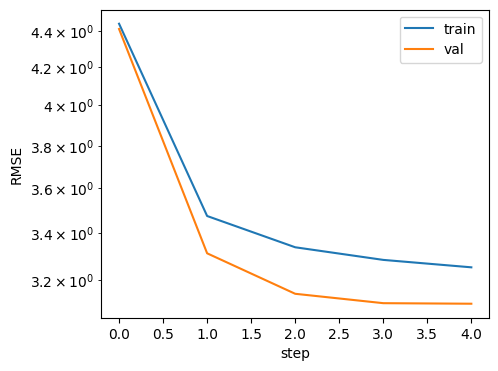

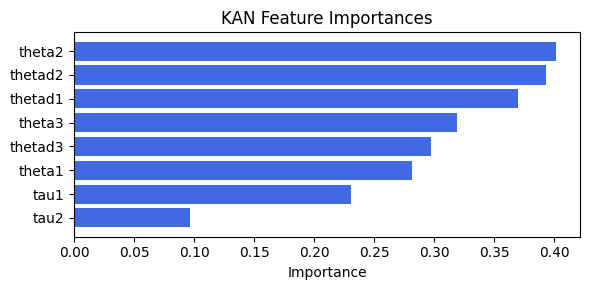

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:19<00:00, 11.71it/s]

[('thetad2', 0.38683542461816434), ('theta1', 0.37335448339657845), ('theta2', 0.3487778590483744), ('thetad1', 0.3359875945932865), ('theta3', 0.27387927353043734), ('tau1', 0.23127723906132452), ('tau2', 0.2171122347722439), ('thetad3', 0.18179196862825217), ('Ex1', 0.16607715968774595)]


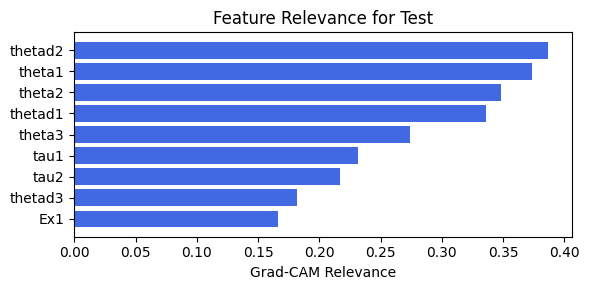

In [140]:
train_and_plot_relevance(Model3_3, kan_neurons=4, kan_grid=3, lamb=0.01, steps=40, hidden_dim=128, filename=filename_3, opt_col_val=128)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.30e+00 | eval_loss: 3.13e+00 | reg: 9.52e+01 |: 100%|█| 5/5 [00:22<00:00,  4.58s/it]

saving model version 0.1
Best epoch 4
3.2851507663726807
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('tau2', 0.39597934), ('thetad1', 0.38120526), ('tau1', 0.34605014), ('theta2', 0.33152997), ('thetad2', 0.328989), ('thetad3', 0.3106376), ('theta3', 0.28034598), ('theta1', 0.16354744)]


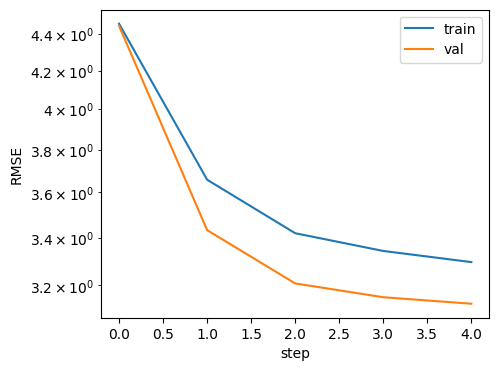

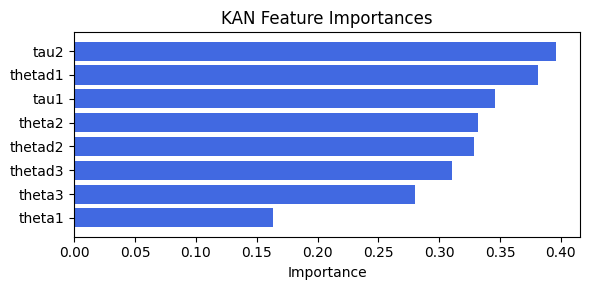

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:08<00:00, 12.80it/s]

[('theta3', 0.34845422841153234), ('thetad3', 0.3173118621802767), ('Ex1', 0.2816440408766415), ('theta2', 0.21148800393786144), ('theta1', 0.20805372182350002), ('tau1', 0.2045459495511184), ('thetad2', 0.15804809593269936), ('thetad1', 0.15442147988513885), ('tau2', 0.14968227105664633)]


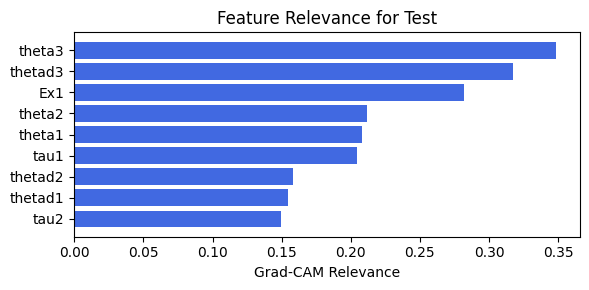

In [150]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=5, hidden_dim=8, filename=filename_3, opt_col_val=8)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.29e+00 | eval_loss: 3.13e+00 | reg: 9.59e+01 |: 100%|█| 5/5 [00:23<00:00,  4.63s/it]

saving model version 0.1
Best epoch 4
3.283827781677246
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad1', 0.40900397), ('theta1', 0.40541574), ('thetad2', 0.3930657), ('theta2', 0.34506854), ('thetad3', 0.2531985), ('tau2', 0.18114123), ('tau1', 0.13337237), ('theta3', 0.106063366)]


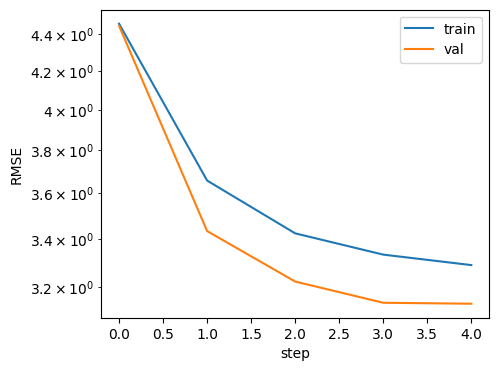

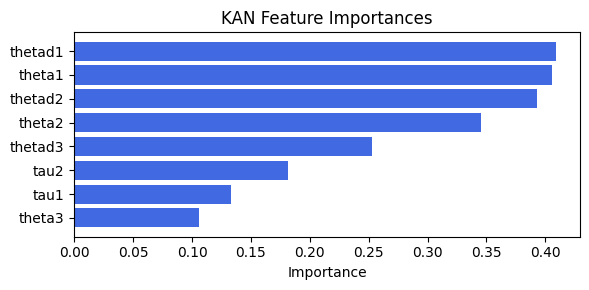

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.35it/s]

[('theta3', 0.3220084780261549), ('thetad3', 0.2857014104325231), ('Ex1', 0.2409397129218314), ('theta1', 0.21860007642473697), ('theta2', 0.21584237647807555), ('tau1', 0.2133138193735396), ('thetad1', 0.16566002750275632), ('thetad2', 0.16449162615775123), ('tau2', 0.1601002946570909)]


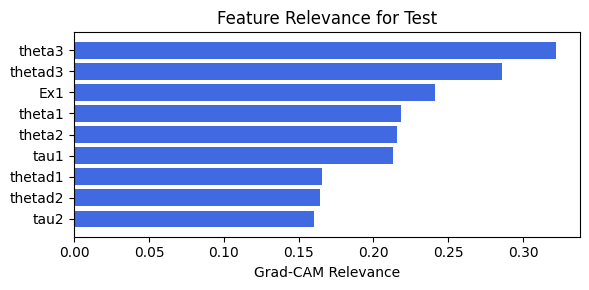

In [151]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=5, hidden_dim=8, filename=filename_3, opt_col_val=8)

# Opt4: MultiHead Attention

In [71]:
create_csv_with_header(filename_4, columns_opt4)

In [73]:
print("------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=5, kan_grid=4, lamb=0.0001, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=5, kan_grid=4, lamb=0.0001, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

print("------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=6, kan_grid=5, lamb=1e-05, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=6, kan_grid=5, lamb=1e-05, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')


print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')
for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')



print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=110,
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=110,
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')


------------------------------ kan_neurons=5, kan_grid=4, lamb=0.0001 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.74e-01 | eval_loss: 3.26e-01 | reg: 2.26e+01 |: 100%|█| 110/110 [00:36<00:00,  2.98i


saving model version 0.1
Best epoch 98
0.5022209286689758
M_KAN Relevance: 0.011458201333880424
CNN Relevance: 0.9885417819023132
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.58e-01 | eval_loss: 2.72e-01 | reg: 2.36e+01 |: 100%|█| 110/110 [00:37<00:00,  2.90i


saving model version 0.1
Best epoch 107
0.4893162250518799
M_KAN Relevance: 0.04693043977022171
CNN Relevance: 0.9530695080757141
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.58e-01 | eval_loss: 2.72e-01 | reg: 2.36e+01 |: 100%|█| 110/110 [00:38<00:00,  2.88i


saving model version 0.1
Best epoch 107
0.4893162250518799
M_KAN Relevance: 0.04693043977022171
CNN Relevance: 0.9530695080757141
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.06e-01 | eval_loss: 2.35e-01 | reg: 1.41e+01 |: 100%|█| 110/110 [00:37<00:00,  2.90i


saving model version 0.1
Best epoch 109
0.5373333096504211
M_KAN Relevance: 0.03940342366695404
CNN Relevance: 0.9605965614318848
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.03e-01 | eval_loss: 2.47e-01 | reg: 1.47e+01 |: 100%|█| 110/110 [00:37<00:00,  2.93i


saving model version 0.1
Best epoch 74
0.4795447289943695
M_KAN Relevance: 0.08797689527273178
CNN Relevance: 0.9120230674743652
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.12e-01 | eval_loss: 2.49e-01 | reg: 1.43e+01 |: 100%|█| 110/110 [00:35<00:00,  3.08i


saving model version 0.1
Best epoch 50
0.4580709934234619
M_KAN Relevance: 0.1447577178478241
CNN Relevance: 0.8552423119544983
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.66e-01 | eval_loss: 2.93e-01 | reg: 1.25e+01 |: 100%|█| 110/110 [00:40<00:00,  2.70i


saving model version 0.1
Best epoch 97
0.45450225472450256
M_KAN Relevance: 0.16092826426029205
CNN Relevance: 0.8390716910362244
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.63e-01 | eval_loss: 2.62e-01 | reg: 1.50e+01 |: 100%|█| 110/110 [00:36<00:00,  2.99i


saving model version 0.1
Best epoch 107
0.4379902184009552
M_KAN Relevance: 0.332220196723938
CNN Relevance: 0.6677798628807068
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.70e-01 | eval_loss: 2.56e-01 | reg: 1.47e+01 |: 100%|█| 110/110 [00:35<00:00,  3.07i


saving model version 0.1
Best epoch 109
0.45418980717658997
M_KAN Relevance: 0.3811383843421936
CNN Relevance: 0.6188616156578064
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.08e-01 | eval_loss: 2.53e-01 | reg: 1.42e+01 |: 100%|█| 110/110 [00:35<00:00,  3.10i


saving model version 0.1
Best epoch 104
0.464813232421875
M_KAN Relevance: 0.025854695588350296
CNN Relevance: 0.9741453528404236
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.10e-01 | eval_loss: 2.86e-01 | reg: 1.57e+01 |: 100%|█| 110/110 [00:36<00:00,  3.03i


saving model version 0.1
Best epoch 40
0.5070131421089172
M_KAN Relevance: 0.35125619173049927
CNN Relevance: 0.6487438082695007
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.10e-01 | eval_loss: 2.65e-01 | reg: 1.01e+01 |: 100%|█| 110/110 [00:35<00:00,  3.09i


saving model version 0.1
Best epoch 79
0.46906664967536926
M_KAN Relevance: 0.12938040494918823
CNN Relevance: 0.870619535446167
------------------------------ kan_neurons=6, kan_grid=5, lamb=1e-05 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 8.68e-02 | eval_loss: 3.08e-01 | reg: 2.62e+01 |: 100%|█| 110/110 [00:37<00:00,  2.97i


saving model version 0.1
Best epoch 57
0.5096463561058044
M_KAN Relevance: 0.19955626130104065
CNN Relevance: 0.8004437685012817
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 9.12e-02 | eval_loss: 2.70e-01 | reg: 2.67e+01 |: 100%|█| 110/110 [00:35<00:00,  3.06i


saving model version 0.1
Best epoch 42
0.5050390958786011
M_KAN Relevance: 0.20086152851581573
CNN Relevance: 0.7991384863853455
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.09e-01 | eval_loss: 2.45e-01 | reg: 2.54e+01 |: 100%|█| 110/110 [00:36<00:00,  3.03i


saving model version 0.1
Best epoch 89
0.5123715400695801
M_KAN Relevance: 0.10830875486135483
CNN Relevance: 0.891691267490387
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.11e-01 | eval_loss: 2.49e-01 | reg: 2.42e+01 |: 100%|█| 110/110 [00:36<00:00,  3.00i


saving model version 0.1
Best epoch 53
0.45910537242889404
M_KAN Relevance: 0.10984962433576584
CNN Relevance: 0.8901503682136536
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.13e-01 | eval_loss: 2.46e-01 | reg: 2.41e+01 |: 100%|█| 110/110 [00:39<00:00,  2.76i


saving model version 0.1
Best epoch 46
0.461604505777359
M_KAN Relevance: 0.10600839555263519
CNN Relevance: 0.8939916491508484
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.07e-01 | eval_loss: 2.56e-01 | reg: 2.19e+01 |: 100%|█| 110/110 [00:37<00:00,  2.94i


saving model version 0.1
Best epoch 109
0.49144378304481506
M_KAN Relevance: 0.1405421942472458
CNN Relevance: 0.8594578504562378
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.10e-01 | eval_loss: 3.90e-01 | reg: 2.31e+01 |: 100%|█| 110/110 [00:31<00:00,  3.53i


saving model version 0.1
Best epoch 81
0.4806225299835205
M_KAN Relevance: 0.6966225504875183
CNN Relevance: 0.3033774197101593
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.10e-01 | eval_loss: 3.90e-01 | reg: 2.31e+01 |: 100%|█| 110/110 [00:32<00:00,  3.42i


saving model version 0.1
Best epoch 81
0.4806225299835205
M_KAN Relevance: 0.6966225504875183
CNN Relevance: 0.3033774197101593
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.10e-01 | eval_loss: 3.90e-01 | reg: 2.31e+01 |: 100%|█| 110/110 [00:31<00:00,  3.49i


saving model version 0.1
Best epoch 81
0.4806225299835205
M_KAN Relevance: 0.6966225504875183
CNN Relevance: 0.3033774197101593
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.67e-01 | eval_loss: 2.92e-01 | reg: 2.32e+01 |: 100%|█| 110/110 [00:38<00:00,  2.89i


saving model version 0.1
Best epoch 109
0.4942477345466614
M_KAN Relevance: 0.006877526640892029
CNN Relevance: 0.9931224584579468
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.69e-01 | eval_loss: 3.19e-01 | reg: 2.34e+01 |: 100%|█| 110/110 [00:37<00:00,  2.96i


saving model version 0.1
Best epoch 103
0.4583873152732849
M_KAN Relevance: 0.10977409034967422
CNN Relevance: 0.8902259469032288
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.59e-01 | eval_loss: 4.09e-01 | reg: 2.40e+01 |: 100%|█| 110/110 [00:23<00:00,  4.64i


saving model version 0.1
Best epoch 75
0.49342966079711914
M_KAN Relevance: 0.36798709630966187
CNN Relevance: 0.6320129632949829
------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.24e-01 | eval_loss: 2.69e-01 | reg: 1.88e+01 |: 100%|█| 110/110 [00:37<00:00,  2.94i


saving model version 0.1
Best epoch 48
0.48995527625083923
M_KAN Relevance: 0.0008608635980635881
CNN Relevance: 0.999139130115509
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.24e-01 | eval_loss: 2.69e-01 | reg: 1.88e+01 |: 100%|█| 110/110 [00:34<00:00,  3.19i


saving model version 0.1
Best epoch 48
0.48995527625083923
M_KAN Relevance: 0.0008608635980635881
CNN Relevance: 0.999139130115509
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.24e-01 | eval_loss: 2.69e-01 | reg: 1.88e+01 |: 100%|█| 110/110 [00:35<00:00,  3.14i


saving model version 0.1
Best epoch 48
0.48995527625083923
M_KAN Relevance: 0.0008608635980635881
CNN Relevance: 0.999139130115509
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 8.53e-02 | eval_loss: 2.96e-01 | reg: 1.72e+01 |: 100%|█| 110/110 [00:42<00:00,  2.62i


saving model version 0.1
Best epoch 44
0.4762340784072876
M_KAN Relevance: 0.0006680633523501456
CNN Relevance: 0.9993319511413574
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 9.17e-02 | eval_loss: 2.51e-01 | reg: 1.71e+01 |: 100%|█| 110/110 [00:36<00:00,  3.04i


saving model version 0.1
Best epoch 53
0.4442795515060425
M_KAN Relevance: 0.00040764978621155024
CNN Relevance: 0.9995923042297363
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 8.53e-02 | eval_loss: 2.96e-01 | reg: 1.72e+01 |: 100%|█| 110/110 [00:35<00:00,  3.06i


saving model version 0.1
Best epoch 44
0.4762340784072876
M_KAN Relevance: 0.0006680633523501456
CNN Relevance: 0.9993319511413574
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 7.96e-01 | eval_loss: 7.87e-01 | reg: 1.91e+01 |: 100%|█| 110/110 [00:25<00:00,  4.39i


saving model version 0.1
Best epoch 70
0.8241291046142578
M_KAN Relevance: 0.001276873517781496
CNN Relevance: 0.9987230896949768
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 7.96e-01 | eval_loss: 7.87e-01 | reg: 1.91e+01 |: 100%|█| 110/110 [00:21<00:00,  5.17i


saving model version 0.1
Best epoch 70
0.8241291046142578
M_KAN Relevance: 0.001276873517781496
CNN Relevance: 0.9987230896949768
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 7.96e-01 | eval_loss: 7.87e-01 | reg: 1.91e+01 |: 100%|█| 110/110 [00:21<00:00,  5.05i


saving model version 0.1
Best epoch 70
0.8241291046142578
M_KAN Relevance: 0.001276873517781496
CNN Relevance: 0.9987230896949768
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 9.67e-02 | eval_loss: 3.45e-01 | reg: 1.93e+01 |: 100%|█| 110/110 [00:35<00:00,  3.08i


saving model version 0.1
Best epoch 43
0.46629199385643005
M_KAN Relevance: 0.0015743318945169449
CNN Relevance: 0.9984256625175476
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.25e-01 | eval_loss: 2.81e-01 | reg: 1.57e+01 |: 100%|█| 110/110 [00:36<00:00,  2.98i


saving model version 0.1
Best epoch 77
0.5063520073890686
M_KAN Relevance: 0.10420282930135727
CNN Relevance: 0.8957971334457397
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 2.45e-01 | eval_loss: 3.65e-01 | reg: 1.42e+01 |: 100%|█| 110/110 [00:37<00:00,  2.91i


saving model version 0.1
Best epoch 98
0.4993419051170349
M_KAN Relevance: 1.318118869425981e-21
CNN Relevance: 1.0
------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.13e-01 | eval_loss: 2.64e-01 | reg: 2.84e+01 |: 100%|█| 110/110 [00:36<00:00,  3.00i


saving model version 0.1
Best epoch 46
0.5085126757621765
M_KAN Relevance: 0.053116023540496826
CNN Relevance: 0.9468839764595032
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.14e-01 | eval_loss: 2.71e-01 | reg: 2.80e+01 |: 100%|█| 110/110 [00:36<00:00,  3.05i


saving model version 0.1
Best epoch 76
0.5020716786384583
M_KAN Relevance: 0.11703772842884064
CNN Relevance: 0.8829623460769653
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.14e-01 | eval_loss: 2.71e-01 | reg: 2.80e+01 |: 100%|█| 110/110 [00:37<00:00,  2.90i


saving model version 0.1
Best epoch 76
0.5020716786384583
M_KAN Relevance: 0.11703772842884064
CNN Relevance: 0.8829623460769653
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.25e-01 | eval_loss: 2.96e-01 | reg: 2.36e+01 |: 100%|█| 110/110 [00:38<00:00,  2.83i


saving model version 0.1
Best epoch 77
0.4527898132801056
M_KAN Relevance: 0.33635038137435913
CNN Relevance: 0.6636495590209961
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.67e-01 | eval_loss: 2.74e-01 | reg: 2.55e+01 |: 100%|█| 110/110 [00:40<00:00,  2.74i


saving model version 0.1
Best epoch 109
0.49146074056625366
M_KAN Relevance: 0.47537729144096375
CNN Relevance: 0.5246226787567139
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.25e-01 | eval_loss: 2.96e-01 | reg: 2.36e+01 |: 100%|█| 110/110 [00:38<00:00,  2.89i


saving model version 0.1
Best epoch 77
0.4527898132801056
M_KAN Relevance: 0.33635038137435913
CNN Relevance: 0.6636495590209961
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.71e-01 | eval_loss: 3.03e-01 | reg: 2.30e+01 |: 100%|█| 110/110 [00:39<00:00,  2.82i


saving model version 0.1
Best epoch 53
0.5116262435913086
M_KAN Relevance: 0.7978916764259338
CNN Relevance: 0.20210829377174377
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.68e-01 | eval_loss: 2.94e-01 | reg: 2.40e+01 |: 100%|█| 110/110 [00:39<00:00,  2.80i


saving model version 0.1
Best epoch 108
0.4735530912876129
M_KAN Relevance: 0.8069504499435425
CNN Relevance: 0.19304953515529633
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.38e-01 | eval_loss: 3.04e-01 | reg: 2.21e+01 |: 100%|█| 110/110 [00:37<00:00,  2.95i


saving model version 0.1
Best epoch 102
0.46414774656295776
M_KAN Relevance: 0.8087500929832458
CNN Relevance: 0.19124984741210938
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 1.28e-01 | eval_loss: 3.59e-01 | reg: 2.34e+01 |: 100%|█| 110/110 [00:36<00:00,  3.03i


saving model version 0.1
Best epoch 41
0.4716103672981262
M_KAN Relevance: 0.17989934980869293
CNN Relevance: 0.8201006054878235
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 9.97e-02 | eval_loss: 3.98e-01 | reg: 2.49e+01 |: 100%|█| 110/110 [00:36<00:00,  3.02i


saving model version 0.1
Best epoch 27
0.5034455060958862
M_KAN Relevance: 0.11855747550725937
CNN Relevance: 0.8814425468444824
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 2.19e-01 | eval_loss: 3.58e-01 | reg: 2.35e+01 |: 100%|█| 110/110 [00:41<00:00,  2.62i

saving model version 0.1
Best epoch 62
0.49517130851745605
M_KAN Relevance: 0.5514973998069763
CNN Relevance: 0.44850265979766846


embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.08e+00 | eval_loss: 3.11e+00 | reg: 2.76e+01 |: 100%|█| 90/90 [02:40<00:00,  1.79s/i


saving model version 0.1
Best epoch 69
3.270108222961426
M_KAN Relevance: 0.0032900564838200808
CNN Relevance: 0.996709942817688
[('theta2', 0.48238337), ('theta3', 0.43928054), ('tau2', 0.35258424), ('thetad2', 0.33385563), ('tau1', 0.29633412), ('thetad3', 0.288198), ('thetad1', 0.11040855), ('theta1', 0.05946763)]


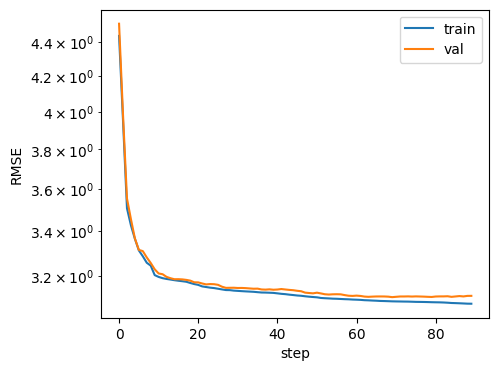

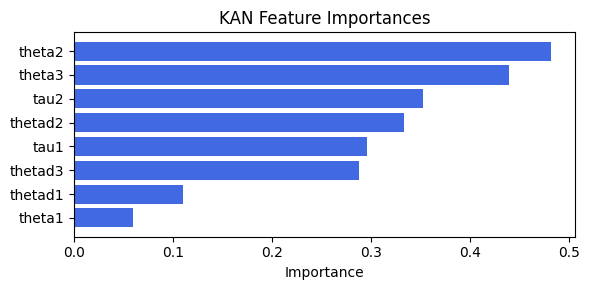

Computing Grad-CAM:   0%|          | 0/1639 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('thetad2', 0.33142023575263846), ('theta1', 0.29664781605423873), ('theta2', 0.27438381320723465), ('tau2', 0.2709895322089242), ('thetad1', 0.26328103794089597), ('Ex1', 0.2532749381913283), ('tau1', 0.24554013080965692), ('theta3', 0.22337621327348198), ('thetad3', 0.11380851693982554)]


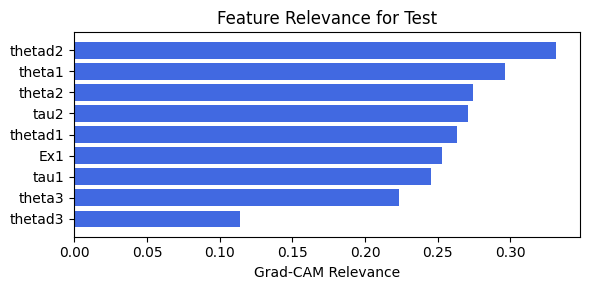

embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.05e+00 | eval_loss: 3.13e+00 | reg: 2.27e+01 |: 100%|█| 90/90 [02:42<00:00,  1.80s/i


saving model version 0.1
Best epoch 51
3.2559006214141846
M_KAN Relevance: 0.19418184459209442
CNN Relevance: 0.8058180809020996
[('theta2', 0.4822661), ('theta3', 0.4392671), ('tau2', 0.35271737), ('thetad2', 0.3339957), ('tau1', 0.29646474), ('thetad3', 0.28833508), ('thetad1', 0.11076088), ('theta1', 0.05988028)]


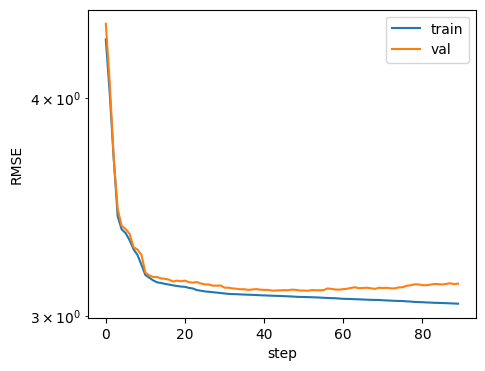

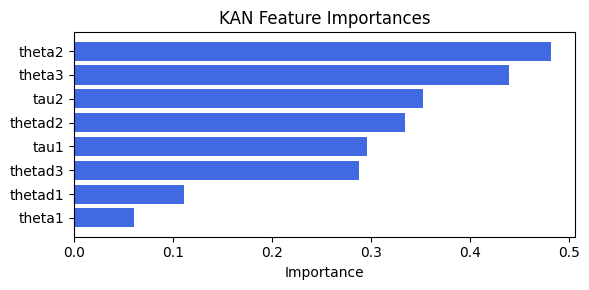

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:30<00:00,  3.21it/s]


[('theta3', 0.24016225184690757), ('thetad2', 0.2281721320946908), ('theta1', 0.21091119731063107), ('theta2', 0.19984119639981693), ('thetad3', 0.18745152585546795), ('thetad1', 0.16118277102537673), ('tau1', 0.1359096612331269), ('Ex1', 0.09586121075026789), ('tau2', 0.06033950296469174)]


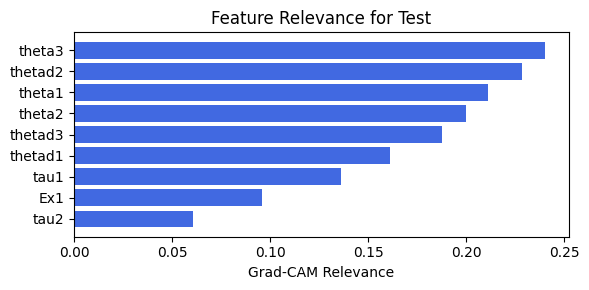

embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.10e+00 | eval_loss: 3.11e+00 | reg: 2.24e+01 |: 100%|█| 90/90 [02:48<00:00,  1.87s/i


saving model version 0.1
Best epoch 87
3.2743752002716064
M_KAN Relevance: 0.10401315242052078
CNN Relevance: 0.8959868550300598
[('theta2', 0.48220366), ('theta3', 0.43925983), ('tau2', 0.35278872), ('thetad2', 0.3340703), ('tau1', 0.29653525), ('thetad3', 0.288409), ('thetad1', 0.1109498), ('theta1', 0.060100652)]


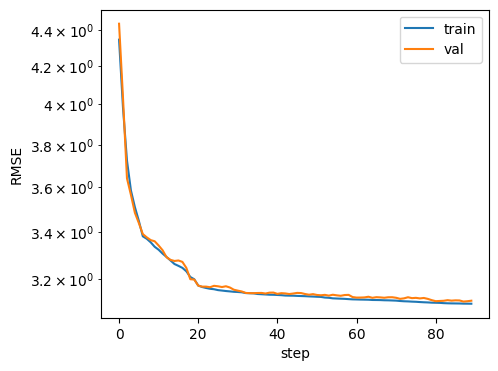

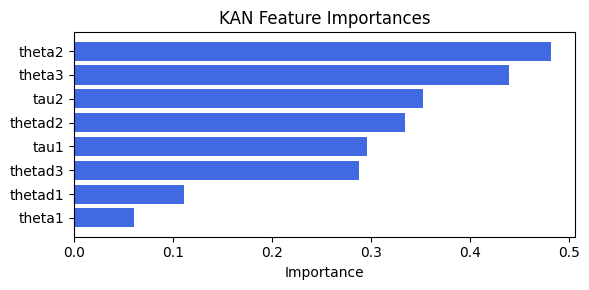

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:31<00:00,  3.21it/s]


[('thetad2', 0.2959186452032647), ('tau1', 0.2763020404178892), ('theta3', 0.27262714731068155), ('theta1', 0.23045828738031782), ('thetad3', 0.22190614630323613), ('theta2', 0.21866102930222978), ('Ex1', 0.20871191199581537), ('thetad1', 0.2039949962863924), ('tau2', 0.19021041487371096)]


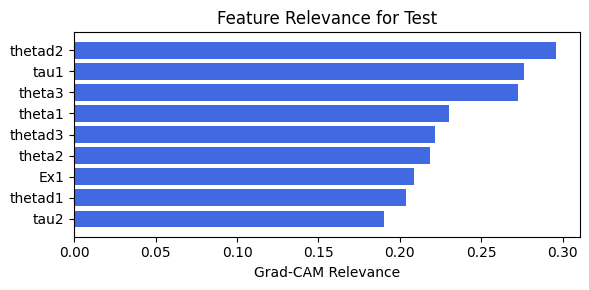

In [41]:
for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=90, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

### 4.0.0 width=[8, 2], grid=4, lamb=1e-05 | embed_dim=64

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.08e+00 | eval_loss: 3.10e+00 | reg: 2.34e+01 |: 100%|█| 60/60 [00:39<00:00,  1.52it/

saving model version 0.1
Best epoch 58
3.2656006813049316
M_KAN Relevance: 0.008687786757946014
CNN Relevance: 0.9913122057914734
[('theta2', 0.48210907), ('theta3', 0.43924952), ('tau2', 0.352894), ('thetad2', 0.3341821), ('tau1', 0.29663935), ('thetad3', 0.28851873), ('thetad1', 0.11123108), ('theta1', 0.06043072)]


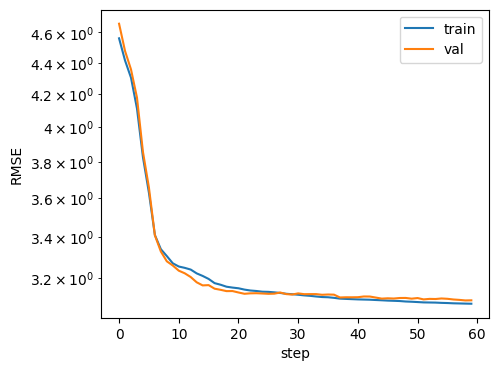

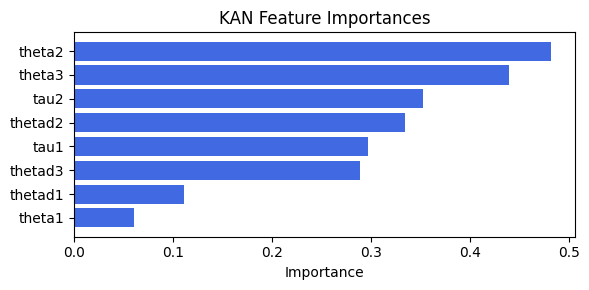

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.43it/s]

[('thetad3', 0.4525190952106684), ('theta3', 0.38979704961347744), ('thetad2', 0.15075029289687156), ('thetad1', 0.09799699462256851), ('Ex1', 0.08621976361891445), ('theta1', 0.07982828527851954), ('tau1', 0.06789152947162817), ('theta2', 0.06509120866927524), ('tau2', 0.045845022511262726)]


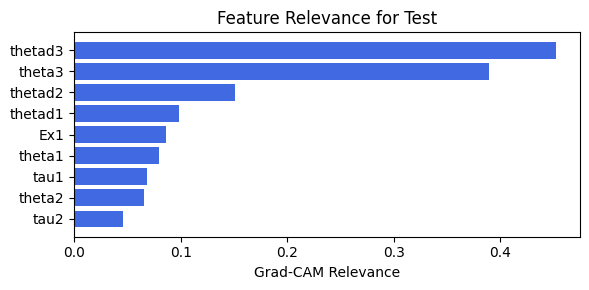

In [153]:
train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, embed_dim=64, filename=filename_4, opt_col_val=64)

### 4.0.1 width=[8, 2], grid=4, lamb=1e-05 | embed_dim=64

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.06e+00 | eval_loss: 3.11e+00 | reg: 2.36e+01 |: 100%|█| 60/60 [00:39<00:00,  1.50it/

saving model version 0.1
Best epoch 26
3.229637384414673
M_KAN Relevance: 0.013515973463654518
CNN Relevance: 0.9864840507507324
[('theta2', 0.48193848), ('theta3', 0.43922886), ('tau2', 0.35308534), ('thetad2', 0.33438414), ('tau1', 0.29682815), ('thetad3', 0.28871724), ('thetad1', 0.11174217), ('theta1', 0.061032794)]


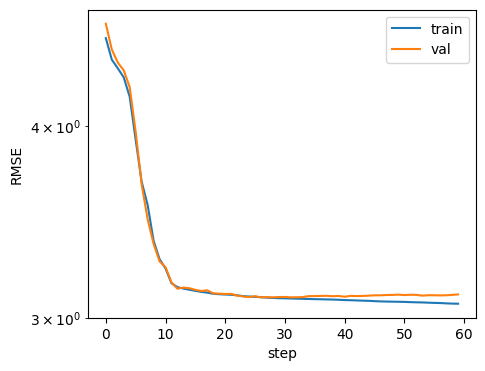

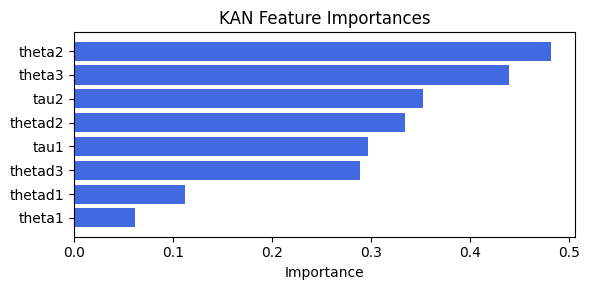

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:58<00:00, 13.78it/s]

[('tau1', 0.13820519337547038), ('thetad2', 0.13041977433303117), ('theta1', 0.08626405464424487), ('thetad1', 0.07343245321574926), ('theta2', 0.06557527204961174), ('theta3', 0.04192016121291658), ('tau2', 0.03186322221611747), ('Ex1', 0.009545655210939918), ('thetad3', 0.00406091846169196)]


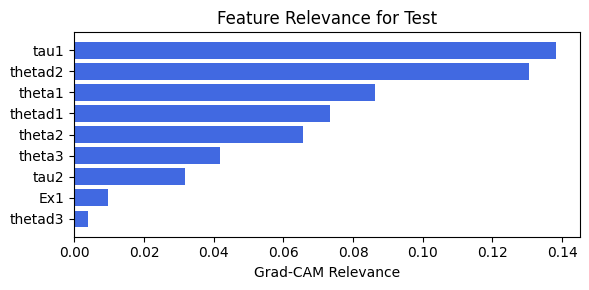

In [154]:
train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, embed_dim=64, filename=filename_4, opt_col_val=64)

### 4.0.2 width=[8, 2], grid=4, lamb=1e-05 | embed_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.13e+00 | eval_loss: 3.13e+00 | reg: 2.05e+01 |: 100%|█| 60/60 [00:32<00:00,  1.85it/

saving model version 0.1
Best epoch 59
3.2823119163513184
M_KAN Relevance: 0.02096506766974926
CNN Relevance: 0.979034960269928
[('theta2', 0.48199216), ('theta3', 0.43923533), ('tau2', 0.35302573), ('thetad2', 0.33432063), ('tau1', 0.296769), ('thetad3', 0.2886547), ('thetad1', 0.11158144), ('theta1', 0.060842995)]


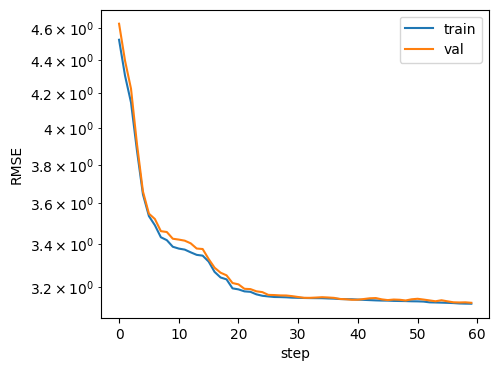

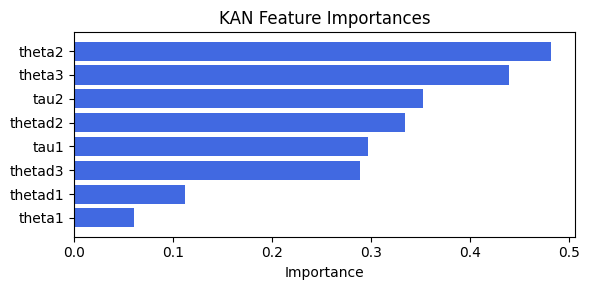

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:02<00:00, 13.35it/s]

[('thetad3', 0.3854363267584799), ('theta3', 0.37913414415968166), ('Ex1', 0.2020490083195976), ('thetad2', 0.1461656834663506), ('thetad1', 0.07753082989023703), ('tau1', 0.07362526708011984), ('theta1', 0.07146446752571345), ('theta2', 0.05936723251655812), ('tau2', 0.023877251440718703)]


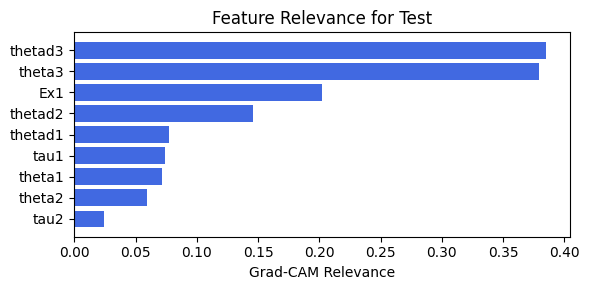

In [155]:
train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, embed_dim=32, filename=filename_4, opt_col_val=32)

### 4.0.3 width=[8, 2], grid=4, lamb=1e-05 | embed_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 1.95e+01 |: 100%|█| 60/60 [00:30<00:00,  1.94it/

saving model version 0.1
Best epoch 56
3.268195867538452
M_KAN Relevance: 0.002213351894170046
CNN Relevance: 0.9977866411209106
[('theta2', 0.4820076), ('theta3', 0.43923753), ('tau2', 0.3530079), ('thetad2', 0.3343025), ('tau1', 0.29675165), ('thetad3', 0.2886368), ('thetad1', 0.11153492), ('theta1', 0.06078826)]


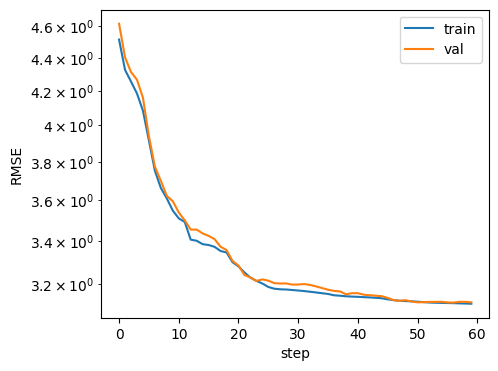

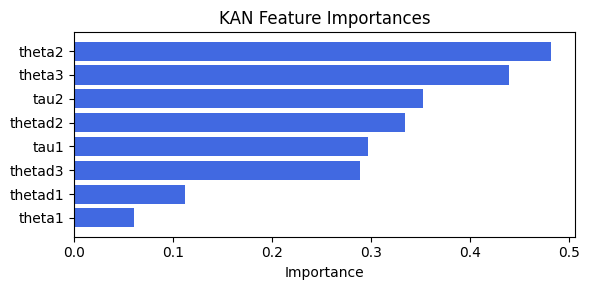

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.50it/s]

[('thetad3', 0.41237279898450097), ('theta3', 0.34209907728845684), ('Ex1', 0.2565323435968718), ('thetad2', 0.15220284664909944), ('tau2', 0.09637290719408804), ('thetad1', 0.09322165796406477), ('theta1', 0.07301622435736867), ('theta2', 0.07217658437517722), ('tau1', 0.05991708860105826)]


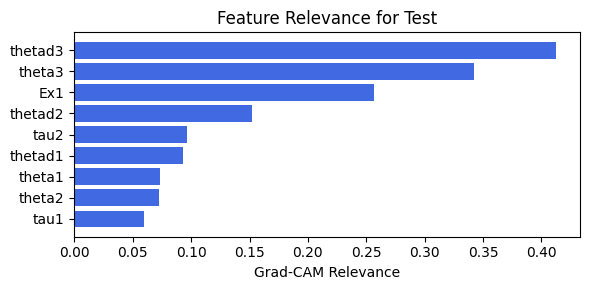

In [156]:
train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, embed_dim=32, filename=filename_4, opt_col_val=32)

### 4.0.4 width=[8, 2], grid=4, lamb=1e-05 | embed_dim=16

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.18e+00 | eval_loss: 3.16e+00 | reg: 2.04e+01 |: 100%|█| 60/60 [00:29<00:00,  2.06it/

saving model version 0.1
Best epoch 59
3.31817626953125
M_KAN Relevance: 0.031924400478601456
CNN Relevance: 0.9680755734443665
[('theta2', 0.48214307), ('theta3', 0.4392534), ('tau2', 0.3528562), ('thetad2', 0.33414233), ('tau1', 0.29660207), ('thetad3', 0.28847894), ('thetad1', 0.11112942), ('theta1', 0.0603104)]


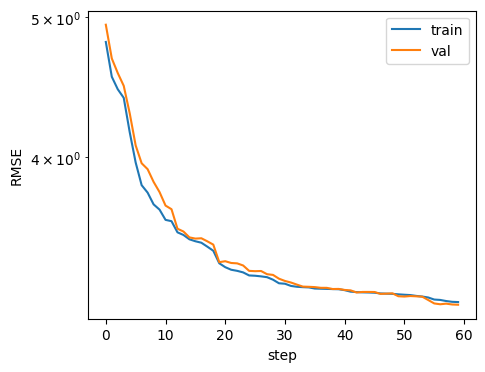

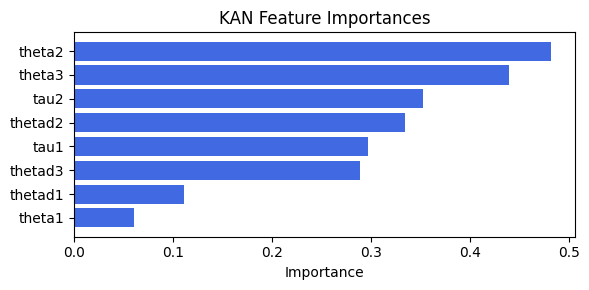

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:02<00:00, 13.40it/s]

[('tau2', 0.5827977184703871), ('tau1', 0.5622516828926304), ('Ex1', 0.39328849850685005), ('thetad2', 0.3064877969794054), ('thetad1', 0.2840933293546891), ('theta3', 0.28278605604319196), ('theta1', 0.22775555569451433), ('theta2', 0.2042660550882593), ('thetad3', 0.14868148862822558)]


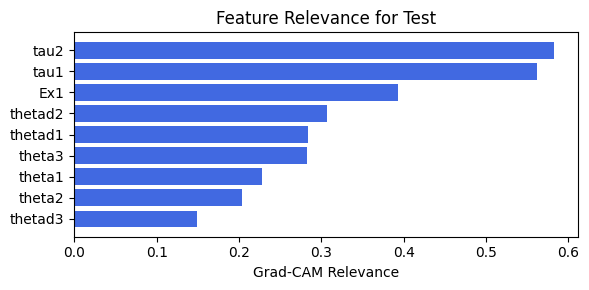

In [157]:
train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, embed_dim=16, filename=filename_4, opt_col_val=16)

### 4.0.5 width=[8, 2], grid=4, lamb=1e-05 | embed_dim=16

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.15e+00 | eval_loss: 3.14e+00 | reg: 1.77e+01 |: 100%|█| 60/60 [00:28<00:00,  2.11it/

saving model version 0.1
Best epoch 55
3.2870585918426514
M_KAN Relevance: 0.2729294002056122
CNN Relevance: 0.7270706295967102
[('theta2', 0.48208308), ('theta3', 0.43924624), ('tau2', 0.35292384), ('thetad2', 0.33421382), ('tau1', 0.29666877), ('thetad3', 0.288549), ('thetad1', 0.11130975), ('theta1', 0.0605224)]


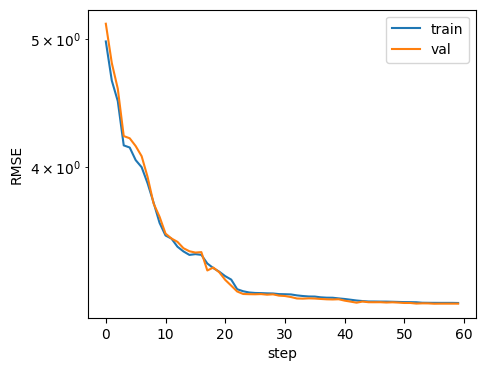

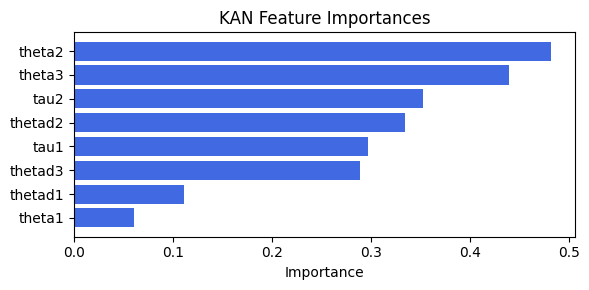

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:59<00:00, 13.67it/s]


[('tau1', 0.31761398314820977), ('theta1', 0.2226043828796553), ('tau2', 0.21812112487585258), ('theta3', 0.21144084276816788), ('thetad1', 0.20515523331330984), ('theta2', 0.19376852609868128), ('thetad2', 0.18903820866311735), ('thetad3', 0.12737825332637626), ('Ex1', 0.07115316628997151)]


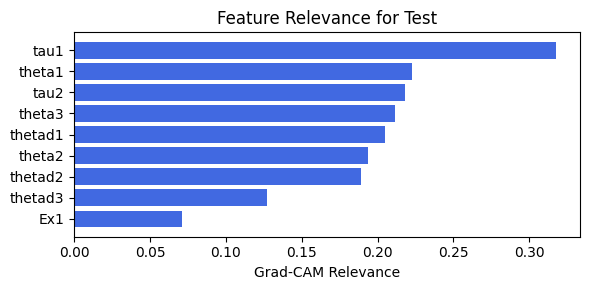

In [158]:
train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, embed_dim=16, filename=filename_4, opt_col_val=16)

embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.09e+00 | eval_loss: 3.10e+00 | reg: 2.13e+01 |: 100%|█| 80/80 [00:36<00:00,  2.20it/

saving model version 0.1
Best epoch 79
3.2548255920410156
M_KAN Relevance: 0.1239180788397789
CNN Relevance: 0.8760819435119629
[('thetad2', 0.5615492), ('theta3', 0.39042836), ('theta2', 0.30735558), ('thetad1', 0.30041778), ('tau2', 0.27362478), ('tau1', 0.2642992), ('theta1', 0.22570466), ('thetad3', 0.031172609)]


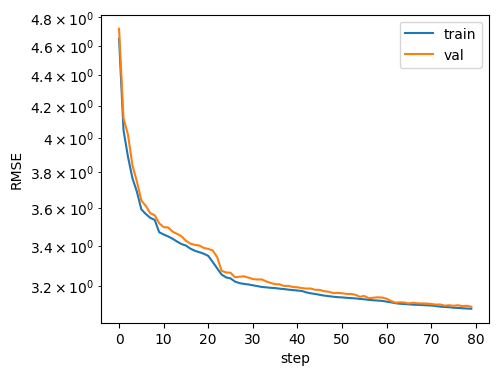

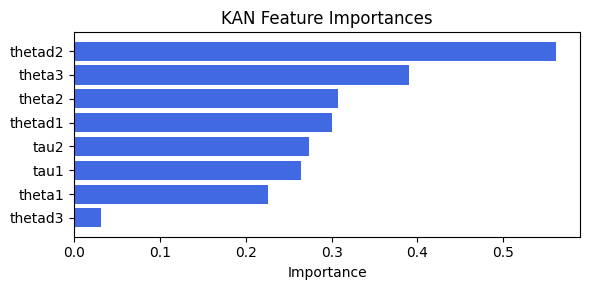

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:00<00:00, 13.58it/s]

[('tau1', 0.3839706898660468), ('theta3', 0.3814496695425418), ('theta1', 0.29000594485161285), ('tau2', 0.28143534953857147), ('Ex1', 0.27532256260779053), ('thetad2', 0.26646787045327347), ('thetad3', 0.2603298845752628), ('thetad1', 0.25382086818615107), ('theta2', 0.24017737309271453)]


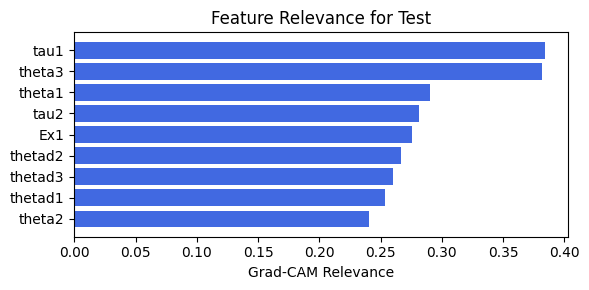

embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.09e+00 | eval_loss: 3.10e+00 | reg: 2.04e+01 |: 100%|█| 80/80 [00:41<00:00,  1.91it/

saving model version 0.1
Best epoch 72
3.2498533725738525
M_KAN Relevance: 0.04322905093431473
CNN Relevance: 0.9567710161209106
[('thetad2', 0.56030285), ('theta3', 0.39052543), ('theta2', 0.30859807), ('thetad1', 0.30167186), ('tau2', 0.27512822), ('tau1', 0.2660303), ('theta1', 0.2271959), ('thetad3', 0.03362783)]


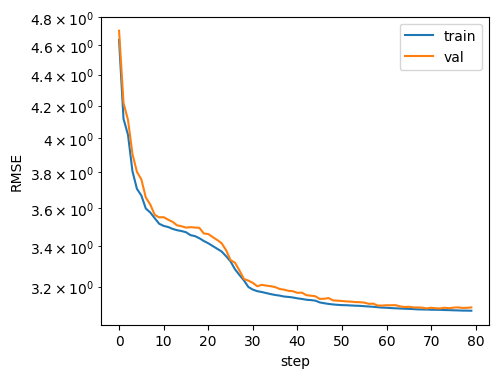

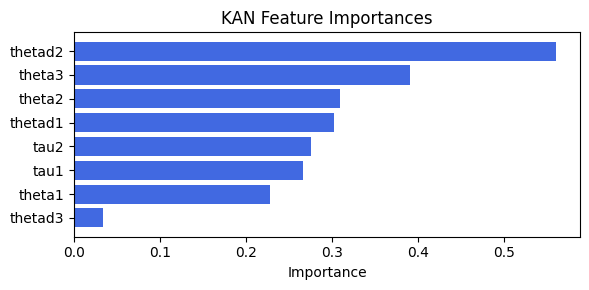

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.53it/s]

[('tau1', 0.4229950550845572), ('tau2', 0.3610206683412258), ('thetad1', 0.349754388897357), ('theta1', 0.34477235179177423), ('theta3', 0.33561598415503346), ('Ex1', 0.3287013327160792), ('thetad2', 0.3222724864868128), ('thetad3', 0.31822675894880514), ('theta2', 0.2963272955054267)]


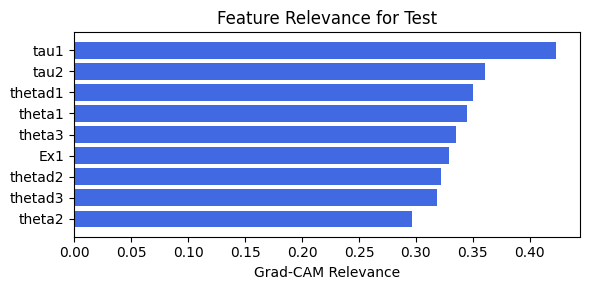

embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.10e+00 | eval_loss: 3.10e+00 | reg: 2.35e+01 |: 100%|█| 80/80 [00:41<00:00,  1.93it/

saving model version 0.1
Best epoch 78
3.2708752155303955
M_KAN Relevance: 0.07497963309288025
CNN Relevance: 0.9250203967094421
[('thetad2', 0.56160706), ('theta3', 0.39042276), ('theta2', 0.30729985), ('thetad1', 0.3003601), ('tau2', 0.27356008), ('tau1', 0.2642214), ('theta1', 0.22563247), ('thetad3', 0.031059144)]


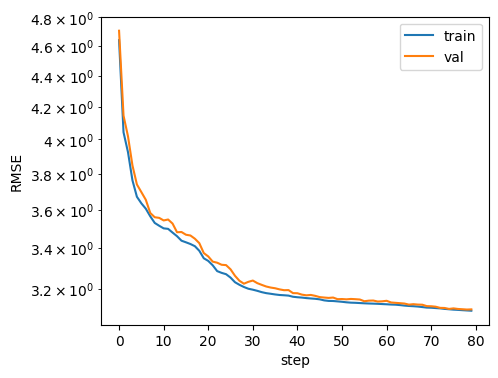

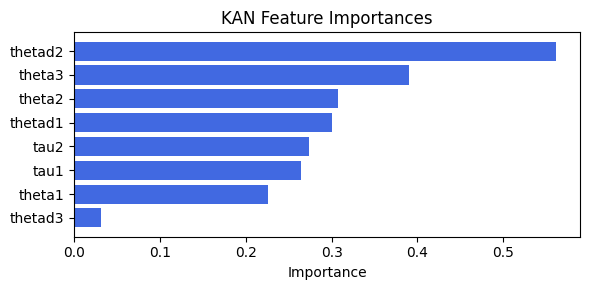

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:00<00:00, 13.63it/s]

[('tau2', 0.39733336336013353), ('thetad2', 0.3905517766603528), ('tau1', 0.37242659503363473), ('thetad1', 0.3318195234812058), ('Ex1', 0.3282228981152113), ('theta1', 0.2732325998224087), ('theta2', 0.24855483571757883), ('theta3', 0.2315647769063416), ('thetad3', 0.21524973591471966)]


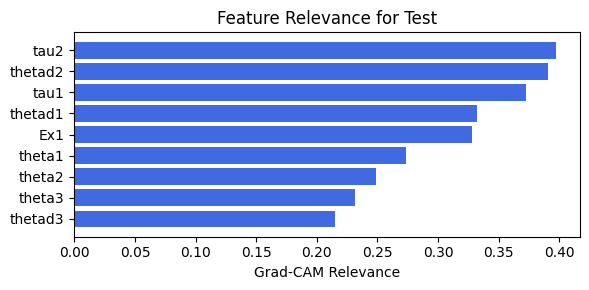

embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.08e+00 | eval_loss: 3.10e+00 | reg: 1.97e+01 |: 100%|█| 80/80 [00:30<00:00,  2.65it/

saving model version 0.1
Best epoch 79
3.244645118713379
M_KAN Relevance: 0.000704989826772362
CNN Relevance: 0.9992949962615967
[('thetad2', 0.5624722), ('theta3', 0.3903442), ('theta2', 0.30641654), ('thetad1', 0.29946896), ('tau2', 0.27249792), ('tau1', 0.2629966), ('theta1', 0.22458962), ('thetad3', 0.029386815)]


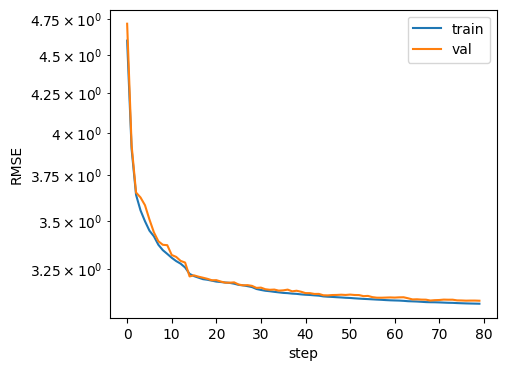

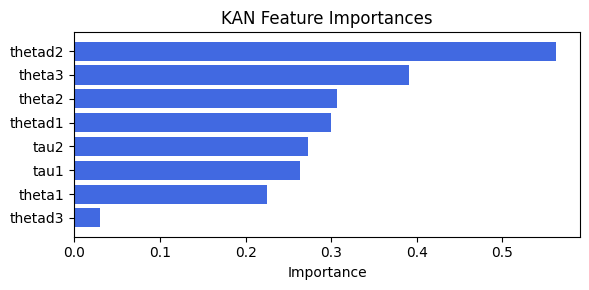

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:59<00:00, 13.67it/s]

[('tau2', 0.5473315387042585), ('tau1', 0.45839397386332964), ('thetad1', 0.3068380614109349), ('theta3', 0.3040935107513346), ('thetad3', 0.29883543174836585), ('theta1', 0.2403317926341967), ('theta2', 0.23229605082385454), ('Ex1', 0.21666024282455043), ('thetad2', 0.17245114986132543)]


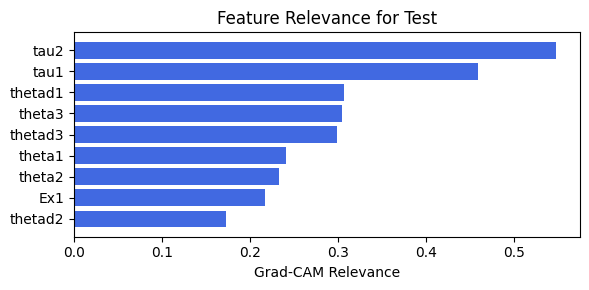

embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.08e+00 | eval_loss: 3.11e+00 | reg: 1.86e+01 |: 100%|█| 80/80 [00:28<00:00,  2.77it/

saving model version 0.1
Best epoch 78
3.255498170852661
M_KAN Relevance: 0.010843334719538689
CNN Relevance: 0.9891566634178162
[('thetad2', 0.5614933), ('theta3', 0.39043152), ('theta2', 0.30742323), ('thetad1', 0.30048013), ('tau2', 0.27371937), ('tau1', 0.26439267), ('theta1', 0.22575793), ('thetad3', 0.03127272)]


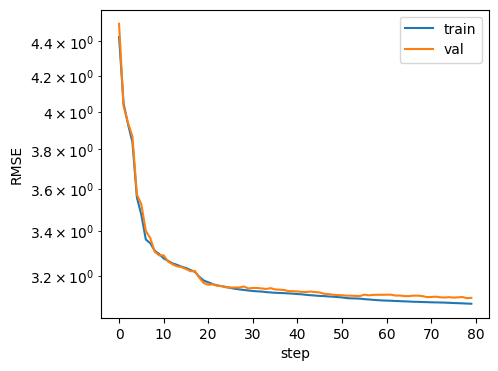

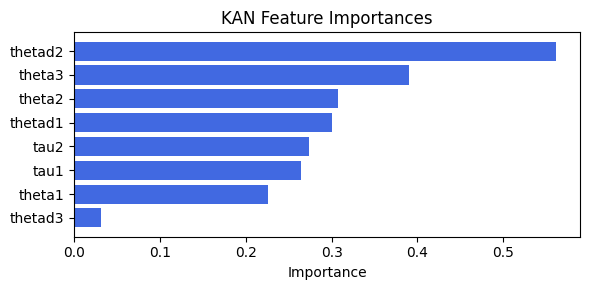

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:55<00:00, 14.13it/s]

[('thetad1', 0.3153794693281027), ('theta1', 0.26366533994280617), ('tau2', 0.1873353263960856), ('theta2', 0.13402723463444424), ('tau1', 0.12688325651229393), ('thetad2', 0.12024516039982001), ('Ex1', 0.029979486666157063), ('thetad3', 0.023468536418196788), ('theta3', 0.009045794988012347)]


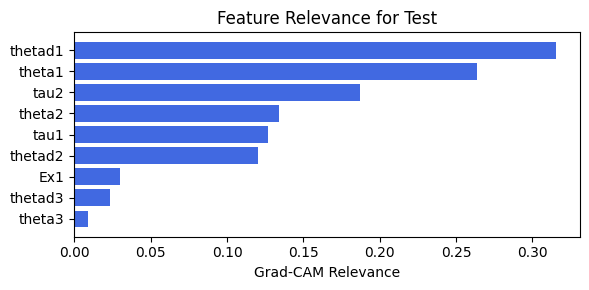

embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.08e+00 | eval_loss: 3.10e+00 | reg: 1.90e+01 |: 100%|█| 80/80 [00:32<00:00,  2.45it/

saving model version 0.1
Best epoch 78
3.261871576309204
M_KAN Relevance: 0.0190525371581316
CNN Relevance: 0.9809474945068359
[('thetad2', 0.5582144), ('theta3', 0.3906512), ('theta2', 0.31060147), ('thetad1', 0.3036995), ('tau2', 0.27756447), ('tau1', 0.26884213), ('theta1', 0.22966957), ('thetad3', 0.037810512)]


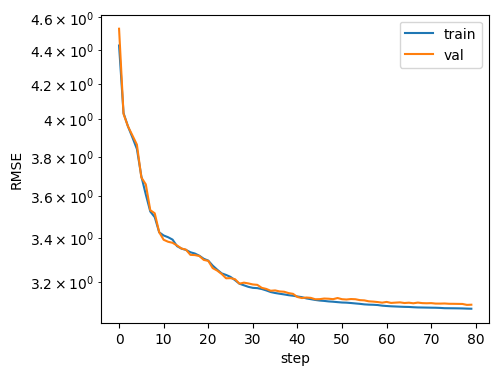

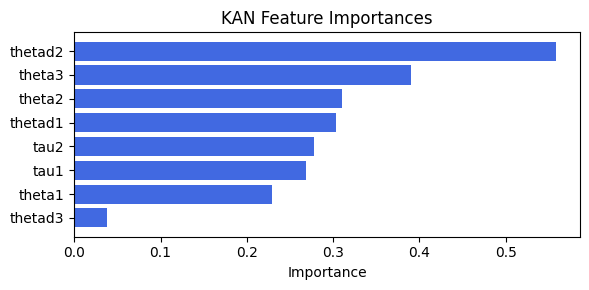

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:59<00:00, 13.74it/s]

[('tau2', 0.7599160120079853), ('tau1', 0.49362956404510105), ('theta3', 0.20645093122923228), ('thetad3', 0.19209499279019815), ('thetad1', 0.18405593778041937), ('Ex1', 0.15035539555945504), ('theta2', 0.11950726110736846), ('theta1', 0.11837661062522405), ('thetad2', 0.08050754593982594)]


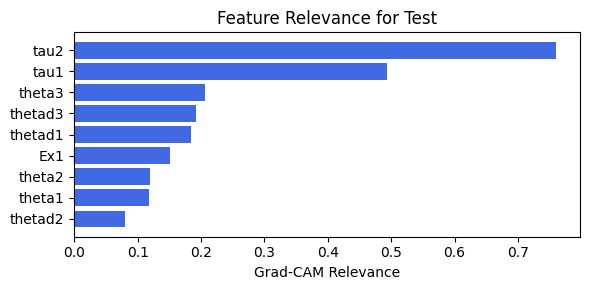

embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.05e+00 | eval_loss: 3.13e+00 | reg: 2.16e+01 |: 100%|█| 80/80 [00:29<00:00,  2.70it/

saving model version 0.1
Best epoch 53
3.2507522106170654
M_KAN Relevance: 0.24240635335445404
CNN Relevance: 0.7575936317443848
[('thetad2', 0.5610411), ('theta3', 0.39046997), ('theta2', 0.3078691), ('thetad1', 0.3009343), ('tau2', 0.2742484), ('tau1', 0.26501313), ('theta1', 0.22631034), ('thetad3', 0.03216458)]


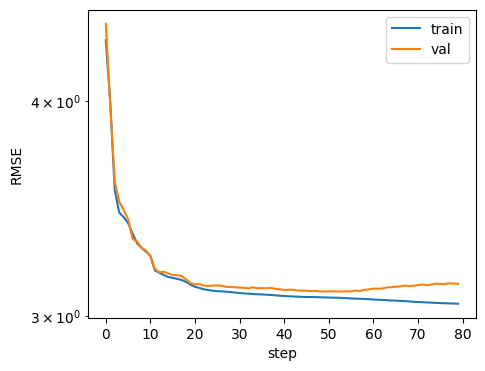

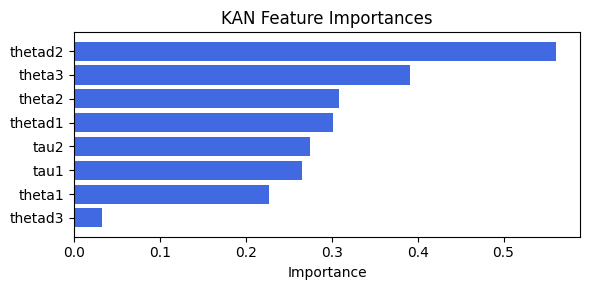

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:56<00:00, 14.06it/s]

[('tau1', 0.3915524207428254), ('theta3', 0.3841458381611651), ('tau2', 0.3705816386931071), ('Ex1', 0.33239951322929917), ('thetad3', 0.31319426706785153), ('theta2', 0.19492088593496096), ('thetad1', 0.19220286381226068), ('thetad2', 0.1740061720395584), ('theta1', 0.16981843084607176)]


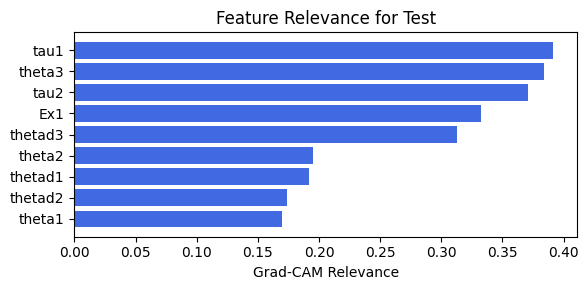

embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.07e+00 | eval_loss: 3.10e+00 | reg: 2.10e+01 |: 100%|█| 80/80 [00:28<00:00,  2.83it/

saving model version 0.1
Best epoch 77
3.2497313022613525
M_KAN Relevance: 0.12068072706460953
CNN Relevance: 0.8793192505836487
[('thetad2', 0.5657704), ('theta3', 0.38996375), ('theta2', 0.30286464), ('thetad1', 0.29590303), ('tau2', 0.2682435), ('tau1', 0.25811592), ('theta1', 0.22060221), ('thetad3', 0.023312127)]


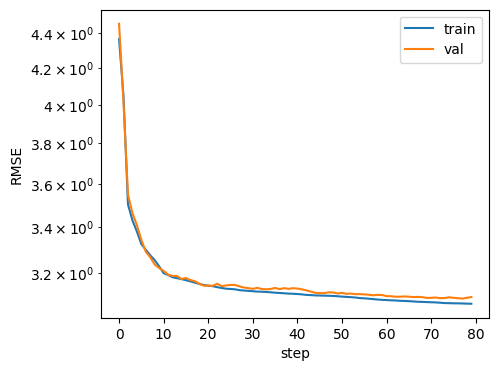

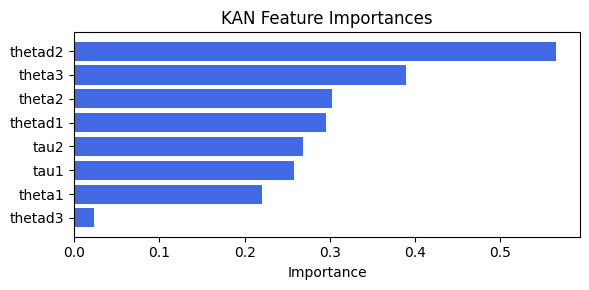

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:57<00:00, 13.99it/s]

[('theta3', 0.5211067769234755), ('thetad3', 0.47864152845013197), ('Ex1', 0.4203401603591086), ('tau1', 0.35510423815158004), ('tau2', 0.35126211779006744), ('theta1', 0.1558528782706278), ('thetad1', 0.14832928543545032), ('theta2', 0.13844508531156424), ('thetad2', 0.08549101320986588)]


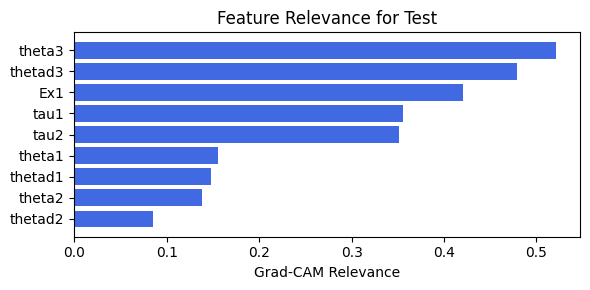

embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.06e+00 | eval_loss: 3.11e+00 | reg: 1.99e+01 |: 100%|█| 80/80 [00:36<00:00,  2.17it/

saving model version 0.1
Best epoch 51
3.2494916915893555
M_KAN Relevance: 0.09953805059194565
CNN Relevance: 0.9004619121551514
[('thetad2', 0.56047463), ('theta3', 0.39051244), ('theta2', 0.30843163), ('thetad1', 0.30150205), ('tau2', 0.27493006), ('tau1', 0.26579767), ('theta1', 0.22698693), ('thetad3', 0.03328748)]


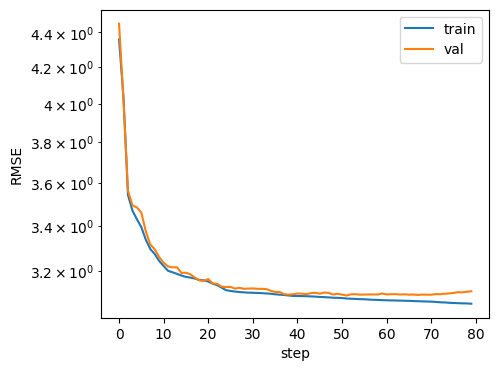

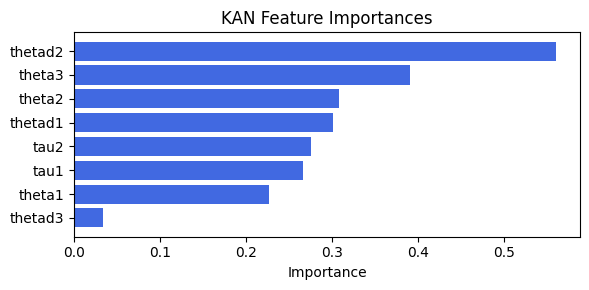

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:00<00:00, 13.59it/s]

[('theta3', 0.4627530006190576), ('thetad3', 0.33862262848537183), ('Ex1', 0.28484597443341597), ('tau1', 0.2639673774078721), ('theta2', 0.23740799733960863), ('tau2', 0.22928715468716168), ('theta1', 0.21621831529446153), ('thetad1', 0.16144595519616003), ('thetad2', 0.13891506748041582)]


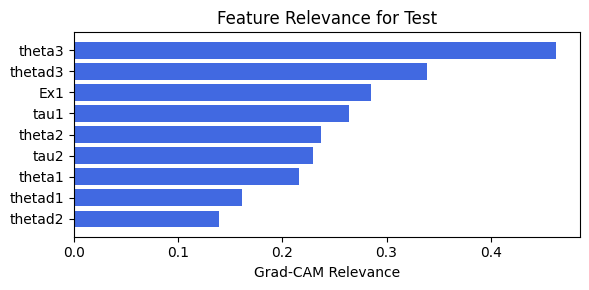

In [45]:
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=80, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.14e+00 | eval_loss: 3.13e+00 | reg: 2.64e+01 |: 100%|█| 90/90 [00:37<00:00,  2.43it/

saving model version 0.1
Best epoch 85
3.2783751487731934
M_KAN Relevance: 0.008304701186716557
CNN Relevance: 0.9916952848434448
[('thetad2', 0.5582279), ('theta3', 0.39064974), ('theta2', 0.310592), ('thetad1', 0.30368793), ('tau2', 0.2775577), ('tau1', 0.26882976), ('theta1', 0.22964808), ('thetad3', 0.037778094)]


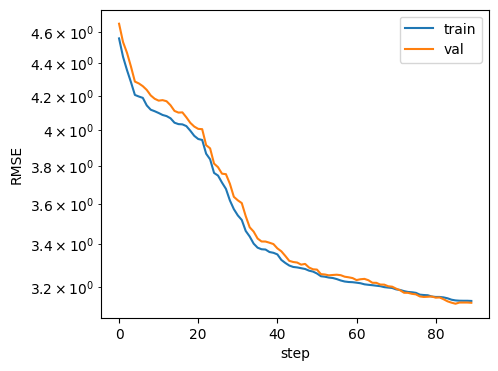

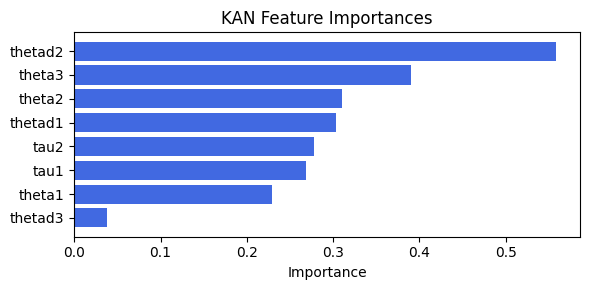

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:00<00:00, 13.55it/s]

[('thetad1', 0.18505561873240764), ('theta1', 0.15675043310320017), ('thetad2', 0.14038861901686414), ('tau2', 0.05574985745356851), ('theta2', 0.05389673427550199), ('tau1', 0.029058649711426958), ('Ex1', 0.005078007316773084), ('theta3', 0.001623337810139994), ('thetad3', 0.00016331355245594636)]


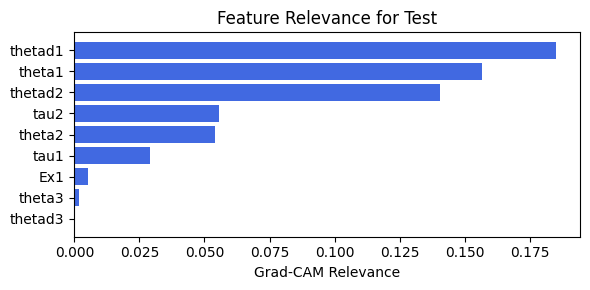

embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.06e+00 | eval_loss: 3.11e+00 | reg: 2.72e+01 |: 100%|█| 90/90 [00:33<00:00,  2.68it/

saving model version 0.1
Best epoch 46
3.252990245819092
M_KAN Relevance: 0.00728618074208498
CNN Relevance: 0.9927137494087219
[('thetad2', 0.5595832), ('theta3', 0.39057225), ('theta2', 0.3093054), ('thetad1', 0.30238327), ('tau2', 0.27599478), ('tau1', 0.26702046), ('theta1', 0.2280426), ('thetad3', 0.035055205)]


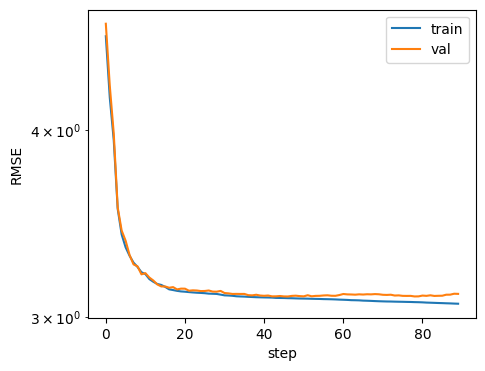

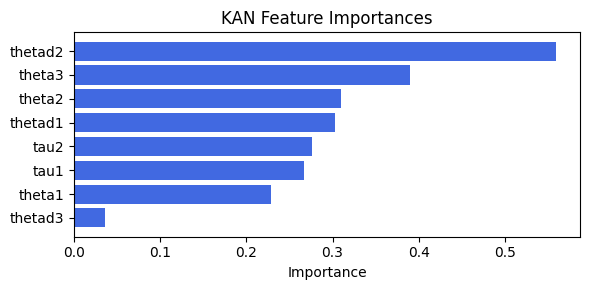

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:00<00:00, 13.63it/s]

[('thetad3', 0.37670334650942744), ('Ex1', 0.3494973729323149), ('theta3', 0.3367918090572403), ('thetad2', 0.07187835982281321), ('tau1', 0.06687387797993824), ('theta1', 0.052127071851401356), ('thetad1', 0.04789197104836447), ('theta2', 0.03168116766392126), ('tau2', 0.016949276814093476)]


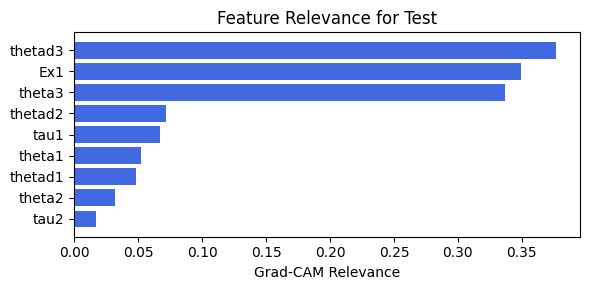

embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.00e+00 | eval_loss: 3.18e+00 | reg: 1.88e+01 |: 100%|█| 90/90 [00:31<00:00,  2.86it/

saving model version 0.1
Best epoch 21
3.27103853225708
M_KAN Relevance: 0.24872171878814697
CNN Relevance: 0.751278281211853
[('thetad2', 0.55867326), ('theta3', 0.39062703), ('theta2', 0.31017095), ('thetad1', 0.30326235), ('tau2', 0.27704176), ('tau1', 0.26823586), ('theta1', 0.22912674), ('thetad3', 0.036883783)]


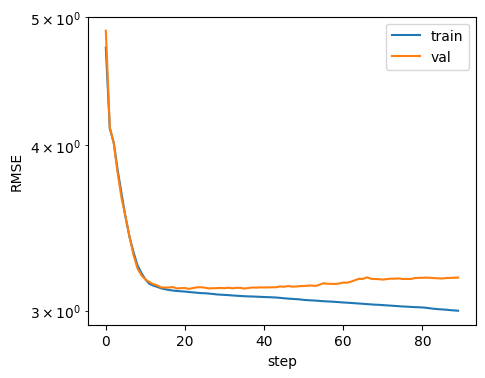

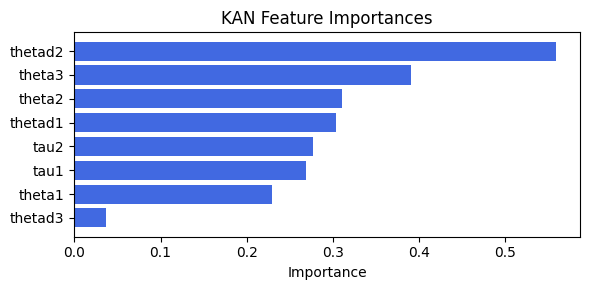

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.53it/s]

[('tau2', 0.5407524877698761), ('tau1', 0.43450520874626114), ('thetad1', 0.3349619933682168), ('Ex1', 0.29495106953395606), ('thetad2', 0.2888390846417233), ('theta1', 0.24362225323398964), ('theta2', 0.22653133819837754), ('theta3', 0.17338097822529577), ('thetad3', 0.11003151026218015)]


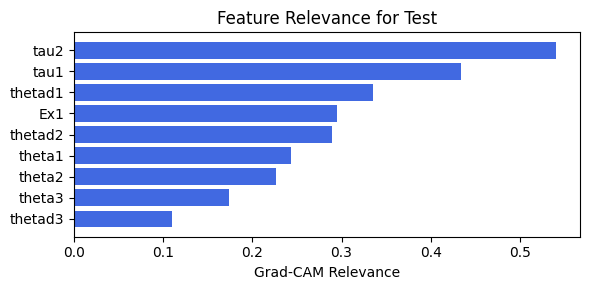

In [45]:
for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=90, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

### 4.1.0 width=[8, 3], grid=5, lamb=0.0001 | embed_dim=64

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.11e+00 | eval_loss: 3.11e+00 | reg: 2.35e+01 |: 100%|█| 70/70 [00:47<00:00,  1.48it/

saving model version 0.1
Best epoch 68
3.253797769546509
M_KAN Relevance: 0.0815720185637474
CNN Relevance: 0.9184279441833496
[('thetad2', 0.5602724), ('theta3', 0.39052564), ('theta2', 0.30863625), ('thetad1', 0.30170572), ('tau2', 0.27518532), ('tau1', 0.26608437), ('theta1', 0.22722062), ('thetad3', 0.033682317)]


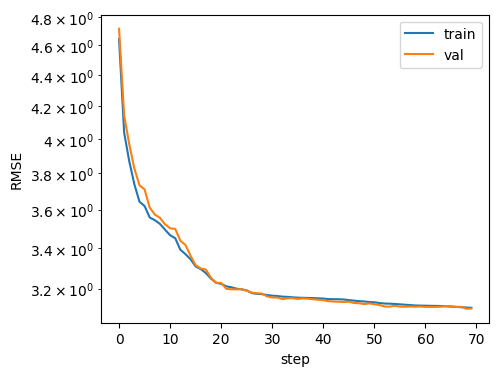

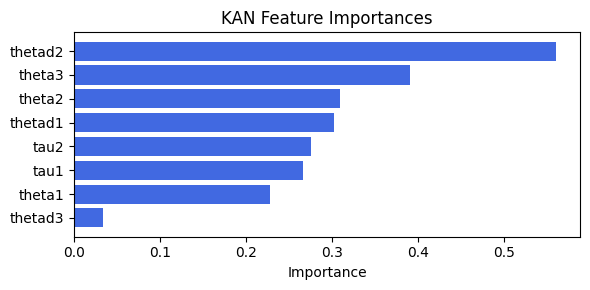

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.30it/s]

[('theta3', 0.43609405897664527), ('theta2', 0.4243740170168677), ('thetad3', 0.4230524694812338), ('theta1', 0.41532409164293566), ('thetad1', 0.3694940838951997), ('thetad2', 0.3594570966625009), ('tau1', 0.352925834319059), ('tau2', 0.24335983815000808), ('Ex1', 0.16282580029140548)]


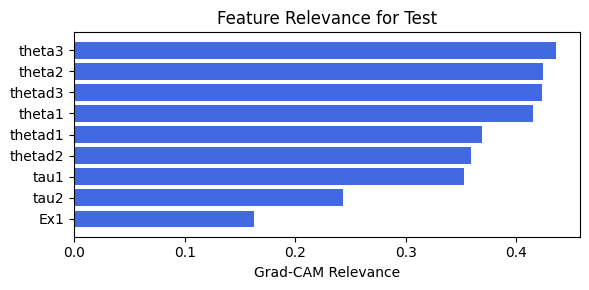

In [159]:
train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=70, embed_dim=64, filename=filename_4, opt_col_val=64)

### 4.1.1 width=[8, 3], grid=5, lamb=0.0001 | embed_dim=64

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 1.87e+01 |: 100%|█| 70/70 [00:47<00:00,  1.49it/

saving model version 0.1
Best epoch 69
3.270530939102173
M_KAN Relevance: 0.08909883350133896
CNN Relevance: 0.9109011888504028
[('thetad2', 0.5603849), ('theta3', 0.39051908), ('theta2', 0.30852148), ('thetad1', 0.30159205), ('tau2', 0.27504066), ('tau1', 0.26592308), ('theta1', 0.22709191), ('thetad3', 0.033461932)]


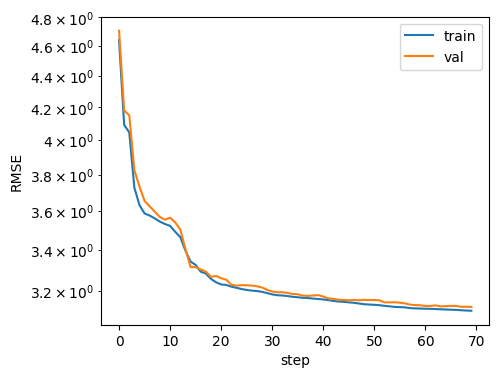

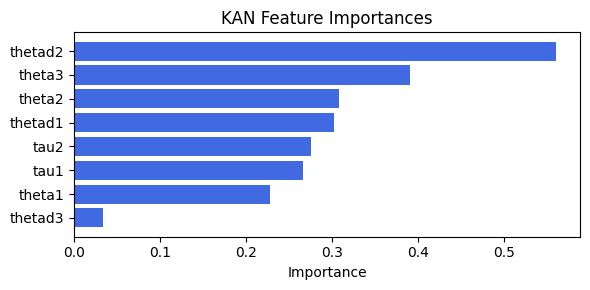

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:07<00:00, 12.81it/s]

[('theta1', 0.3721838832197241), ('thetad1', 0.3714602162482335), ('tau1', 0.3602020979999287), ('thetad2', 0.3324366487634164), ('theta2', 0.32662259056752796), ('tau2', 0.3245245282903462), ('theta3', 0.2694430704246712), ('thetad3', 0.21110655546795584), ('Ex1', 0.09046953491914875)]


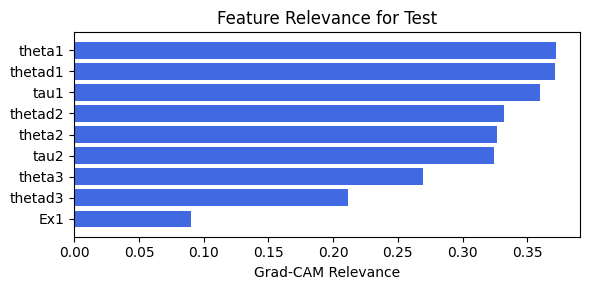

In [160]:
train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=70, embed_dim=64, filename=filename_4, opt_col_val=64)

### 4.1.2 width=[8, 3], grid=5, lamb=0.0001 | embed_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.14e+00 | eval_loss: 3.16e+00 | reg: 2.45e+01 |: 100%|█| 70/70 [00:29<00:00,  2.34it/


saving model version 0.1
Best epoch 52
3.3013341426849365
M_KAN Relevance: 0.010460972785949707
CNN Relevance: 0.9895389676094055
[('thetad2', 0.55718344), ('theta3', 0.39069805), ('theta2', 0.31155133), ('thetad1', 0.30466622), ('tau2', 0.27871752), ('tau1', 0.27018434), ('theta1', 0.23088741), ('thetad3', 0.039907753)]


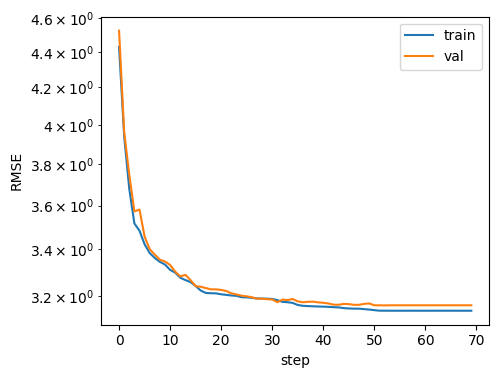

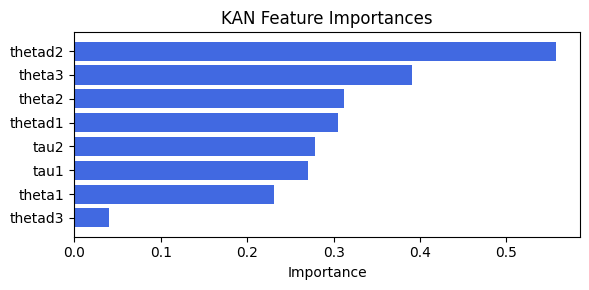

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.37it/s]


[('theta3', 0.3399058887003684), ('theta1', 0.3082658893742617), ('tau1', 0.308241390047406), ('theta2', 0.2861026126295496), ('tau2', 0.2722781884698625), ('thetad1', 0.23634159814100003), ('thetad3', 0.2191568353711491), ('thetad2', 0.21371203698114521), ('Ex1', 0.14363270519575255)]


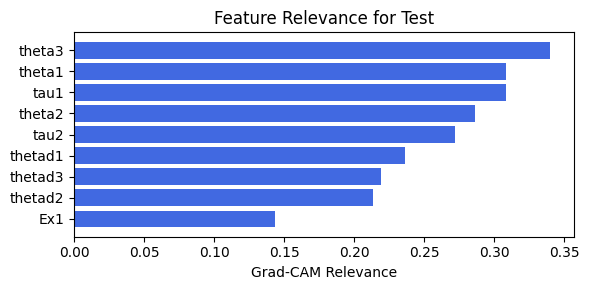

In [161]:
train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=70, embed_dim=32, filename=filename_4, opt_col_val=32)

### 4.1.3 width=[8, 3], grid=5, lamb=0.0001 | embed_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.17e+00 | eval_loss: 3.17e+00 | reg: 2.49e+01 |: 100%|█| 70/70 [00:41<00:00,  1.68it/

saving model version 0.1
Best epoch 69
3.310000419616699
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad2', 0.5575874), ('theta3', 0.39068064), ('theta2', 0.311183), ('thetad1', 0.3042909), ('tau2', 0.27827203), ('tau1', 0.2696628), ('theta1', 0.23040947), ('thetad3', 0.03908134)]


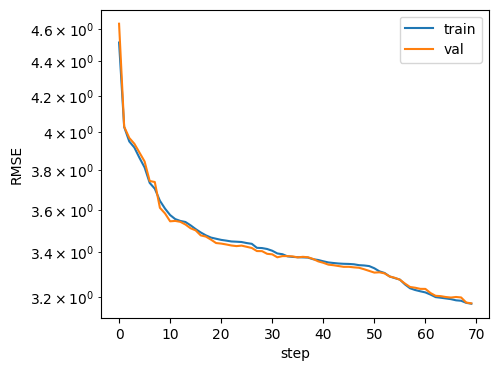

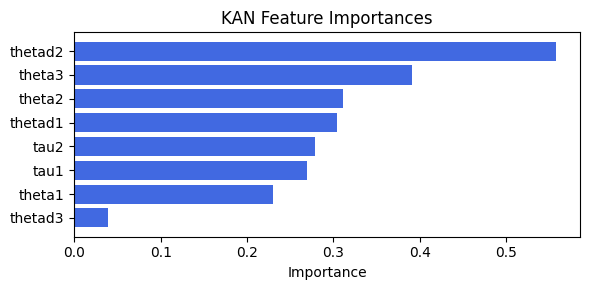

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:08<00:00, 12.72it/s]

[('thetad3', 0.5742915792025903), ('theta3', 0.522808720629893), ('tau2', 0.5090312519550191), ('tau1', 0.4039501772342986), ('Ex1', 0.3374962128194241), ('thetad1', 0.10401931421236361), ('theta2', 0.10030462271741841), ('theta1', 0.09227408637593434), ('thetad2', 0.03203869475255665)]


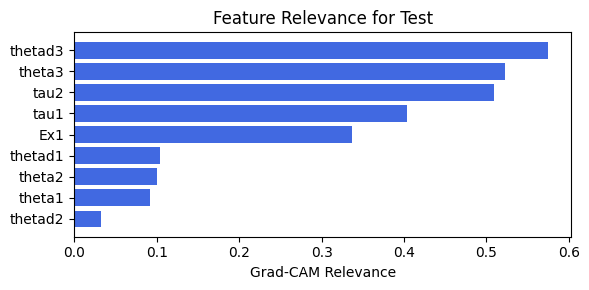

In [162]:
train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=70, embed_dim=32, filename=filename_4, opt_col_val=32)

### 4.1.4 width=[8, 3], grid=5, lamb=0.0001 | embed_dim=16

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.06e+00 | eval_loss: 3.12e+00 | reg: 2.14e+01 |: 100%|█| 70/70 [00:34<00:00,  2.03it/

saving model version 0.1
Best epoch 39
3.2503108978271484
M_KAN Relevance: 0.2893957793712616
CNN Relevance: 0.710604190826416
[('thetad2', 0.5604969), ('theta3', 0.39051038), ('theta2', 0.3084134), ('thetad1', 0.30148184), ('tau2', 0.274912), ('tau1', 0.26577276), ('theta1', 0.22695592), ('thetad3', 0.03323817)]


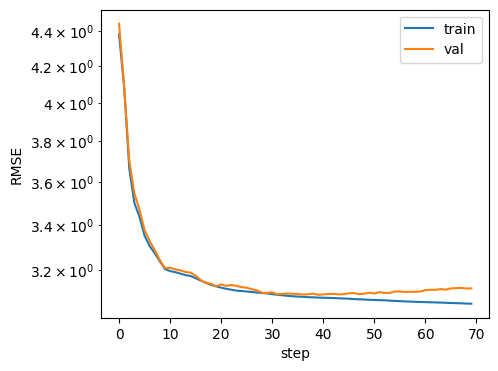

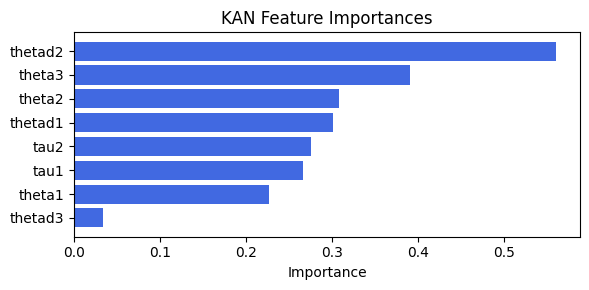

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:05<00:00, 13.09it/s]

[('theta3', 0.47608898376121983), ('thetad3', 0.4208304184634862), ('tau1', 0.3104691551140769), ('Ex1', 0.28336571452644405), ('theta2', 0.26962453366897643), ('theta1', 0.2489421354253595), ('tau2', 0.23409016875932034), ('thetad1', 0.18456371080599054), ('thetad2', 0.13195621483421432)]


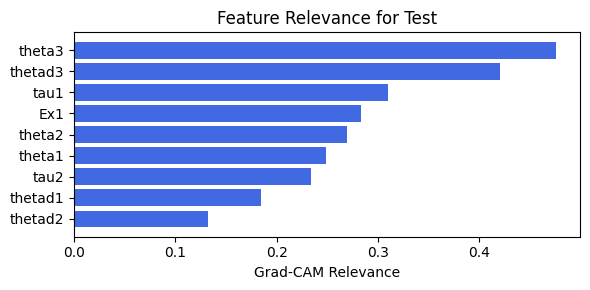

In [163]:
train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=70, embed_dim=16, filename=filename_4, opt_col_val=16)

### 4.1.5 width=[8, 3], grid=5, lamb=0.0001 | embed_dim=16

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.07e+00 | eval_loss: 3.10e+00 | reg: 2.08e+01 |: 100%|█| 70/70 [00:34<00:00,  2.01it/

saving model version 0.1
Best epoch 69
3.260704517364502
M_KAN Relevance: 0.05796044319868088
CNN Relevance: 0.9420395493507385
[('thetad2', 0.563003), ('theta3', 0.39029306), ('theta2', 0.30585453), ('thetad1', 0.29890838), ('tau2', 0.2718104), ('tau1', 0.2622198), ('theta1', 0.22396037), ('thetad3', 0.028368589)]


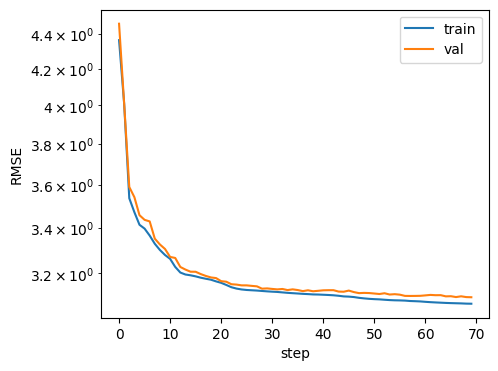

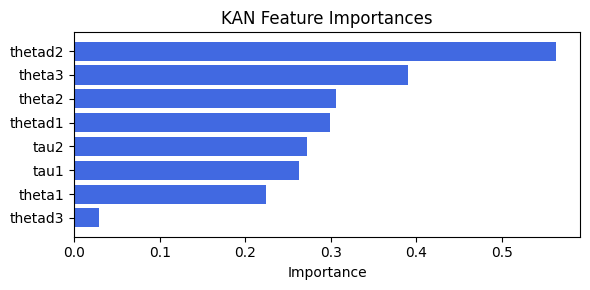

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.21it/s]

[('thetad3', 0.4465396350807424), ('theta3', 0.4188445071657147), ('tau2', 0.2532450319344254), ('theta2', 0.24234922727446845), ('theta1', 0.19529609796066205), ('tau1', 0.17758633548778394), ('Ex1', 0.1538452443959943), ('thetad1', 0.13204013021035155), ('thetad2', 0.1105417845711195)]


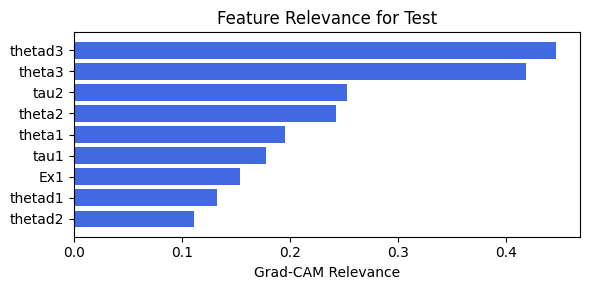

In [164]:
train_and_plot_relevance(Model3_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=70, embed_dim=16, filename=filename_4, opt_col_val=16)

### 2. width=[8, 3, 1], grid=5, lamb=0.01| best_epoch=12 | loss=3.21744

In [52]:
del model
torch.cuda.empty_cache()
gc.collect()

13172740

In [42]:
model = try_create_model(Model3, attributes, imgs_shape, kan_neurons=3, kan_grid=5)
best_model_state, metrics3,_ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.01)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), metrics3['train_loss'], metrics3['val_loss'])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.40e+00 | eval_loss: 3.17e+00 | reg: 1.19e+02 |:   8%| | 3/40 [00:18<03:44,  6.06s/it


KeyboardInterrupt: 

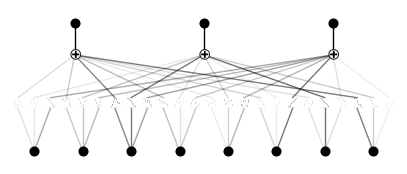

In [54]:
model.m_kan.plot()

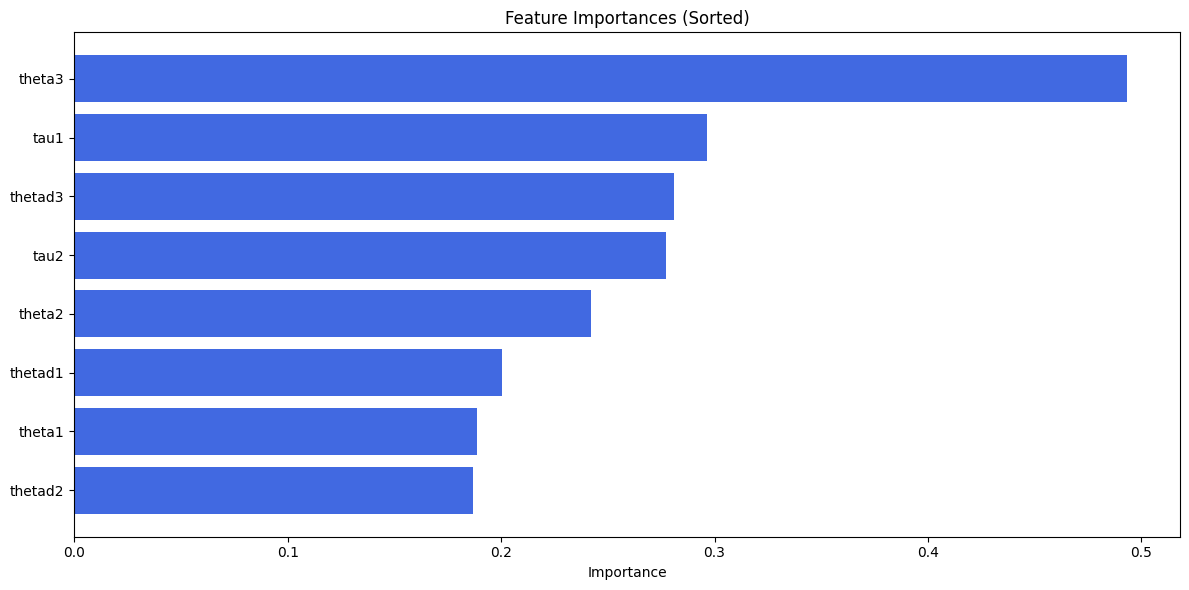

In [55]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

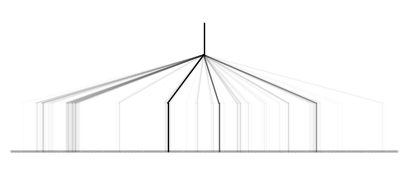

In [56]:
model.final_kan.plot()

In [57]:
feature_score = model.final_kan.feature_score

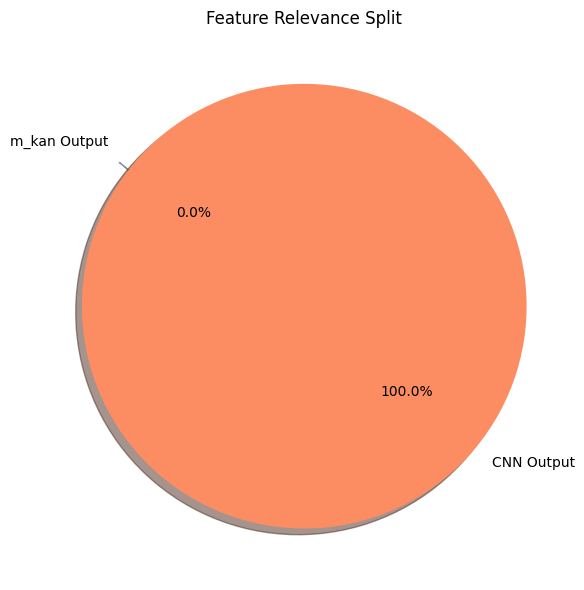

In [58]:
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=3)

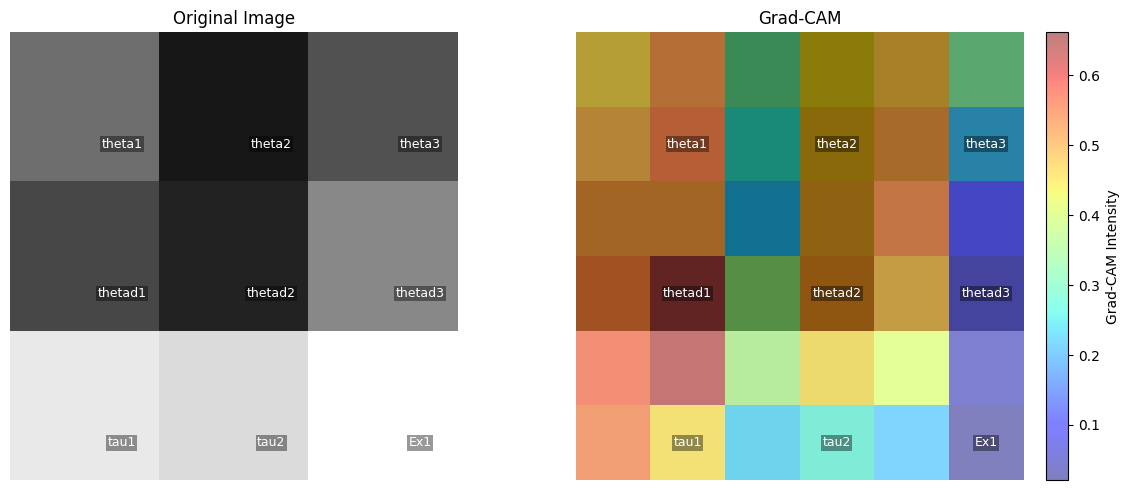

In [59]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:06<00:00,  3.00it/s]


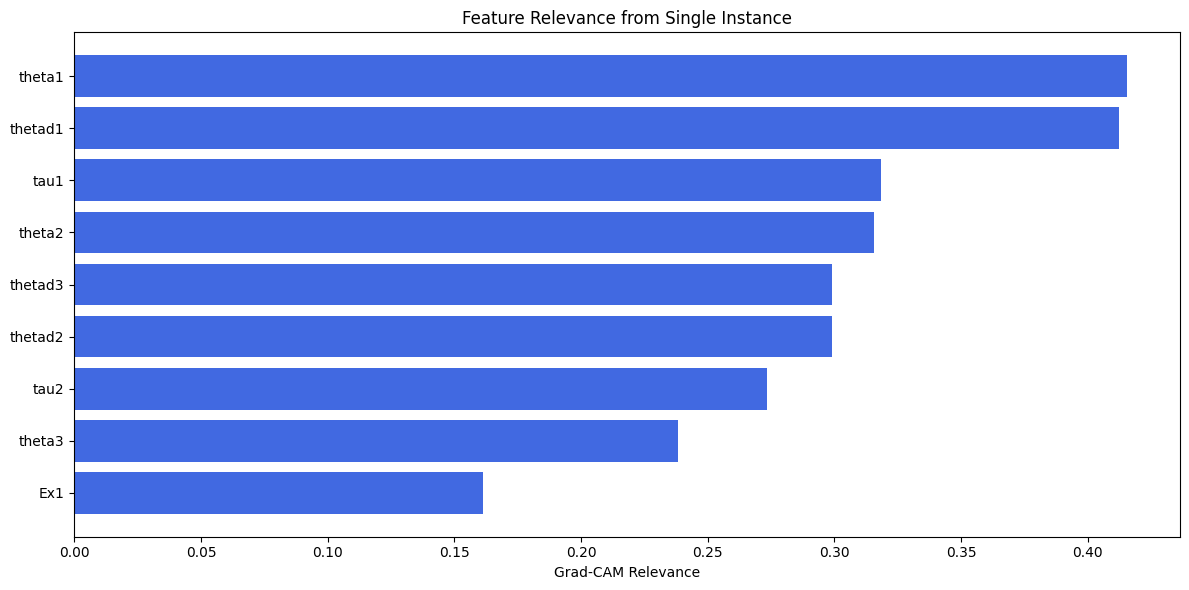

In [60]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)